
# Thesis Code 
## Pre‑Setup (BTC Options Hedging)

This notebook packages the pre‑setup portion of your thesis code with short explanations.
It includes:
- Pricing models (Black–Scholes, MJD, SVJ, SVCJ)
- Robust implied volatility solvers
- Finite‑difference Greeks (Black–Scholes, MJD, SVJ, SVCJ)
- Hedge instrument selection (by strike closeness)
- Data loading + resampling to daily/weekly/5‑day anchored
- Rebalance index construction with quote‑validity checks

**Tip:** Run cells top‑to‑bottom. Adjust file paths and parameters as needed.



## 0) Imports
Core scientific stack, optimization, numerical integration, and plotting.


In [3]:

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, newton, fsolve, minimize_scalar, minimize
from functools import partial
from joblib import Parallel, delayed
from scipy.integrate import quad, quad_vec
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
import time, math, re, warnings
from math import factorial
import matplotlib.dates as mdates
from scipy import stats
import matplotlib.transforms as mtrans
from matplotlib.table import Table
from matplotlib import gridspec
import matplotlib as mpl
from pathlib import Path



## 1) Black–Scholes pricing + robust implied volatility

- `black_scholes(...)` supports arrays for \(S_0\) and returns calls/puts.
- `implied_volatility(...)` tries bracketing, then closest‑fit fallback to guarantee a finite result.


In [4]:

def black_scholes(S, K, T, r, q, sigma, Type="C"):
    """BS price for European call/put. Supports array inputs for S0."""
    """Black–Scholes with full NumPy broadcasting and edge-case guards."""
    Type = str(Type).upper()
    S, K, T, r, q, sigma = np.broadcast_arrays(S, K, T, r, q, sigma)
    # Avoid divide-by-zero
    
    T_pos   = np.maximum(T, 1e-16)
    sigma_p = np.maximum(sigma, 0.0)

    # Intrinsic when T=0 or sigma=0
    fwd   = S * np.exp(-q*T_pos)
    discK = K * np.exp(-r*T_pos)

    out = np.empty_like(S, dtype=float)

    reg_mask = (T_pos > 0) & (sigma_p > 0)
    if np.any(reg_mask):
        S_r = S[reg_mask]; K_r = K[reg_mask]; T_r = T_pos[reg_mask]
        r_r = r[reg_mask]; q_r = q[reg_mask]; sig_r = sigma_p[reg_mask]
        d1 = (np.log(S_r / K_r) + (r_r - q_r + 0.5*sig_r*sig_r)*T_r) / (sig_r*np.sqrt(T_r))
        d2 = d1 - sig_r*np.sqrt(T_r)
        if Type == 'C':
            out[reg_mask] = S_r*np.exp(-q_r*T_r)*norm.cdf(d1) - K_r*np.exp(-r_r*T_r)*norm.cdf(d2)
        else:
            out[reg_mask] = K_r*np.exp(-r_r*T_r)*norm.cdf(-d2) - S_r*np.exp(-q_r*T_r)*norm.cdf(-d1)

    # Degenerate regions
    nonreg = ~reg_mask
    if np.any(nonreg):
        fwd_n   = fwd[nonreg]; discK_n = discK[nonreg]
        if Type == 'C':
            out[nonreg] = np.maximum(fwd_n - discK_n, 0.0)
        else:
            out[nonreg] = np.maximum(discK_n - fwd_n, 0.0)

    return out

def implied_volatility(S0, K, T, r, q, market_price, option_type,
                       sigma_bounds=(1e-8, 5.0), tol=1e-8, maxiter=200,
                       always_return_closest=True, verbose=False):
    """Robust BS implied vol solver with bracket/closest‑fit fallbacks."""
    t = str(option_type).strip().lower()
    is_call = t in ('c', 'call')

    if T <= 0:
        intrinsic = max(0.0, (S0 - K) if is_call else (K - S0))
        return sigma_bounds[0] if abs(market_price - intrinsic) > tol else 0.0

    disc_r = np.exp(-r*T); disc_q = np.exp(-q*T)
    lower = max(0.0, S0*disc_q - K*disc_r) if is_call else max(0.0, K*disc_r - S0*disc_q)
    upper = S0*disc_q if is_call else K*disc_r
    if market_price < lower - 5e-10 and verbose:
        warnings.warn(f"Market price below lower bound ({market_price:.6g} < {lower:.6g}).")
    if market_price > upper + 5e-10 and verbose:
        warnings.warn(f"Market price above upper bound ({market_price:.6g} > {upper:.6g}).")

    def f(sig):
        s = float(max(sig, 1e-12))
        try:
            price = black_scholes(S0, K, T, r, q, s, option_type)
        except Exception:
            return np.inf
        return price - market_price

    lo, hi = map(float, sigma_bounds)
    lo = max(lo, 1e-12)
    flo, fhi = f(lo), f(hi)
    if abs(flo) <= tol: return lo
    if abs(fhi) <= tol: return hi

    # Try expanding hi to find a bracket
    if fhi < 0:
        hi_try = hi
        for _ in range(10):
            hi_try *= 2.0
            if hi_try > 50: break
            fhi_try = f(hi_try)
            if fhi_try > 0:
                try:
                    return brentq(f, hi, hi_try, xtol=tol, rtol=tol, maxiter=maxiter)
                except Exception:
                    break
            hi = hi_try; fhi = fhi_try

    # Grid scan to detect sign change
    grid_lo = min(lo, 1e-8); grid_hi = max(hi, 10.0)
    sig_grid = np.unique(np.r_[np.logspace(-8, np.log10(grid_hi), 60),
                               np.linspace(grid_lo, grid_hi, 60)])
    vals = np.array([f(s) for s in sig_grid])
    sign = np.sign(vals)
    change_idx = np.where(sign[:-1] * sign[1:] < 0)[0]

    if change_idx.size > 0:
        a = float(sig_grid[change_idx[0]]); b = float(sig_grid[change_idx[0] + 1])
        try:
            return brentq(f, a, b, xtol=tol, rtol=tol, maxiter=maxiter)
        except Exception as e:
            if verbose:
                warnings.warn(f"Brent failed on [{a:.4g},{b:.4g}] ({e}); using closest‑fit.")

    # Closest‑fit fallback
    i_best = int(np.nanargmin(np.abs(vals)))
    s_best = float(sig_grid[i_best])
    try:
        res = minimize_scalar(lambda s: abs(f(s)),
                              bounds=(max(1e-12, s_best/3), min(grid_hi, s_best*3)),
                              method='bounded',
                              options={'xatol': tol})
        if res.success and np.isfinite(res.x):
            return float(res.x)
    except Exception:
        pass

    if always_return_closest:
        candidates = [lo, hi, s_best]
        errs = [abs(f(c)) for c in candidates]
        return float(candidates[int(np.nanargmin(errs))])
    return np.nan



## 2) Black–Scholes Greeks
Closed‑form Delta/Gamma/Vega for later hedging weight calculations.


In [5]:

def Compute_BS_delta(S0, K, T, r, q, sigma, option_type):
    d1 = (np.log(S0 / K) + ((r - q) + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == "C":
        return norm.cdf(d1)
    elif option_type == "P":
        return norm.cdf(d1) - 1
    else:
        raise ValueError("Invalid option type. Use 'C' or 'P'.")

def Compute_BS_gamma(S0, K, T, r, q, sigma):
    d1 = (np.log(S0 / K) + ((r - q) + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

def Compute_BS_vega(S0, K, T, r, q, sigma):
    d1 = (np.log(S0 / K) + ((r - q) + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S0 * np.sqrt(T) * norm.pdf(d1) / 100 #per 1% change



## 3) Merton Jump–Diffusion (MJD): pricing + robust implied vol + FD Greeks

- MJD pricing (`MJD_price`)
- Robust implied vol for MJD (`mjd_implied_volatility`)
- Finite‑difference Greeks on top of `MJD_price`


In [6]:

# def MJD_price(S0, K, T, r, q, sigma, lam, muJ, sigJ, Type):
#     """Vectorized European option pricing under Merton Jump Diffusion."""
#     S0, K, T, Type = np.broadcast_arrays(S0, K, T, Type)

#     def single_price(s, k, t, ttype):
#         ttype = str(ttype).upper()
#         if t <= 0:
#             return max((s - k) if ttype == 'C' else (k - s), 0)

#         logk = np.log(k / s)
#         mu = r - q - 0.5 * sigma**2 - lam * (np.exp(muJ + 0.5 * sigJ**2) - 1)

#         def cf(u):
#             return np.exp(
#                 t * (
#                     1j * u * mu
#                     - 0.5 * u**2 * sigma**2
#                     + lam * (np.exp(1j * u * muJ - 0.5 * u**2 * sigJ**2) - 1)
#                 )
#             )

#         def Q1(logk):
#             integrand = lambda u: 0.0 if np.abs(u) < 1e-6 else np.real(
#                 (np.exp(-1j * u * logk) / (1j * u)) * cf(u - 1j) / cf(-1j))
#             I1 = quad(integrand, 1e-6, 25, limit=1000)[0]
#             return 0.5 + (1 / np.pi) * I1

#         def Q2(logk):
#             integrand = lambda u: 0.0 if np.abs(u) < 1e-6 else np.real((np.exp(-1j * u * logk) / (1j * u)) * cf(u))
#             I1 = quad(integrand, 1e-6, 25, limit=1000)[0]
#             return 0.5 + (1 / np.pi) * I1

#         call = s * np.exp(-q * t) * Q1(logk) - k * np.exp(-r * t) * Q2(logk)
#         return call if ttype == 'C' else call - s * np.exp(-q * t) + k * np.exp(-r * t)

#     vec_price = np.vectorize(single_price)
#     return vec_price(S0, K, T, Type)

def MJD_price(S0, K, T, r, q, sigma, lam, muJ, sigJ, Type='C',
              atol_tail=1e-14, max_terms=2000):
    """
    Merton JD via Poisson mixture of BS, fully vectorized.
    muJ, sigJ are LOG-jump params; lam is jump intensity (per year).
    Accepts scalars or arrays for S0, K, T, r, q, sigma, lam (muJ, sigJ usually scalars).
    """
    Type = str(Type).upper()
    # Broadcast all to common shape
    S0, K, T, r, q, sigma, lam = np.broadcast_arrays(S0, K, T, r, q, sigma, lam)
    muJ  = np.asarray(muJ)
    sigJ = np.asarray(sigJ)
    # Allow scalar muJ/sigJ to broadcast
    muJ  = muJ if muJ.shape == S0.shape else muJ.reshape((1,)*S0.ndim)
    sigJ = sigJ if sigJ.shape == S0.shape else sigJ.reshape((1,)*S0.ndim)

    T_pos = np.maximum(T, 1e-16)
    meanN = lam * T_pos

    # Start with n=0 term
    pn   = np.exp(-meanN)               # elementwise p0
    price = np.zeros_like(S0, dtype=float)
    cumw  = np.zeros_like(S0, dtype=float)

    n = 0
    # Loop until probabilities are tiny for ALL elements, or we hit max_terms
    while n < max_terms and np.max(pn) > atol_tail:
        # Effective spot and vol per element
        S_eff     = S0 * np.exp(n * muJ)
        var_eff   = sigma*sigma + (n * sigJ*sigJ) / T_pos
        sigma_eff = np.sqrt(var_eff)

        c_n = black_scholes(S_eff, K, T_pos, r, q, sigma_eff, 'C')  # call component
        price += pn * c_n
        cumw  += pn

        # Next pn (elementwise): p_{n+1} = p_n * meanN/(n+1)
        n += 1
        # Avoid division by zero when meanN=0 → pn becomes 0 after n>=1 automatically.
        pn = pn * (meanN / n)

    # Renormalize per element if we truncated early
    renorm_mask = (cumw > 0) & (cumw < 1 - 1e-16)
    if np.any(renorm_mask):
        price[renorm_mask] /= cumw[renorm_mask]

    # Enforce no-arbitrage lower bounds elementwise
    call_lower = np.maximum(0.0, S0 * np.exp(-q*T_pos) - K * np.exp(-r*T_pos))
    price = np.maximum(price, call_lower)

    if Type == 'C':
        return price

    # Put via parity (elementwise)
    put = price - (S0 * np.exp(-q*T_pos)) + (K * np.exp(-r*T_pos))
    put_lower = np.maximum(0.0, K * np.exp(-r*T_pos) - S0 * np.exp(-q*T_pos))
    return np.maximum(put, put_lower)

def mjd_implied_volatility(S0, K, T, r, q, market_price, option_type,
                           lam, muJ, sigJ,
                           sigma_bounds=(1e-4, 3),
                           tol=1e-6, maxiter=200,
                           always_return_closest=True, verbose=False):
    """Robust MJD implied vol with bracket/closest‑fit fallback."""
    t = str(option_type).strip().lower()
    is_call = t in ('c', 'call')
    if T <= 0:
        intrinsic = max(0.0, (S0 - K) if is_call else (K - S0))
        return sigma_bounds[0] if abs(market_price - intrinsic) > tol else 0.0

    disc_r = np.exp(-r*T); disc_q = np.exp(-q*T)
    lower = max(0.0, S0*disc_q - K*disc_r) if is_call else max(0.0, K*disc_r - S0*disc_q)
    upper = S0*disc_q if is_call else K*disc_r
    if market_price < lower - 5e-8 and verbose:
        warnings.warn(f"Market price below lower bound ({market_price:.6g} < {lower:.6g}).")
    if market_price > upper + 5e-8 and verbose:
        warnings.warn(f"Market price above upper bound ({market_price:.6g} > {upper:.6g})..")

    def f(sig):
        s = max(float(sig), 1e-12)
        try:
            price = MJD_price(S0, K, T, r, q, s, lam, muJ, sigJ, 'C' if is_call else 'P')
        except Exception:
            return np.inf
        return price - market_price

    lo, hi = map(float, sigma_bounds)
    lo = max(lo, 1e-12)
    flo, fhi = f(lo), f(hi)
    if abs(flo) <= tol: return lo
    if abs(fhi) <= tol: return hi

    grid_lo = min(lo, 1e-6); grid_hi = max(hi, 5.0)
    sig_grid = np.unique(np.r_[np.logspace(-6, np.log10(grid_hi), 60),
                               np.linspace(grid_lo, grid_hi, 60)])
    vals = np.array([f(s) for s in sig_grid])
    sign = np.sign(vals)
    change_idx = np.where(sign[:-1] * sign[1:] < 0)[0]

    if change_idx.size > 0:
        a = float(sig_grid[change_idx[0]]); b = float(sig_grid[change_idx[0] + 1])
        try:
            return brentq(f, a, b, xtol=tol, rtol=tol, maxiter=maxiter)
        except Exception as e:
            if verbose:
                warnings.warn(f"Brent failed on [{a:.4g},{b:.4g}] ({e}); trying closest‑fit.")

    i_best = int(np.nanargmin(np.abs(vals)))
    s_best = float(sig_grid[i_best])
    try:
        res = minimize_scalar(lambda s: abs(f(s)),
                              bounds=(max(1e-12, s_best/3.0), min(grid_hi, s_best*3.0)),
                              method='bounded',
                              options={'xatol': tol})
        if res.success and np.isfinite(res.x):
            return float(res.x)
    except Exception:
        pass

    if always_return_closest:
        candidates = [lo, hi, s_best]
        errs = [abs(f(c)) for c in candidates]
        return float(candidates[int(np.nanargmin(errs))])
    return np.nan

def iv_objective_MJD(opt_V0, market_price, S0, K, T, r, q, Type, LAMBDAJ, MUS, SIGMAS):
    price = MJD_price(S0, K, T, r, q, opt_V0, LAMBDAJ, MUS, SIGMAS, Type)
    return (price - market_price)**2

def compute_MJD_greek_fd(greek_type, S0, SIGMA, LAMBDAJ, MUS, SIGMAS,
                          r, q, T, K, Type, h=1e-3):
    """Finite‑difference Greeks using MJD_price."""
    if greek_type == "delta":
        price_up   = MJD_price(S0 + h, K, T, r, q, SIGMA, LAMBDAJ, MUS, SIGMAS, Type)
        price_down = MJD_price(S0 - h, K, T, r, q, SIGMA, LAMBDAJ, MUS, SIGMAS, Type)
        return (price_up - price_down) / (2 * h)
    elif greek_type == "gamma":
        price_up   = MJD_price(S0 + h, K, T, r, q, SIGMA, LAMBDAJ, MUS, SIGMAS, Type)
        price_mid  = MJD_price(S0,     K, T, r, q, SIGMA, LAMBDAJ, MUS, SIGMAS, Type)
        price_down = MJD_price(S0 - h, K, T, r, q, SIGMA, LAMBDAJ, MUS, SIGMAS, Type)
        return (price_up - 2 * price_mid + price_down) / (h ** 2)
    elif greek_type == "vega":
        price_up   = MJD_price(S0, K, T, r, q, SIGMA + h, LAMBDAJ, MUS, SIGMAS, Type)
        price_down = MJD_price(S0, K, T, r, q, SIGMA - h, LAMBDAJ, MUS, SIGMAS, Type)
        return (price_up - price_down) / (2 * h) / 100
    else:
        raise ValueError("greek_type must be 'delta', 'gamma', or 'vega'")



## 4) SVJ/SVCJ pricing (Fourier inversion) + FD Greeks

- `SVCJ_price(...)` implements the characteristic function and Carr–Madan–style inversion for Q1/Q2.
- `compute_SVCJ_greek_fd(...)` provides FD Greeks.

**Note**: SVJ can be viewed as a special case of SVCJ


In [7]:

def SVCJ_price(S0_vec, K_vec, T_vec, r, q,
               V0, KAPPA, THETA, SIGMAv, RHO,
               MUV, MUS, LAMBDAJ, SIGMAS, RHOJ,
               Type_vec, epsilon=1e-8, right_lim=500):
    """Vectorized European option price under SVCJ via Fourier inversion."""
    MU = r - q
    S0_vec = np.atleast_1d(S0_vec); T_vec = np.atleast_1d(T_vec)
    K_vec  = np.atleast_1d(K_vec);  Type_vec = np.atleast_1d(Type_vec)
    n = max(len(S0_vec), len(T_vec), len(K_vec), len(Type_vec))
    S0_vec = np.broadcast_to(S0_vec, (n,))
    T_vec  = np.broadcast_to(T_vec,  (n,))
    K_vec  = np.broadcast_to(K_vec,  (n,))
    Type_vec = np.broadcast_to(Type_vec, (n,))

    def cf_SVCJ_core(u, S0_scalar, T_scalar):
        v = u
        ALPHA_ = -0.5 * (v ** 2 + 1j * v)
        BETA = KAPPA - RHO * SIGMAv * 1j * v
        GAMMA = SIGMAv ** 2 / 2
        d = np.sqrt(BETA ** 2 - 4 * ALPHA_ * GAMMA)
        rpos = (BETA + d) / SIGMAv ** 2
        rneg = (BETA - d) / SIGMAv ** 2
        g = rneg / rpos
        D = rneg * ((1 - np.exp(-d * T_scalar)) / (1 - g * np.exp(-d * T_scalar)))
        C = KAPPA * (rneg * T_scalar - (2 / SIGMAv ** 2) * np.log((1 - g * np.exp(-d * T_scalar)) / (1 - g)))

        denom = max(epsilon, 1 - RHOJ * MUV)
        MUJ = np.exp(MUS + 0.5 * SIGMAS ** 2) / denom - 1
        c = 1 - RHOJ * MUV * 1j * v
        num = ((BETA + d) / ((BETA + d) * c - 2 * MUV * ALPHA_)) * T_scalar

        denom2 = ((d * c) ** 2 - (2 * MUV * ALPHA_ - BETA * c) ** 2)
        denom2 = np.where(np.abs(denom2) < epsilon, epsilon, denom2)

        logterm = np.log(1 - (((d - BETA) * c + 2 * MUV * ALPHA_) / (2 * d * c)) * (1 - np.exp(-d * T_scalar)))
        nu = num + ((4 * MUV * ALPHA_) / denom2) * logterm
        P = -T_scalar * (1 + MUJ * 1j * v) + np.exp(MUS * 1j * v + 0.5 * SIGMAS ** 2 * (1j * v) ** 2) * nu

        return np.exp(C * THETA + D * V0 + P * LAMBDAJ + 1j * v * (MU * T_scalar))

    def price_one(S, T, K, option_type):
        k_log = np.log(K / S)

        def Q1(k):
            base = cf_SVCJ_core(-1j, S, T)
            if np.abs(base) < epsilon: base = epsilon
            integrand = lambda u: np.real(np.exp(-u * k * 1j) / (u * 1j) * cf_SVCJ_core(u - 1j, S, T) / base)
            return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=500)[0]

        def Q2(k):
            integrand = lambda u: np.real(np.exp(-u * k * 1j) / (u * 1j) * cf_SVCJ_core(u, S, T))
            return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=500)[0]

        Q1_val = Q1(k_log); Q2_val = Q2(k_log)
        if option_type.upper() == "C":
            return S * Q1_val - K * np.exp(-r * T) * Q2_val
        elif option_type.upper() == "P":
            return K * np.exp(-r * T) * (1 - Q2_val) - S * (1 - Q1_val)
        else:
            raise ValueError("Each type in Type_vec must be 'C' or 'P'.")

    prices = np.array([price_one(S, T, K, t) for S, T, K, t in zip(S0_vec, T_vec, K_vec, Type_vec)])
    return prices if len(prices) > 1 else prices[0]

def iv_objective_SVCJ(opt_V0, market_price, S0, K, T, r, q, Type,
                      KAPPA, THETA, SIGMAv, RHO,
                      MUV, MUS, LAMBDAJ, SIGMAS, RHOJ):
    price = SVCJ_price(S0, K, T, r, q,
                       opt_V0, KAPPA, THETA, SIGMAv, RHO,
                       MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
    return (price - market_price)**2

def compute_SVCJ_greek_fd(greek_type, S0, V0,
                          KAPPA, THETA, SIGMAv, RHO, LAMBDAJ, MUS, SIGMAS, RHOJ, MUV,
                          r, q, T, K, Type, h=1e-3):
    """Finite‑difference Greeks using SVCJ_price."""
    if greek_type == "delta":
        price_up   = SVCJ_price(S0 + h, K, T, r, q, V0, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        price_down = SVCJ_price(S0 - h, K, T, r, q, V0, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        return (price_up - price_down) / (2 * h)
    elif greek_type == "gamma":
        price_up   = SVCJ_price(S0 + h, K, T, r, q, V0, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        price_mid  = SVCJ_price(S0,     K, T, r, q, V0, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        price_down = SVCJ_price(S0 - h, K, T, r, q, V0, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        return (price_up - 2 * price_mid + price_down) / (h ** 2)
    elif greek_type == "vega":
        price_up   = SVCJ_price(S0, K, T, r, q, (np.sqrt(V0) + h) ** 2, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        price_down = SVCJ_price(S0, K, T, r, q, (np.sqrt(V0) - h) ** 2, KAPPA, THETA, SIGMAv, RHO, MUV, MUS, LAMBDAJ, SIGMAS, RHOJ, Type)
        return (price_up - price_down) / (2 * h) / 100
    else:
        raise ValueError("greek_type must be 'delta', 'gamma', or 'vega'")



## 5) Model parameters

- Parameter blocks for SVCJ, SVJ, and MJD as per your current calibration.

**Note**: The calibration procedure is provided in MATLAB code


In [8]:
# Global carry
r = 0
q = 0

# --- SVCJ parameters --- same parameters across P&Q-measure
Beta_SVCJ   = -1.061116
KAPPA_SVCJ  = 1 - Beta_SVCJ
MUS_SVCJ    = 0.014092
SIGMAS_SVCJ = np.sqrt(0.044008)
RHOJ_SVCJ   = -0.002396
MUV_SVCJ    = 0.252532
V0_SVCJ     = 0.026143
ALPHA_SVCJ  = 0.537003
LAMBDAJ_SVCJ= 1.701637
THETA_SVCJ  = ALPHA_SVCJ / KAPPA_SVCJ
SIGMAv_SVCJ = np.sqrt(0.062614)
RHO_SVCJ    = -0.245898

# --- SVJ parameters ---
Beta_SVJ   = -1.025600
KAPPA_SVJ  = 1 - Beta_SVJ
MUS_SVJ    = 0.057979
SIGMAS_SVJ = np.sqrt(0.043887)
RHOJ_SVJ   = 0
MUV_SVJ    = 0
V0_SVJ     = 0.026143
ALPHA_SVJ  = 0.533188
LAMBDAJ_SVJ= 1.726443
THETA_SVJ  = ALPHA_SVJ / KAPPA_SVJ
SIGMAv_SVJ = np.sqrt(0.047332)
RHO_SVJ    = -0.456468

# --- MJD parameters ---
MU_MJD_P      = -0.0017
MUS_MJD_P     = -0.000221
SIGMAS_MJD_P  = np.sqrt(0.044038)
LAMBDAJ_MJD_P = 1.706104
SIGMA_MJD_P   = 0.537029
MU_MJD_Q      = r
MUS_MJD_Q     = -0.000221 #-4.24169851
SIGMAS_MJD_Q  = np.sqrt(0.044038)# 2.83441428
LAMBDAJ_MJD_Q = 1.706104 # 0.04041146
SIGMA_MJD_Q   = 0.53702902

## 6) Experiment bookkeeping & warm-start state

This section declares **configuration knobs**, **tracking containers**, and **warm-start variables** for iterative hedging experiments across BS / SVJ / SVCJ / MJD strategies.

### Configuration
- `no_of_instrus_ex1`, `no_of_instrus_ex2` — hedge universe sizes for small vs. larger setups.
- `asset_index_1`, `asset_index_2` — indexes used in 3-instrument vs. multi-instrument experiments.
- `target_option_name` — string identifier of the target option to hedge.

### Metric collectors (per approach)
Time series (per rebalance) stored for each model/strategy pair:

- **Errors**
  - `BS_greeks_hedge_error`, `SVJ_greeks_hedge_error`, `SVCJ_greeks_hedge_error`, `MJD_greeks_hedge_error`
  - `static_hedge_error`
  - Jump-aware optimization errors:
    `BS_SVCJ_jumpopt_error`, `SVCJ_SVCJ_jumpopt_error`,
    `BS_SVJ_jumpopt_error`, `SVJ_SVJ_jumpopt_error`,
    `BS_MJD_jumpopt_error`, `MJD_MJD_jumpopt_error`
  - The `*_error_2` variants mirror the above for the **larger instrument set**.

- **Hedge cost / trading cost**
  - `*_greeks_hedge_cost`, `static_hedge_cost`, `*_jumpopt_cost`
  - And corresponding `*_cost_2` variants.

- **Chosen weights & timestamps**
  - `*_greeks_hedge_weights`, `*_jumpopt_weights` (and `_2`)
  - `*_greeks_hedge_time`, `*_jumpopt_time` (and `_2`)

- **Misc**
  - `market_prices_static` — optional store for static-portfolio price checks.

### Warm-start variables (carry previous solution forward)
Used to seed optimizers with last period’s solution for stability/speed.

- **n1-instrument setup**
  - `old_phi_greeks_BS`, `old_phi_greeks_SVCJ`, `old_phi_greeks_SVJ`, `old_phi_greeks_MJD`
  - `old_e_greeks_BS`, `old_e_greeks_SVCJ`, `old_e_greeks_SVJ`, `old_e_greeks_MJD`
  - `old_phi_static_instrus_1`, `old_e_static_3instrus`

- **3-instrument setup (on `asset_index_1`)**
  - Weights: `old_phi_BS_SVCJ`, `old_phi_SVCJ_SVCJ`, `old_phi_BS_SVJ`, `old_phi_SVJ_SVJ`, `old_phi_BS_MJD`, `old_phi_MJD_MJD`
  - Cash terms: `old_e_BS_SVCJ`, `old_e_SVCJ_SVCJ`, `old_e_BS_SVJ`, `old_e_SVJ_SVJ`, `old_e_BS_MJD`, `old_e_MJD_MJD`

- **Multi-instrument setup (on `asset_index_2`)**
  - Weights: `old_phi_BS_SVCJ_2`, `old_phi_SVCJ_SVCJ_2`, `old_phi_BS_SVJ_2`, `old_phi_SVJ_SVJ_2`, `old_phi_BS_MJD_2`, `old_phi_MJD_MJD_2`
  - Cash terms: `old_e_BS_SVCJ_2`, `old_e_SVCJ_SVCJ_2`, `old_e_BS_SVJ_2`, `old_e_SVJ_SVJ_2`, `old_e_BS_MJD_2`, `old_e_MJD_MJD_2`
  - Static warm-starts: `old_phi_static_instrus_2`, `old_e_static_6instrus`

**Naming convention:**  
`<MODEL_OR_SOURCE>_<STRATEGY>_<QUANTITY>` with optional `_2` for the larger universe.  
Examples: `BS_greeks_hedge_error`, `SVCJ_SVCJ_jumpopt_weights_2`.
"""))

In [9]:
# Example usage
no_of_instrus_ex1 = 0; no_of_instrus_ex1_2 = 2; no_of_instrus_ex2 = 4
asset_index_1 = [0,no_of_instrus_ex2//2]; asset_index_2 = list(range(no_of_instrus_ex2))
target_option_name = 'BTC-28JUN24-43000-C'.strip() # 'BTC-28JUN24-41000-P'
market_prices_static = []
BS_greeks_hedge_error = []; SVCJ_greeks_hedge_error = []; SVJ_greeks_hedge_error = []; MJD_greeks_hedge_error = []; static_hedge_error = []; BS_SVCJ_jumpopt_error = []; SVCJ_SVCJ_jumpopt_error = []; BS_SVJ_jumpopt_error = []; SVJ_SVJ_jumpopt_error = []; BS_MJD_jumpopt_error = []; MJD_MJD_jumpopt_error = []; BS_SVCJ_jumpopt_error_2 = []; SVCJ_SVCJ_jumpopt_error_2 = []; BS_SVJ_jumpopt_error_2 = []; SVJ_SVJ_jumpopt_error_2 = []; BS_MJD_jumpopt_error_2 = []; MJD_MJD_jumpopt_error_2 = []
BS_greeks_hedge_cost = []; SVCJ_greeks_hedge_cost = []; SVJ_greeks_hedge_cost = []; MJD_greeks_hedge_cost = []; static_hedge_cost = []; BS_SVCJ_jumpopt_cost =[]; SVCJ_SVCJ_jumpopt_cost =[]; BS_SVJ_jumpopt_cost = []; SVJ_SVJ_jumpopt_cost = []; BS_MJD_jumpopt_cost = []; MJD_MJD_jumpopt_cost = []; BS_SVCJ_jumpopt_cost_2 =[]; SVCJ_SVCJ_jumpopt_cost_2 =[]; BS_SVJ_jumpopt_cost_2 = []; SVJ_SVJ_jumpopt_cost_2 = []; BS_MJD_jumpopt_cost_2 = []; MJD_MJD_jumpopt_cost_2 = []
BS_greeks_hedge_weights = []; SVCJ_greeks_hedge_weights = []; SVJ_greeks_hedge_weights = []; MJD_greeks_hedge_weights = []; static_hedge_weights = []; BS_SVCJ_jumpopt_weights =[]; SVCJ_SVCJ_jumpopt_weights =[]; BS_SVJ_jumpopt_weights =[]; SVJ_SVJ_jumpopt_weights =[]; BS_MJD_jumpopt_weights =[]; MJD_MJD_jumpopt_weights =[]; BS_SVCJ_jumpopt_weights_2 =[]; SVCJ_SVCJ_jumpopt_weights_2 =[]; BS_SVJ_jumpopt_weights_2 =[]; SVJ_SVJ_jumpopt_weights_2 =[]; BS_MJD_jumpopt_weights_2 =[]; MJD_MJD_jumpopt_weights_2 =[]
BS_greeks_hedge_time = []; SVCJ_greeks_hedge_time = []; SVJ_greeks_hedge_time = []; MJD_greeks_hedge_time = []; static_hedge_time = []; BS_SVCJ_jumpopt_time = []; SVCJ_SVCJ_jumpopt_time = []; BS_SVJ_jumpopt_time = []; SVJ_SVJ_jumpopt_time = []; BS_MJD_jumpopt_time = []; MJD_MJD_jumpopt_time = []; BS_SVCJ_jumpopt_time_2 = []; SVCJ_SVCJ_jumpopt_time_2 = []; BS_SVJ_jumpopt_time_2 = []; SVJ_SVJ_jumpopt_time_2 = []; BS_MJD_jumpopt_time_2 = []; MJD_MJD_jumpopt_time_2 = []
# For n1-instrument experiments
old_phi_greeks_BS = np.full(no_of_instrus_ex1, 0); old_phi_greeks_SVCJ = np.full(no_of_instrus_ex1, 0); old_phi_greeks_SVJ = np.full(no_of_instrus_ex1, 0); old_phi_greeks_MJD = np.full(no_of_instrus_ex1, 0)
old_e_greeks_BS = 0; old_e_greeks_SVCJ = 0; old_e_greeks_SVJ = 0; old_e_greeks_MJD = 0
old_phi_static_instrus_1 = np.full(no_of_instrus_ex1, 0); old_e_static_3instrus = 0

# For 3-instrument experiments
old_phi_BS_SVCJ = np.full(len(asset_index_1), 0); old_phi_SVCJ_SVCJ = np.full(len(asset_index_1), 0); old_phi_BS_SVJ = np.full(len(asset_index_1), 0); old_phi_SVJ_SVJ = np.full(len(asset_index_1), 0); old_phi_BS_MJD = np.full(len(asset_index_1), 0); old_phi_MJD_MJD = np.full(len(asset_index_1), 0); old_phi_BS_SVCJ_2 = np.full(len(asset_index_2), 0); old_phi_SVCJ_SVCJ_2 = np.full(len(asset_index_2), 0); old_phi_BS_SVJ_2 = np.full(len(asset_index_2), 0); old_phi_SVJ_SVJ_2 = np.full(len(asset_index_2), 0); old_phi_BS_MJD_2 = np.full(len(asset_index_2), 0); old_phi_MJD_MJD_2 = np.full(len(asset_index_2), 0);
old_e_BS_SVCJ = 0; old_e_SVCJ_SVCJ = 0; old_e_BS_SVJ = 0; old_e_SVJ_SVJ = 0; old_e_BS_MJD = 0; old_e_MJD_MJD = 0; old_e_BS_SVCJ_2 = 0; old_e_SVCJ_SVCJ_2 = 0; old_e_BS_SVJ_2 = 0; old_e_SVJ_SVJ_2 = 0; old_e_BS_MJD_2 = 0; old_e_MJD_MJD_2 = 0
old_phi_static_instrus_2 = np.full(no_of_instrus_ex2, 0); old_e_static_6instrus = 0


## 7) Hedge selection helpers

- Parse strikes from Deribit‑style names.
- Normalize option type.
- Select hedges by **closest strike to a target** with optional per‑type quotas and a secondary sort (e.g., volume).


In [10]:

def _parse_strike_from_name(name: str):
    """Extract strike from e.g. 'BTC-28JUN24-43000-C' → 43000.0"""
    if not isinstance(name, str): return np.nan
    m = re.search(r'-([0-9]+(?:\.[0-9]+)?)\s*-(?:[CP]|call|put)\b', name, flags=re.IGNORECASE)
    if m:
        try: return float(m.group(1))
        except: return np.nan
    parts = re.split(r'[-_]', name)
    for tok in reversed(parts):
        try: return float(tok)
        except: continue
    return np.nan

def _normalize_type(x):
    s = str(x).strip().lower()
    if s in ('c','call'): return 'call'
    if s in ('p','put'):  return 'put'
    return s

def select_hedges(df_all, hedge_option_cands, k=None, target_option_name=None,
                  strike_col: str | None = None, name_col='instrument_name',
                  time_col='snapshot_time', type_col='Option type',
                  per_type=None, fill_from_other=True, tiebreak='instrument_name',
                  secondary_sort_col=None, secondary_pick='largest'):
    """Top‑N hedge instruments ranked by |strike − target_strike|; optional per‑type quotas."""
    if per_type is None and k is None:
        raise ValueError("Provide either `k` or `per_type`.")
    if target_option_name is None:
        raise ValueError("Please provide `target_option_name` to rank by strike closeness.")

    target_strike = _parse_strike_from_name(str(target_option_name))
    if not np.isfinite(target_strike):
        raise ValueError(f"Could not parse strike from target_option_name='{target_option_name}'.")

    ranked = hedge_option_cands[[name_col, type_col]].copy()
    ranked[name_col] = ranked[name_col].astype(str).str.strip()
    ranked[type_col] = ranked[type_col].map(_normalize_type)

    if strike_col is not None and strike_col in hedge_option_cands.columns:
        strikes = pd.to_numeric(hedge_option_cands[strike_col], errors='coerce')
    else:
        strikes = hedge_option_cands[name_col].astype(str).map(_parse_strike_from_name)

    ranked['__strike__']  = strikes
    ranked = ranked.dropna(subset=[name_col, '__strike__'])
    ranked['__abs_gap__'] = (ranked['__strike__'] - float(target_strike)).abs()

    if secondary_sort_col and secondary_sort_col in hedge_option_cands.columns:
        ranked['__secondary__'] = hedge_option_cands[secondary_sort_col].values
        sec_asc = (secondary_pick == 'smallest')
        sort_cols = ['__abs_gap__', '__secondary__', tiebreak]
        sort_ascs = [True, sec_asc, True]
    else:
        sort_cols = ['__abs_gap__', tiebreak]
        sort_ascs = [True, True]

    ranked = ranked.sort_values(sort_cols, ascending=sort_ascs, kind='mergesort')

    selected, selected_set = [], set()
    if per_type is not None:
        quotas = { _normalize_type(k): int(v) for k, v in per_type.items() }
        target_total = sum(quotas.values())
        for t, need in quotas.items():
            if need <= 0: continue
            sub = ranked[ranked[type_col] == t]
            for nm in sub[name_col]:
                if nm not in selected_set:
                    selected.append(nm); selected_set.add(nm)
                    need -= 1
                    if need == 0: break
        if fill_from_other and len(selected) < target_total:
            for nm in ranked[name_col]:
                if nm not in selected_set:
                    selected.append(nm); selected_set.add(nm)
                    if len(selected) == target_total: break
    else:
        target_total = int(k)
        for nm in ranked[name_col]:
            if nm not in selected_set:
                selected.append(nm); selected_set.add(nm)
                if len(selected) == target_total: break

    dfs = [(df_all[df_all[name_col].astype(str).str.strip() == nm]
            .sort_values(time_col).reset_index(drop=True)) for nm in selected]
    return selected, dfs



## 8) Data loading and resampling

- Read your Excel and ensure timestamps are timezone‑agnostic `datetime`.
- Keep **08:00** snapshots for daily.
- Build **weekly** (first 08:00 in ISO week) and **anchored 5‑day** bins.
- Choose one frequency to proceed (default: **daily**).


In [11]:

# --- Adjust the path/sheet to your local files ---
EXCEL_PATH = r"C:\Users\Panuruj\Downloads\btc_option_data_28JUN.xlsx" # adjust to match your own path
SHEET_NAME = "daily"   # or 'hourly' / 'weekly' if you have those

df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
df['snapshot_time'] = pd.to_datetime(df['snapshot_time'])

# Keep only 08:00 AM entries
df_8am = df[df['snapshot_time'].dt.hour == 8].copy().reset_index(drop=True)

# Daily
df_daily = df_8am.copy()

# Weekly (first 08:00 per ISO week)
tmp = df_8am.copy()
tmp['week'] = tmp['snapshot_time'].dt.to_period('W').apply(lambda r: r.start_time)
df_weekly = tmp.groupby(['instrument_name', 'week']).first().reset_index().drop(columns='week')

# 5‑day anchored bins
helpers = ['week', 'five_day', 'bin_start']
df_8am_clean = df_8am.drop(columns=[c for c in helpers if c in df_8am.columns]).copy()
origin = df_8am_clean['snapshot_time'].min().normalize()
step   = pd.Timedelta(days=5)
k = ((df_8am_clean['snapshot_time'] - origin) // step).astype(int)
df_8am_clean['bin_start'] = origin + k * step

df_5day_anchored = (
    df_8am_clean
      .sort_values(['instrument_name', 'snapshot_time'])
      .groupby(['instrument_name', 'bin_start'])
      .first()
      .reset_index()
      .drop(columns=['snapshot_time'])
      .rename(columns={'bin_start': 'snapshot_time'})
)

# Keep column order from original (if helpers existed, they are dropped above)
cols_order = [c for c in df_8am.columns if c not in helpers]
df_5day_anchored = df_5day_anchored[cols_order]

# Choose frequency (default: daily)
df = df_daily
print("Shapes — daily / weekly / 5‑day:", df_daily.shape, df_weekly.shape, df_5day_anchored.shape)


Shapes — daily / weekly / 5‑day: (11764, 23) (1762, 23) (2395, 23)



## 9) Target & hedge universe selection

- Set the **target option** (by name).
- Build candidates at the **initial** snapshot time (same timestamp as target).
- Select **N hedges** by closest strike to target, balanced across calls/puts.
- Keep a list `option_data_list = [target] + hedges` for downstream alignment.


In [12]:

# Target option (adjust as needed)
target_option_name = 'BTC-28JUN24-43000-C'.strip()

# Extract target time series
option_data = df[df['instrument_name'].astype(str).str.strip() == target_option_name].sort_values('snapshot_time')
print("Target rows:", len(option_data))

# Candidate hedges at the initial timestamp of the target
hedge_option_cands = df[
    (df['instrument_name'].astype(str).str.strip() != target_option_name) &
    (df['snapshot_time'] == option_data['snapshot_time'].iloc[0])
]

# How many hedges? (even number recommended if you balance calls/puts)
no_of_instrus_ex2 = 4
n_hedges = int(no_of_instrus_ex2)

hedge_option_names, hedge_datas = select_hedges(
    df_all=df,
    hedge_option_cands=hedge_option_cands,
    k=n_hedges,
    target_option_name=target_option_name,
    strike_col=None,
    name_col='instrument_name',
    time_col='snapshot_time',
    type_col='Option type',
    per_type={'call': n_hedges//2, 'put': n_hedges//2},
    fill_from_other=False,
    tiebreak='instrument_name',
    secondary_sort_col='volume',
    secondary_pick='largest'
)

print("Selected hedges:", hedge_option_names)

# Pool target + hedges
option_data_list = [option_data] + hedge_datas


Target rows: 167
Selected hedges: ['BTC-28JUN24-41000-C', 'BTC-28JUN24-46000-C', 'BTC-28JUN24-42000-P', 'BTC-28JUN24-41000-P']



## 10) Rebalance index construction

- Aligns **common timestamps** across all selected instruments.
- **Validity rule per instrument:** either a normal two‑sided quote *(bid>0, ask>0, ask>bid)*
  **or** a near one‑sided quote where *(ask>0, bid>=0)* with *spread ≤ `spread_tol`*.
- Picks the first valid row every `rebalance_every` steps, skipping forward if needed.


In [13]:
def make_rebalance_idx(
    dfs,
    rebalance_every=5,
    bid_col='bid_price',
    ask_col='ask_price',
):
    """
    Build a strict rebalance schedule on the inner-merged timeline.

    - No quote validity checks (one-sided/missing allowed).
    - Returns indices at 0, k, 2k, ... where k = rebalance_every.
    - Outputs:
        idx   : list[int] of scheduled row indices
        times : list[pd.Timestamp] corresponding to idx
        merged: merged DataFrame (inner join on 'snapshot_time') of all instruments
    """
    if not isinstance(dfs, (list, tuple)) or len(dfs) < 2:
        raise ValueError("Provide a list of at least two DataFrames.")

    # Prep per-instrument frames
    prepped = []
    for i, df in enumerate(dfs):
        out = (df[['snapshot_time', bid_col, ask_col]]
               .copy()
               .sort_values('snapshot_time')
               .rename(columns={bid_col: f'bid{i}', ask_col: f'ask{i}'}))
        out['snapshot_time'] = pd.to_datetime(out['snapshot_time'])
        prepped.append(out)

    # Inner-merge on common timestamps
    merged = prepped[0]
    for i in range(1, len(prepped)):
        merged = merged.merge(prepped[i], on='snapshot_time', how='inner')
    merged = merged.reset_index(drop=True)

    if merged.empty:
        raise ValueError("No common timestamps across the provided instruments.")

    # Strict schedule: 0, k, 2k, ...
    n = len(merged)
    k = int(rebalance_every)
    if k <= 0:
        raise ValueError("rebalance_every must be a positive integer.")

    idx = list(range(0, n, k))
    times = merged.loc[idx, 'snapshot_time'].tolist()

    return idx, times, merged

# Build aligned points (every 5 rows in the merged view)
idx, times, merged = make_rebalance_idx(option_data_list, rebalance_every=5,
                                        bid_col='bid_price', ask_col='ask_price')
print(f"Rebalance count: {len(idx)}  |  First/last: {times[0]}  →  {times[-1]}")


Rebalance count: 34  |  First/last: 2024-01-14 08:00:00  →  2024-06-27 08:00:00


## 11) Utilities
- Mapping helpers for adaptive quadrature numerical integration in hedging postions optimization problem.

In [14]:
def map_points(points, lower, upper):
    return 0.5 * (upper - lower) * (points + 1) + lower

def map_weights(weights, lower, upper):
    return 0.5 * (upper - lower) * weights

## Dynamic Hedging Framework

This section documents **what portfolios we trade** and **how the hedging loop runs** at each rebalance time.

---

### 1) Strategy menu (exact variants in code)

**Δ-Neutrality (underlying only)**
- BS Δ-neutrality  
- MJD Δ-neutrality  
- SVJ Δ-neutrality  
- SVCJ Δ-neutrality  

**Jump-risk Hedging — 1C + 1P + Underlying**
- BS-estimated MJD Jump-risk Hedging — 1C + 1P + Underlying  
- MJD Jump-risk Hedging — 1C + 1P + Underlying  
- BS-estimated SVJ Jump-risk Hedging — 1C + 1P + Underlying  
- SVJ Jump-risk Hedging — 1C + 1P + Underlying  
- BS-estimated SVCJ Jump-risk Hedging — 1C + 1P + Underlying  
- SVCJ Jump-risk Hedging — 1C + 1P + Underlying  

**Jump-risk Hedging — 2C + 2P + Underlying**
- BS-estimated MJD Jump-risk Hedging — 2C + 2P + Underlying  
- MJD Jump-risk Hedging — 2C + 2P + Underlying  
- BS-estimated SVJ Jump-risk Hedging — 2C + 2P + Underlying  
- SVJ Jump-risk Hedging — 2C + 2P + Underlying  
- BS-estimated SVCJ Jump-risk Hedging — 2C + 2P + Underlying  
- SVCJ Jump-risk Hedging — 2C + 2P + Underlying  

> **Terminology:** *BS-estimated* means the **hedging calculations** (e.g., Δ and post-jump price approximation used to solve weights) use Black–Scholes formulas, while the strategy label (MJD / SVJ / SVCJ) denotes the **model family under comparison** in our tests.

---

### 2) Hedging routine (rebalancing workflow)

**At \( t = 0 \)**
1. **Calibrate** model parameters (from historical returns).  
2. **Solve hedging positions** for the chosen strategy (see lists above).  
3. **Record metrics:** realized hedging error for the first interval and **computation time**.

**At each rebalance \( t = t_i \) (every \(k\) steps in the merged timeline)**
1. **Prepare snapshot:** use the aligned, valid quotes at time \( t_i \).  
2. **Compute Δ (and required terms)** for **all options** under the estimation setup of the active strategy.  
3. **Start timing → Solve hedging weights → Stop timing.**  
4. **Trade** to the new weights at bid/ask; update cash.  
5. **Record metrics:** realized hedging error over \([t_i, t_{i+1}]\) and the measured computation time.

**At \( t = T-k \) and \( t = T \)**  
- Continue the same update/record procedure up to the terminal date.

---

### 3) Realized hedging error (what we store)

We collect the **ex-post** change in hedged portfolio value over each holding window \([t, t+k]\):
$$
\Delta V_{t \to t+k}^{\text{portfolio}}
\;=\;
\sum_{i} \phi_{t,i}\,\Big(P^{\text{mkt}}_{t+k,i} - P^{\text{mkt}}_{t,i}\Big)
\;+\;
e_t\,\big(S_{t+k} - S_t\big)$$
where $ \phi_{t,i} $ are the traded positions (underlying and options), $\ P^{\text{mkt}}$ are market prices, and $\ e_t $ is the cash/residual term after executing the rebalance at $\ t $.  
For each strategy we store the **sequence** of these errors (plus computation times, weights, and timestamps) for later plotting and tests.

---

### 4) Notes that match the slides

- **Objective:** the end-goal is to **minimize realized hedging error** empirically over the sample, not to match model prices.  
- **Timing metric:** measured precisely as **start timing → solve weights → stop timing** at each rebalance.  
- **Comparisons:** results from the strategies above feed into the tests answering **RQ1–RQ3** (model choice, BS-based approximations, and 1C1P vs 2C2P vs Δ-neutrality).



In [15]:
no_of_iters = len(idx)-1
for i in range(no_of_iters):#len(idx)-1
    t      = times[i]
    t_next = times[i+1]
    print(f"Iteration {i+1}  @ {t}  → next {t_next}")

    # Filter the DataFrame to get the row corresponding to the target option
    option_row = option_data.loc[option_data['snapshot_time'] == t].iloc[0]  # Select the first matching row
    print(option_row)
    next_option_row = option_data.loc[option_data['snapshot_time'] == t_next].iloc[0]
    # Extract required values
    S = option_row['underlying_price']   # Underlying price
    next_S = next_option_row['underlying_price']
    K_target = option_row['Strike'] # Strike price
    T_target = (option_row['expiry_date'] - option_row['snapshot_time']) / pd.Timedelta(days=365)  # Time to expiration in years
    next_T_target = (next_option_row['expiry_date'] - next_option_row['snapshot_time']) / pd.Timedelta(days=365)
    Type_target = option_row['Option type']    # Option type ('call' or 'put')
    initial_iv = 0.5
    market_price_target = option_row['mid_price_USD']
    print(market_price_target)
    next_market_price_target = next_option_row['mid_price_USD']
    # Compute Implied Volatility
    start_bs_1 = time.time()
    BS_iv_target = implied_volatility(S, K_target, T_target, r, q, market_price_target, Type_target,
                       sigma_bounds=(1e-8, 5.0), tol=1e-8, maxiter=200,
                       always_return_closest=True, verbose=False)
    # Calculate Black-Scholes price
    BS_price_target = black_scholes(S, K_target, T_target, r, q, BS_iv_target, Type_target)
    # Compute Delta and Vega
    BS_delta_target = Compute_BS_delta(S, K_target, T_target, r, q, BS_iv_target, Type_target)
    BS_gamma_target = Compute_BS_gamma(S, K_target, T_target, r, q, BS_iv_target)
    BS_vega_target = Compute_BS_vega(S, K_target, T_target, r, q, BS_iv_target)
    end_bs_1 = time.time()
    start_mjd_1 = time.time()
    # MJD_iv_target = mjd_implied_volatility(
    #     S, K_target, T_target, r, q, market_price_target, Type_target, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q,
    #     sigma_bounds=(1e-4, 3),
    #     tol=1e-6,
    #     always_return_closest=True,  # <- ensure we never return NaN
    #     verbose=False
    # )
# iv_objective_MJD(opt_V0, market_price, S0, K, T, r, q, Type, LAMBDAJ, MUS, SIGMAS)
    result = minimize(iv_objective_MJD, x0=[BS_iv_target],
                      args=(market_price_target, S, K_target, T_target, r, q, Type_target,
                            LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q),
                      bounds=[(1e-4, 3)])
    MJD_iv_target = result.x[0] 
    # Compute price
    MJD_price_target = MJD_price(S, K_target, T_target, r, q, MJD_iv_target, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, Type_target)
    MJD_delta_target = compute_MJD_greek_fd('delta', S, MJD_iv_target, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, r, q, T_target, K_target, Type_target)
    MJD_gamma_target = compute_MJD_greek_fd('gamma', S, MJD_iv_target, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, r, q, T_target, K_target, Type_target)
    MJD_vega_target = compute_MJD_greek_fd('vega', S, MJD_iv_target, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, r, q, T_target, K_target, Type_target)
    end_mjd_1 = time.time()
    start_svj_1 = time.time()
    # Suppose you have a target option and want to calibrate V0
    result = minimize(iv_objective_SVCJ, x0=[0.2],
                      args=(market_price_target, S, K_target, T_target, r, q, Type_target,
                            KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ,
                            MUV_SVJ, MUS_SVJ, LAMBDAJ_SVJ, SIGMAS_SVJ, RHOJ_SVJ),
                      bounds=[(1e-4, 3)])
    SVJ_iv_target = result.x[0]
    # Compute price
    SVJ_price_target = SVCJ_price(S, K_target, T_target, r, q,
                                  SVJ_iv_target, KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ,
                                  MUV_SVJ, MUS_SVJ, LAMBDAJ_SVJ, SIGMAS_SVJ, RHOJ_SVJ,
                                  Type_target)

    SVJ_delta_target = compute_SVCJ_greek_fd('delta', S, SVJ_iv_target,
                                             KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, LAMBDAJ_SVJ, MUS_SVJ,
                                             SIGMAS_SVJ, RHOJ_SVJ, MUV_SVJ,
                                             r, q, T_target, K_target, Type_target)

    SVJ_gamma_target = compute_SVCJ_greek_fd('gamma', S, SVJ_iv_target,
                                             KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, LAMBDAJ_SVJ, MUS_SVJ,
                                             SIGMAS_SVJ, RHOJ_SVJ, MUV_SVJ,
                                             r, q, T_target, K_target, Type_target)

    SVJ_vega_target = compute_SVCJ_greek_fd('vega', S, SVJ_iv_target,
                                            KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, LAMBDAJ_SVJ, MUS_SVJ,
                                            SIGMAS_SVJ, RHOJ_SVJ, MUV_SVJ,
                                            r, q, T_target, K_target, Type_target)
    end_svj_1 = time.time()
    start_svcj_1 = time.time()
    # Suppose you have a target option and want to calibrate V0
    result = minimize(iv_objective_SVCJ, x0=[0.2],
                      args=(market_price_target, S, K_target, T_target, r, q, Type_target,
                            KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ,
                            MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ),
                      bounds=[(1e-2, 3)])
    SVCJ_iv_target = result.x[0]
    # Compute price
    SVCJ_price_target = SVCJ_price(S, K_target, T_target, r, q,
               SVCJ_iv_target, KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ,
               MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ,
               Type_target)

    SVCJ_delta_target = compute_SVCJ_greek_fd('delta', S, SVCJ_iv_target,
                          KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, LAMBDAJ_SVCJ, MUS_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, MUV_SVCJ,
                          r, q, T_target, K_target, Type_target)

    SVCJ_gamma_target = compute_SVCJ_greek_fd('gamma', S, SVCJ_iv_target,
                          KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, LAMBDAJ_SVCJ, MUS_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, MUV_SVCJ,
                          r, q, T_target, K_target, Type_target)

    SVCJ_vega_target = compute_SVCJ_greek_fd('vega', S, SVCJ_iv_target,
                          KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, LAMBDAJ_SVCJ, MUS_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, MUV_SVCJ,
                          r, q, T_target, K_target, Type_target)
    end_svcj_1 = time.time()

    # Print result
    print("BS_iv_target =", BS_iv_target, type(BS_iv_target))
    print(f"BS Option Price for {target_option_name}: {BS_price_target:.4f}")
    print(f"BS implied volatility for {target_option_name}: {BS_iv_target:.4f}")
    print(f"Market Option Price for {target_option_name}: {market_price_target:.4f}")
    print('Price difference:',BS_price_target - market_price_target)
    print(f"BS Delta for {target_option_name}: {BS_delta_target:.4f}")
    print(f"BS Gamma for {target_option_name}: {BS_gamma_target:.4f}")
    print(f"BS Vega for {target_option_name}: {BS_vega_target:.4f}\n")

    print(f"MJD Option Price for {target_option_name}: {MJD_price_target:.4f}")
    print(f"MJD implied volatility for {target_option_name}: {MJD_iv_target:.4f}")
    print(f"Market Option Price for {target_option_name}: {market_price_target:.4f}")
    print('Price difference:', MJD_price_target - market_price_target)
    print(f"MJD Delta for {target_option_name}: {MJD_delta_target:.4f}")
    print(f"MJD Gamma for {target_option_name}: {MJD_gamma_target:.4f}")
    print(f"MJD Vega for {target_option_name}: {MJD_vega_target:.4f}\n")

    print(f"SVJ Option Price for {target_option_name}: {SVJ_price_target.item():.4f}")
    print(f"SVJ implied volatility for {target_option_name}: {np.sqrt(SVJ_iv_target):.4f}")
    print(f"Market Option Price for {target_option_name}: {market_price_target:.4f}")
    print('Price difference:', SVJ_price_target - market_price_target)
    print(f"SVJ Delta for {target_option_name}: {SVJ_delta_target.item():.4f}")
    print(f"SVJ Gamma for {target_option_name}: {SVJ_gamma_target.item():.4f}")
    print(f"SVJ Vega for {target_option_name}: {SVJ_vega_target.item():.4f}\n")

    print(f"SVCJ Option Price for {target_option_name}: {SVCJ_price_target.item():.4f}")
    print(f"SVCJ implied volatility for {target_option_name}: {np.sqrt(SVCJ_iv_target):.4f}")
    print(f"Market Option Price for {target_option_name}: {market_price_target:.4f}")
    print('Price difference:', SVCJ_price_target - market_price_target)
    print(f"SVCJ Delta for {target_option_name}: {SVCJ_delta_target.item():.4f}")
    print(f"SVCJ Gamma for {target_option_name}: {SVCJ_gamma_target.item():.4f}")
    print(f"SVCJ Vega for {target_option_name}: {SVCJ_vega_target.item():.4f}\n")
    Ks_hedgeinstrus = [];Ts_hedgeinstrus = [];next_Ts_hedgeinstrus = [];Types_hedgeinstrus = [];Prices_hedgeinstrus = []; next_prices_hedgeinstrus = [];
    BS_ivs_hedgeinstrus = []; BS_deltas_hedgeinstrus = []; BS_gammas_hedgeinstrus = []; BS_vegas_hedgeinstrus = []
    MJD_ivs_hedgeinstrus = []; MJD_deltas_hedgeinstrus = []; MJD_gammas_hedgeinstrus = []; MJD_vegas_hedgeinstrus = []
    SVJ_ivs_hedgeinstrus = []; SVJ_deltas_hedgeinstrus = []; SVJ_gammas_hedgeinstrus = []; SVJ_vegas_hedgeinstrus = []
    SVCJ_ivs_hedgeinstrus = []; SVCJ_deltas_hedgeinstrus = []; SVCJ_gammas_hedgeinstrus = []; SVCJ_vegas_hedgeinstrus = []

    for hedge_option_name in hedge_option_names:
        print(hedge_option_name)
        filtered_df= df[df['instrument_name'].astype(str).str.strip() == hedge_option_name].sort_values(by='snapshot_time')
        # filtered_df = df[df['instrument_name'] == hedge_option_name].sort_values(by='snapshot_time')
        if filtered_df.shape[0] <= i + 1:
            continue

        option_row = filtered_df.loc[filtered_df['snapshot_time'] == t].iloc[0]
        next_option_row = filtered_df.loc[filtered_df['snapshot_time'] == t_next].iloc[0]
        K = option_row['Strike']
        T = (option_row['expiry_date'] - option_row['snapshot_time']) / pd.Timedelta(days=365)
        next_T = (next_option_row['expiry_date'] - next_option_row['snapshot_time']) / pd.Timedelta(days=365)
        Type = option_row['Option type']
        market_price = option_row['mid_price_USD']
        next_market_price = next_option_row['mid_price_USD']
        start_bs_2 = time.time()
        BS_iv = implied_volatility(S, K, T, r, q, market_price, Type,
                           sigma_bounds=(1e-8, 5.0), tol=1e-8, maxiter=200,
                           always_return_closest=True, verbose=False)
        BS_price = black_scholes(S, K, T, r, q, BS_iv, Type)
        bs_price_error = abs(BS_price - market_price)
        end_bs_2 = time.time()
        x_points, x_weights = np.polynomial.legendre.leggauss(500)
        start_mjd_2 = time.time()
        # MJD_iv = mjd_implied_volatility(
        #     S, K, T, r, q, market_price, Type, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q,
        #     sigma_bounds=(1e-4, 3),
        #     tol=1e-6,
        #     always_return_closest=True,  # <- ensure we never return NaN
        #     verbose=False
        # )
        
        result = minimize(iv_objective_MJD, x0=[BS_iv],
                      args=(market_price, S, K, T, r, q, Type,
                            LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q),
                      bounds=[(1e-4, 3)])
        MJD_iv = result.x[0]
        # Compute price
        MJD_price_val = MJD_price(S, K, T, r, q, MJD_iv, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, Type)
        mjd_price_error = abs(MJD_price_val - market_price)
        end_mjd_2 = time.time()
        start_svj_2 = time.time()
        result = minimize(iv_objective_SVCJ, x0=[0.2],
                          args=(market_price, S, K, T, r, q, Type,
                                KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ,
                                MUV_SVJ, MUS_SVJ, LAMBDAJ_SVJ, SIGMAS_SVJ, RHOJ_SVJ),
                          bounds=[(1e-4, 3)])
        SVJ_iv = result.x[0]
        SVJ_price_val = SVCJ_price(S, K, T, r, q, SVJ_iv, KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, MUV_SVJ,
                                    MUS_SVJ, LAMBDAJ_SVJ, SIGMAS_SVJ, RHOJ_SVJ, Type)
        svj_price_error = abs(SVJ_price_val - market_price)
        end_svj_2 = time.time()
        start_svcj_2 = time.time()
        result = minimize(iv_objective_SVCJ, x0=[0.2],
                          args=(market_price, S, K, T, r, q, Type,
                                KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ,
                                MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ),
                          bounds=[(1e-4, 3)])
        SVCJ_iv = result.x[0]
        SVCJ_price_val = SVCJ_price(S, K, T, r, q, SVCJ_iv, KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, Type)
        svcj_price_error = abs(SVCJ_price_val - market_price)
        end_svcj_2 = time.time()
        Ks_hedgeinstrus.append(K)
        Ts_hedgeinstrus.append(T)
        next_Ts_hedgeinstrus.append(next_T)
        Types_hedgeinstrus.append(Type)
        Prices_hedgeinstrus.append(market_price)
        next_prices_hedgeinstrus.append(next_market_price)
        BS_ivs_hedgeinstrus.append(BS_iv)
        MJD_ivs_hedgeinstrus.append(MJD_iv)
        SVJ_ivs_hedgeinstrus.append(SVJ_iv)
        SVCJ_ivs_hedgeinstrus.append(SVCJ_iv)
        start_bs_3 = time.time()
        BS_delta = Compute_BS_delta(S, K, T, r, q, BS_iv, Type)
        BS_deltas_hedgeinstrus.append(BS_delta)
        BS_gamma = Compute_BS_gamma(S, K, T, r, q, BS_iv)
        BS_gammas_hedgeinstrus.append(BS_gamma)
        BS_vega = Compute_BS_vega(S, K, T, r, q, BS_iv)
        BS_vegas_hedgeinstrus.append(BS_vega)
        end_bs_3 = time.time()
        start_mjd_3 = time.time()
        MJD_delta = compute_MJD_greek_fd('delta', S, MJD_iv, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, r, q, T, K, Type)
        MJD_deltas_hedgeinstrus.append(MJD_delta)
        MJD_gamma = compute_MJD_greek_fd('gamma', S, MJD_iv, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, r, q, T, K, Type)
        MJD_gammas_hedgeinstrus.append(MJD_gamma)
        MJD_vega = compute_MJD_greek_fd('vega', S, MJD_iv, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, r, q, T, K, Type)
        MJD_vegas_hedgeinstrus.append(MJD_vega)
        end_mjd_3 = time.time()
        start_svj_3 = time.time()
        SVJ_delta = compute_SVCJ_greek_fd('delta', S, SVJ_iv,
                                           KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, LAMBDAJ_SVJ,
                                           MUS_SVJ, SIGMAS_SVJ, RHOJ_SVJ, MUV_SVJ,
                                           r, q, T, K, Type)
        SVJ_deltas_hedgeinstrus.append(SVJ_delta.item())
        SVJ_gamma = compute_SVCJ_greek_fd('gamma', S, SVJ_iv,
                                           KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, LAMBDAJ_SVJ,
                                           MUS_SVJ, SIGMAS_SVJ, RHOJ_SVJ, MUV_SVJ,
                                           r, q, T, K, Type)
        SVJ_gammas_hedgeinstrus.append(SVJ_gamma.item())
        SVJ_vega = compute_SVCJ_greek_fd('vega', S, SVJ_iv,
                                          KAPPA_SVJ, THETA_SVJ, SIGMAv_SVJ, RHO_SVJ, LAMBDAJ_SVJ, MUS_SVJ,
                                          SIGMAS_SVJ, RHOJ_SVJ, MUV_SVJ,
                                          r, q, T, K, Type)
        SVJ_vegas_hedgeinstrus.append(SVJ_vega.item())
        end_svj_3 = time.time()
        start_svcj_3 = time.time()
        SVCJ_delta = compute_SVCJ_greek_fd('delta', S, SVCJ_iv,
                  KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, LAMBDAJ_SVCJ, MUS_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, MUV_SVCJ,
                  r, q, T, K, Type)
        SVCJ_deltas_hedgeinstrus.append(SVCJ_delta.item())
        SVCJ_gamma = compute_SVCJ_greek_fd('gamma', S, SVCJ_iv,
                  KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, LAMBDAJ_SVCJ, MUS_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, MUV_SVCJ,
                  r, q, T, K, Type)
        SVCJ_gammas_hedgeinstrus.append(SVCJ_gamma.item())
        SVCJ_vega = compute_SVCJ_greek_fd('vega', S, SVCJ_iv,
                  KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, LAMBDAJ_SVCJ, MUS_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, MUV_SVCJ,
                  r, q, T, K, Type)
        SVCJ_vegas_hedgeinstrus.append(SVCJ_vega.item())
        end_svcj_3 = time.time()
        print("opt_iv =", MJD_iv, "type =", type(MJD_iv))
        # Print result
        print(f"BS Option Price for {hedge_option_name}: {BS_price:.4f}")
        print(f"BS implied volatility for {hedge_option_name}: {BS_iv:.4f}")
        print(f"Market Option Price for {hedge_option_name}: {market_price:.4f}")
        print('Price difference:', BS_price - market_price)
        print(f"BS Delta for {hedge_option_name}: {BS_delta:.4f}")
        print(f"BS Gamma for {hedge_option_name}: {BS_gamma:.4f}")
        print(f"BS Vega for {hedge_option_name}: {BS_vega:.4f}\n")

        print(f"MJD Option Price for {hedge_option_name}: {MJD_price_val:.4f}")
        print(f"MJD implied volatility for {hedge_option_name}: {MJD_iv:.4f}")
        print(f"Market Option Price for {hedge_option_name}: {market_price:.4f}")
        print('Price difference:', MJD_price_val - market_price)
        print(f"MJD Delta for {hedge_option_name}: {MJD_delta:.4f}")
        print(f"MJD Gamma for {hedge_option_name}: {MJD_gamma:.4f}")
        print(f"MJD Vega for {hedge_option_name}: {MJD_vega:.4f}\n")

        print(f"SVJ Option Price for {hedge_option_name}: {SVJ_price_val:.4f}")
        print(f"SVJ implied volatility for {hedge_option_name}: {np.sqrt(SVJ_iv):.4f}")
        print(f"Market Option Price for {hedge_option_name}: {market_price:.4f}")
        print('Price difference:', SVJ_price_val - market_price)
        print(f"SVJ Delta for {hedge_option_name}: {SVJ_delta:.4f}")
        print(f"SVJ Gamma for {hedge_option_name}: {SVJ_gamma:.4f}")
        print(f"SVJ Vega for {hedge_option_name}: {SVJ_vega:.4f}\n")

        print(f"SVCJ Option Price for {hedge_option_name}: {SVCJ_price_val:.4f}")
        print(f"SVCJ implied volatility for {hedge_option_name}: {np.sqrt(SVCJ_iv):.4f}")
        print(f"Market Option Price for {hedge_option_name}: {market_price:.4f}")
        print('Price difference:', SVCJ_price_val - market_price)
        print(f"SVCJ Delta for {hedge_option_name}: {SVCJ_delta:.4f}")
        print(f"SVCJ Gamma for {hedge_option_name}: {SVCJ_gamma:.4f}")
        print(f"SVCJ Vega for {hedge_option_name}: {SVCJ_vega:.4f}\n")

    ## Greeks(Delta, Gamma, Vega) hedging ##
    initial_guess = np.full(no_of_instrus_ex1 + 1, 0)  # Assuming you have n options in the hedging portfolio

    def objective(params):
        return 0  # Penalize large weights (L2 norm)

    # Constraints
    BS_greeks_constraints = [
        # {"type": "ineq", "fun": lambda params: Prices[0] - np.dot(params[:-1], Prices[1:]) - params[-1] * S},  # Ensures cost >= 0
        {"type": "eq", "fun": lambda params: np.dot(params[:-1], BS_deltas_hedgeinstrus[:(no_of_instrus_ex1)]) + params[-1] - BS_delta_target},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], BS_gammas_hedgeinstrus[:(no_of_instrus_ex1)]) - BS_gamma_target},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], BS_vegas_hedgeinstrus[:(no_of_instrus_ex1)]) - BS_vega_target}
    ]

    # Constraints
    MJD_greeks_constraints = [
        # {"type": "ineq", "fun": lambda params: Prices[0] - np.dot(params[:-1], Prices[1:]) - params[-1] * S},  # Ensures cost >= 0
        {"type": "eq", "fun": lambda params: np.dot(params[:-1], MJD_deltas_hedgeinstrus[:(no_of_instrus_ex1)]) + params[-1] - MJD_delta_target},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], BS_gammas_hedgeinstrus[:(no_of_instrus_ex1)]) - BS_gamma_target},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], MJD_vegas_hedgeinstrus[:(no_of_instrus_ex1)]) - BS_vega_target}
    ]


    SVJ_greeks_constraints = [
        # {"type": "ineq", "fun": lambda params: Prices[0] - np.dot(params[:-1], Prices[1:]) - params[-1] * S},  # Ensures cost >= 0
        {"type": "eq",
         "fun": lambda params: np.dot(params[:-1], SVJ_deltas_hedgeinstrus[:(no_of_instrus_ex1)]) + params[
             -1] - SVJ_delta_target.item()},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], SVCJ_gammas_hedgeinstrus:(no_of_instrus_ex1)]) - SVCJ_gamma_target.item()},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], SVJ_vegas_hedgeinstrus[:(no_of_instrus_ex1)]) - SVJ_vega_target.item()}
    ]


    SVCJ_greeks_constraints = [
        # {"type": "ineq", "fun": lambda params: Prices[0] - np.dot(params[:-1], Prices[1:]) - params[-1] * S},  # Ensures cost >= 0
        {"type": "eq", "fun": lambda params: np.dot(params[:-1], SVCJ_deltas_hedgeinstrus[:(no_of_instrus_ex1)]) + params[-1] - SVCJ_delta_target.item()},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], SVCJ_gammas_hedgeinstrus:(no_of_instrus_ex1)]) - SVCJ_gamma_target.item()},
        # {"type": "eq", "fun": lambda params: np.dot(params[:-1], SVCJ_vegas_hedgeinstrus[:(no_of_instrus_ex1)]) - SVCJ_vega_target.item()}
    ]

    constraints = BS_greeks_constraints
    start_bs_greek = time.time()
    # Optimize
    result = minimize(
        objective,
        initial_guess,
        # args=(Prices,S),
        # bounds=bounds,  # Apply the bounds here
        constraints=constraints,
        method="SLSQP",
        options={"maxiter": 100000, "ftol": 1e-7, "disp": True}
    )
    end_bs_greek = time.time()
    # BS_greeks_hedge_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_greek - start_bs_greek)))
    BS_greeks_hedge_time.append(end_bs_greek - start_bs_greek)
    # Results
    print('BS:Delta-neutrality')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_greeks_BS = result.x[:-1]
    e_greeks_BS = result.x[-1]
    BS_greeks_hedge_weights.append(result.x)

    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j+1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_greeks_BS, next_prices_hedgeinstrus[:(no_of_instrus_ex1)]) - np.dot(phi_greeks_BS, Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + e_greeks_BS * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_greeks_hedge_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi - old_phi, Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + (e - old_e) * S
    # BS_greeks_hedge_cost.append(hedging_cost)
    print('current underlying price:',S)
    print('next underlying price:',next_S)
    print('change in $',next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:',d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:',d_hedging_port_value_at_next_t)
    print('change in total portfolio value:',d_Port_value_at_next_t)
    old_phi_greeks_BS = phi_greeks_BS; old_e_greeks_BS = e_greeks_BS

    # MJD
    constraints = MJD_greeks_constraints
    start_mjd_greek = time.time()
    # Optimize
    result = minimize(
        objective,
        initial_guess,
        # args=(Prices,S),
        # bounds=bounds,  # Apply the bounds here
        constraints=constraints,
        method="SLSQP",
        options={"maxiter": 100000, "ftol": 1e-7, "disp": True}
    )
    end_mjd_greek = time.time()
    MJD_greeks_hedge_time.append(
        ((end_mjd_1 - start_mjd_1) + (end_mjd_2 - start_mjd_2) + (end_mjd_3 - start_mjd_3) + (end_mjd_greek - start_mjd_greek)))
    # Results
    print('MJD:Delta-neutrality')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_greeks_MJD = result.x[:-1]
    e_greeks_MJD = result.x[-1]
    MJD_greeks_hedge_weights.append(result.x)

    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_greeks_MJD, next_prices_hedgeinstrus[:(no_of_instrus_ex1)]) - np.dot(
        phi_greeks_MJD, Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + e_greeks_MJD * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    MJD_greeks_hedge_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_greeks_MJD - old_phi_greeks_MJD, Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + (e_greeks_MJD - old_e_greeks_MJD) * S
    # MJD_greeks_hedge_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_greeks_MJD = phi_greeks_MJD
    old_e_greeks_MJD = e_greeks_MJD

    # SVJ greeks #
    constraints = SVJ_greeks_constraints
    start_svj_greek = time.time()
    # Optimize
    result = minimize(
        objective,
        initial_guess,
        # args=(Prices,S),
        # bounds=bounds,  # Apply the bounds here
        constraints=constraints,
        method="SLSQP",
        options={"maxiter": 100000, "ftol": 1e-7, "disp": True}
    )
    end_svj_greek = time.time()
    SVJ_greeks_hedge_time.append(
        ((end_svj_1 - start_svj_1) + (end_svj_2 - start_svj_2) + (end_svj_3 - start_svj_3) + (end_svj_greek - start_svj_greek)))
    # Results
    print('SVJ:Delta-neutrality')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_greeks_SVJ = result.x[:-1]
    e_greeks_SVJ = result.x[-1]
    SVJ_greeks_hedge_weights.append(result.x)

    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_greeks_SVJ, next_prices_hedgeinstrus[:(no_of_instrus_ex1)]) - np.dot(phi_greeks_SVJ,Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + e_greeks_SVJ * (next_S - S)
    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    SVJ_greeks_hedge_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_greeks_SVJ - old_phi_greeks_SVJ, Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + (e_greeks_SVJ - old_e_greeks_SVJ) * S
    # SVJ_greeks_hedge_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_greeks_SVJ = phi_greeks_SVJ; old_e_greeks_SVJ = e_greeks_SVJ

    # SVCJ greeks #
    constraints = SVCJ_greeks_constraints
    start_svcj_greek = time.time()
    # Optimize
    result = minimize(
        objective,
        initial_guess,
        # args=(Prices,S),
        # bounds=bounds,  # Apply the bounds here
        constraints=constraints,
        method="SLSQP",
        options={"maxiter": 100000, "ftol": 1e-7, "disp": True}
    )
    end_svcj_greek = time.time()
    SVCJ_greeks_hedge_time.append(
        ((end_svcj_1 - start_svcj_1) + (end_svcj_2 - start_svcj_2) + (end_svcj_3 - start_svcj_3) + (end_svcj_greek - start_svcj_greek)))
    # Results
    print('SVCJ:Delta-neutrality')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_greeks_SVCJ = result.x[:-1]
    e_greeks_SVCJ = result.x[-1]
    SVCJ_greeks_hedge_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_greeks_SVCJ, next_prices_hedgeinstrus[:(no_of_instrus_ex1)]) - np.dot(phi_greeks_SVCJ,Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + e_greeks_SVCJ * (next_S - S)
    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    SVCJ_greeks_hedge_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_greeks_SVCJ - old_phi_greeks_SVCJ, Prices_hedgeinstrus[:(no_of_instrus_ex1)]) + (e_greeks_SVCJ - old_e_greeks_SVCJ) * S
    # SVCJ_greeks_hedge_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_greeks_SVCJ = phi_greeks_SVCJ; old_e_greeks_SVCJ = e_greeks_SVCJ

    #Jump-risk Hedging optimization#
    #MJD
    def f_X_MJD(X):
        """Log-Normal PDF for 1+J (SVJ: no Z)."""
        X = np.asarray(X)
        ln_mean = MUS_MJD_P
        ln_std = SIGMAS_MJD_P
        ln_X = np.log(X)
        ln_term = (ln_X - ln_mean) ** 2
        return np.where(
            X > 0,
            (1 / (X * np.sqrt(2 * np.pi * ln_std ** 2))) * np.exp(-ln_term / (2 * ln_std ** 2)),
            0
        )


    def X_upper_limit_std_dev_MJD(num_std=3):
        """Compute upper limit for 1+J (X) in SVJ (no Z)."""
        mu_jump = MUS_MJD_P
        sigma_jump = SIGMAS_MJD_P
        mean = np.exp(mu_jump + sigma_jump ** 2 / 2)
        variance = (np.exp(sigma_jump ** 2) - 1) * np.exp(2 * mu_jump + sigma_jump ** 2)
        std_dev = np.sqrt(variance)
        return mean + num_std * std_dev


    def compute_integrand_obj_BS_MJD(phi, e, S, x_points, x_weights, black_scholes, f_X_MJD, X_upper_limit_std_dev_MJD,
                                     K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r, q, BS_iv_target,
                                     BS_ivs_hedgeinstrus,
                                     Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_MJD()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - black_scholes(S_new, K_target, T_target, r, q, BS_iv_target, Type_target)
                 + (np.dot(phi,
                           [black_scholes(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, BS_ivs_hedgeinstrus[i],
                                          Types_hedgeinstrus[i]) for i in asset_index])
                    - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S)) ** 2
                * f_X_MJD(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    def compute_integrand_ex_BS_MJD(phi, e, S, x_points, x_weights, black_scholes, f_X_MJD, X_upper_limit_std_dev_MJD,
                                    K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r, q, BS_iv_target,
                                    BS_ivs_hedgeinstrus,
                                    Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_MJD()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - black_scholes(S_new, K_target, T_target, r, q, BS_iv_target, Type_target)
                 + (np.dot(phi,
                           [black_scholes(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, BS_ivs_hedgeinstrus[i],
                                          Types_hedgeinstrus[i]) for i in asset_index])
                    - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S))
                * f_X_MJD(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)

    def objective_BS_MJD(params, S, x_points, x_weights, black_scholes, f_X_MJD, X_upper_limit_std_dev_MJD,
                         T_target, Ts_hedgeinstrus, r, q, BS_iv_target, BS_ivs_hedgeinstrus,
                         Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_obj_BS_MJD(phi, e, S, x_points, x_weights, black_scholes, f_X_MJD,
                                            X_upper_limit_std_dev_MJD,
                                            K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r, q,
                                            BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                            market_price_target, Prices_hedgeinstrus, asset_index)


    # Expectation constraint for SVJ
    def expectation_cons_BS_MJD(params, S, x_points, x_weights, black_scholes, f_X_MJD, X_upper_limit_std_dev_MJD,
                                T_target, Ts_hedgeinstrus, r, q, BS_iv_target, BS_ivs_hedgeinstrus,
                                Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_ex_BS_MJD(phi, e, S, x_points, x_weights, black_scholes, f_X_MJD,
                                           X_upper_limit_std_dev_MJD,
                                           K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r, q,
                                           BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                           market_price_target, Prices_hedgeinstrus, asset_index)


    # # Constraints
    # BS_MJD_greeks_constraints = [
    #     # {"type": "ineq", "fun": lambda params: Prices[0] - np.dot(params[:-1], Prices[1:]) - params[-1] * S},  # Ensures cost >= 0
    #     {"type": "eq",
    #      "fun": lambda params: np.dot(params[:-1], BS_deltas_hedgeinstrus[:(no_of_instrus_ex2)]) + params[
    #          -1] - BS_delta_target},
    #     # {"type": "eq", "fun": lambda params: np.dot(params[:-1], BS_gammas_hedgeinstrus[:(no_of_instrus_ex1)]) - BS_gamma_target},
    #     {"type": "eq",
    #      "fun": lambda params: np.dot(params[:-1], BS_vegas_hedgeinstrus[:(no_of_instrus_ex2)]) - BS_vega_target}
    # ]
    epsilon_1 = 1e-4
    epsilon_2 = 1e-4

    BS_MJD_greeks_constraints = [
        {"type": "ineq",
         "fun": lambda params: (
                 np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_1]) + params[-1] - BS_delta_target + epsilon_1
         )},
        {"type": "ineq",
         "fun": lambda params: (
                 -np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_1]) - params[-1] + BS_delta_target + epsilon_1
         )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) - BS_vega_target + epsilon_1
        #  )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          -np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) + BS_vega_target + epsilon_1
        #  )}
    ]

    BS_MJD_expectation_constraint = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_BS_MJD(
                params, S, x_points, x_weights, black_scholes, f_X_MJD,
                X_upper_limit_std_dev_MJD,
                T_target, Ts_hedgeinstrus, r, q,
                BS_iv_target, BS_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_BS_MJD(
                params, S, x_points, x_weights, black_scholes, f_X_MJD,
                X_upper_limit_std_dev_MJD,
                T_target, Ts_hedgeinstrus, r, q,
                BS_iv_target, BS_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        }
    ]

    BS_MJD_greeks_constraints_2 = [
        {"type": "ineq",
         "fun": lambda params: (
                 np.dot(params[:-1], BS_deltas_hedgeinstrus[:no_of_instrus_ex2]) + params[
             -1] - BS_delta_target + epsilon_1
         )},
        {"type": "ineq",
         "fun": lambda params: (
                 -np.dot(params[:-1], BS_deltas_hedgeinstrus[:no_of_instrus_ex2]) - params[
             -1] + BS_delta_target + epsilon_1
         )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) - BS_vega_target + epsilon_1
        #  )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          -np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) + BS_vega_target + epsilon_1
        #  )}
    ]

    constraints = BS_MJD_greeks_constraints  #+ BS_MJD_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_1)) + [(-np.inf, np.inf)]  # Bounds for phi and e
    if i == 0:
        initial_guess = np.append(np.full(len(asset_index_1), 0), old_e_greeks_MJD)
    else:
        initial_guess = np.append(old_phi_BS_MJD, old_e_BS_MJD)  # Assuming you have n options in the hedging portfolio

    # Optimize
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)

    # Optimization for SVJ
    start_bs_mjd = time.time()
    result = minimize(
        objective_BS_MJD,
        initial_guess,
        args=(
            S, x_points, x_weights, black_scholes, f_X_MJD, X_upper_limit_std_dev_MJD,
            T_target, Ts_hedgeinstrus, r, q, BS_iv_target, BS_ivs_hedgeinstrus,
            Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index_1),

        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
        'disp': True,
        'maxiter': 10000,          # or however many iterations you want
        'rhobeg': 0.01,           # initial step size
        'tol': 5e-2,             # stop earlier if changes are small enough
        'catol': 1e-4            # constraint tolerance (default is 1e-4)
    }
    )
    end_bs_mjd = time.time()
    # BS_MJD_jumpopt_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_mjd - start_bs_mjd)))
    # assume that BS greeks and iv can be extracted from market so no computation required
    BS_MJD_jumpopt_time.append(end_bs_mjd - start_bs_mjd)
    # Results
    print('MJD:BS-estimated Jump-risk Hedging(1C+1P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_BS_MJD = result.x[:-1]
    e_BS_MJD = result.x[-1]
    BS_MJD_jumpopt_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_BS_MJD, [next_prices_hedgeinstrus[i] for i in asset_index_1]) - np.dot(
        phi_BS_MJD, [Prices_hedgeinstrus[i] for i in asset_index_1]) + e_BS_MJD * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_MJD_jumpopt_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_BS_SVCJ - old_phi_BS_SVCJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_BS_SVCJ - old_e_BS_SVCJ) * S
    # BS_SVCJ_jumpopt_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_BS_MJD = phi_BS_MJD
    old_e_BS_MJD = e_BS_MJD

    constraints = BS_MJD_greeks_constraints_2
    bounds = [(-np.inf, np.inf)] * (len(asset_index_2)) + [(-np.inf, np.inf)]  # Bounds for phi and e
    def make_initial_guess(phi, e, k_before=1, m_after=1):
        phi = np.asarray(phi, dtype=float).ravel()
        return np.concatenate((np.zeros(k_before), phi, np.zeros(m_after), [float(e)]))
    no_of_zeros = int((no_of_instrus_ex2 - no_of_instrus_ex1_2)/2)
    if i == 0:
        initial_guess = make_initial_guess(old_phi_BS_MJD, old_e_BS_MJD, k_before=no_of_zeros, m_after=no_of_zeros)
    else:
        initial_guess = np.append(old_phi_BS_MJD_2, old_e_BS_MJD_2)  # Assuming you have n options in the hedging portfolio

    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)

    # Optimization
    start_bs_mjd = time.time()
    result = minimize(
        objective_BS_MJD,
        initial_guess,
        args=(
            S, x_points, x_weights, black_scholes, f_X_MJD, X_upper_limit_std_dev_MJD,
            T_target, Ts_hedgeinstrus, r, q, BS_iv_target, BS_ivs_hedgeinstrus,
            Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index_2),

        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        }
    )
    end_bs_mjd = time.time()
    # BS_MJD_jumpopt_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_mjd - start_bs_mjd)))
    BS_MJD_jumpopt_time_2.append(end_bs_mjd - start_bs_mjd)
    # Results
    print('MJD:BS-estimated Jump-risk Hedging(2C+2P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_BS_MJD = result.x[:-1]
    e_BS_MJD = result.x[-1]
    BS_MJD_jumpopt_weights_2.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_BS_MJD, [next_prices_hedgeinstrus[i] for i in asset_index_2]) - np.dot(
        phi_BS_MJD, [Prices_hedgeinstrus[i] for i in asset_index_2]) + e_BS_MJD * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_MJD_jumpopt_error_2.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_BS_MJD - old_phi_BS_MJD, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_BS_MJD - old_e_BS_MJD) * S
    # BS_MJD_jumpopt_cost_2.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_BS_MJD_2 = phi_BS_MJD
    old_e_BS_MJD_2 = e_BS_MJD

    def compute_integrand_obj_MJD_MJD(phi, e, S, x_points, x_weights, MJD_price, f_X_MJD,
                                      X_upper_limit_std_dev_MJD,
                                      K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r, q, MJD_iv_target,
                                      MJD_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                      Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_MJD()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - MJD_price(S_new, K_target, T_target, r, q, MJD_iv_target, LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, Type_target)
                 + (np.dot(phi, [
                            MJD_price(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, MJD_ivs_hedgeinstrus[i], LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, Types_hedgeinstrus[i])
                            for i in asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S)) ** 2
                * f_X_MJD(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    def compute_integrand_ex_MJD_MJD(phi, e, S, x_points, x_weights, MJD_price, f_X_MJD,
                                      X_upper_limit_std_dev_MJD,
                                      K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r, q, MJD_iv_target,
                                      MJD_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                      Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_MJD()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - MJD_price(S_new, K_target, T_target, r, q, MJD_iv_target, LAMBDAJ_MJD_Q, MUS_MJD_Q,
                                                 SIGMAS_MJD_Q, Type_target)
                 + (np.dot(phi, [
                            MJD_price(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, MJD_ivs_hedgeinstrus[i],
                                      LAMBDAJ_MJD_Q, MUS_MJD_Q, SIGMAS_MJD_Q, Types_hedgeinstrus[i])
                            for i in asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S))
                * f_X_MJD(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    def objective_MJD_MJD(params, S, x_points, x_weights, MJD_price, f_X_MJD, X_upper_limit_std_dev_MJD,
                          T_target, Ts_hedgeinstrus, r, q, MJD_iv_target, MJD_ivs_hedgeinstrus, Type_target,
                          Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_obj_MJD_MJD(phi, e, S, x_points, x_weights, MJD_price, f_X_MJD,
                                             X_upper_limit_std_dev_MJD, K_target, Ks_hedgeinstrus, T_target,
                                             Ts_hedgeinstrus, r, q, MJD_iv_target, MJD_ivs_hedgeinstrus, Type_target,
                                             Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index)


    def expectation_cons_MJD_MJD(params, S, x_points, x_weights, MJD_price, f_X_MJD, X_upper_limit_std_dev_MJD,
                                 T_target, Ts_hedgeinstrus, r, q, MJD_iv_target, MJD_ivs_hedgeinstrus, Type_target,
                                 Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_ex_MJD_MJD(phi, e, S, x_points, x_weights, MJD_price, f_X_MJD,
                                            X_upper_limit_std_dev_MJD, K_target, Ks_hedgeinstrus, T_target,
                                            Ts_hedgeinstrus, r, q, MJD_iv_target, MJD_ivs_hedgeinstrus, Type_target,
                                            Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index)


    # Constraints
    MJD_MJD_greeks_constraints = [
        # --- Delta Constraint within ±1e-2 ---
        {
            "type": "ineq",
            "fun": lambda params: (
                    np.dot(params[:-1], [MJD_deltas_hedgeinstrus[i] for i in asset_index_1]) + params[
                -1] - MJD_delta_target + epsilon_1
            )
        },
        {
            "type": "ineq",
            "fun": lambda params: (
                    -np.dot(params[:-1], [MJD_deltas_hedgeinstrus[i] for i in asset_index_1]) - params[
                -1] + MJD_delta_target + epsilon_1
            )
        },

        # --- Vega Constraint within ±1e-2 ---
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             np.dot(params[:-1], MJD_vegas_hedgeinstrus[:no_of_instrus_ex2]) - MJD_vega_target + epsilon_1
        #     )
        # },
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             -np.dot(params[:-1], MJD_vegas_hedgeinstrus[:no_of_instrus_ex2]) + MJD_vega_target + epsilon_1
        #     )
        # }
    ]

    MJD_MJD_expectation_constraint = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_MJD_MJD(
                params, S, x_points, x_weights, MJD_price, f_X_MJD,
                X_upper_limit_std_dev_MJD,
                T_target, Ts_hedgeinstrus, r, q,
                MJD_iv_target, MJD_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_MJD_MJD(
                params, S, x_points, x_weights, MJD_price, f_X_MJD,
                X_upper_limit_std_dev_MJD,
                T_target, Ts_hedgeinstrus, r, q,
                MJD_iv_target, MJD_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        }
    ]

    # Constraints
    MJD_MJD_greeks_constraints_2 = [
        # --- Delta Constraint within ±1e-2 ---
        {
            "type": "ineq",
            "fun": lambda params: (
                    np.dot(params[:-1], [MJD_deltas_hedgeinstrus[i] for i in asset_index_2]) + params[
                -1] - MJD_delta_target + epsilon_1
            )
        },
        {
            "type": "ineq",
            "fun": lambda params: (
                    -np.dot(params[:-1], [MJD_deltas_hedgeinstrus[i] for i in asset_index_2]) - params[
                -1] + MJD_delta_target + epsilon_1
            )
        },

        # --- Vega Constraint within ±1e-2 ---
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             np.dot(params[:-1], MJD_vegas_hedgeinstrus[:no_of_instrus_ex2]) - MJD_vega_target + epsilon_1
        #     )
        # },
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             -np.dot(params[:-1], MJD_vegas_hedgeinstrus[:no_of_instrus_ex2]) + MJD_vega_target + epsilon_1
        #     )
        # }
    ]

    MJD_MJD_expectation_constraint_2 = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_MJD_MJD(
                params, S, x_points, x_weights, MJD_price, f_X_MJD,
                X_upper_limit_std_dev_MJD,
                T_target, Ts_hedgeinstrus, r, q,
                MJD_iv_target, MJD_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_2
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_MJD_MJD(
                params, S, x_points, x_weights, MJD_price, f_X_MJD,
                X_upper_limit_std_dev_MJD,
                T_target, Ts_hedgeinstrus, r, q,
                MJD_iv_target, MJD_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_2
            ) + epsilon_2
        }
    ]

    constraints = MJD_MJD_greeks_constraints #+ MJD_MJD_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_1)) + [(-np.inf, np.inf)]  # Bounds for phi and e
    if i == 0:
        initial_guess = np.append(np.full(len(asset_index_1), 0), old_e_greeks_MJD)
    else:
        initial_guess = np.append(old_phi_MJD_MJD, old_e_MJD_MJD)  # Assuming you have n options in the hedging portfolio

    # Optimize
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    progress_log = []

    def callback(params):
        phi = params[:-1]
        e = params[-1]
        print(f"Iter {len(progress_log) + 1}: phi = {phi}, e = {e}")
        progress_log.append((phi.copy(), e))


    start_mjd_mjd = time.time()
    result = minimize(
        objective_MJD_MJD,
        initial_guess,
        args=(
            S, x_points, x_weights, MJD_price, f_X_MJD, X_upper_limit_std_dev_MJD,
            T_target, Ts_hedgeinstrus, r, q, MJD_iv_target, MJD_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_1),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 1000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        },
        callback=None
    )
    end_mjd_mjd = time.time()
    MJD_MJD_jumpopt_time.append(
        ((end_mjd_1 - start_mjd_1) + (end_mjd_2 - start_mjd_2) + (end_mjd_3 - start_mjd_3) + (
                end_mjd_mjd - start_mjd_mjd)))
    # Results
    print('MJD:Jump-risk Hedging(1C+1P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_MJD_MJD = result.x[:-1]
    e_MJD_MJD = result.x[-1]
    MJD_MJD_jumpopt_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_MJD_MJD, [next_prices_hedgeinstrus[i] for i in asset_index_1]) - np.dot(
        phi_MJD_MJD, [Prices_hedgeinstrus[i] for i in asset_index_1]) + e_MJD_MJD * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    MJD_MJD_jumpopt_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_MJD_MJD - old_phi_MJD_MJD, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_MJD_MJD - old_e_MJD_MJD) * S
    # MJD_MJD_jumpopt_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_MJD_MJD = phi_MJD_MJD
    old_e_MJD_MJD = e_MJD_MJD

    constraints = MJD_MJD_greeks_constraints_2  # + MJD_MJD_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_2)) + [(-np.inf, np.inf)]  # Bounds for phi and e
    if i == 0:
        initial_guess = make_initial_guess(old_phi_MJD_MJD, old_e_MJD_MJD, k_before=no_of_zeros, m_after=no_of_zeros)
    else:
        initial_guess = np.append(old_phi_MJD_MJD_2, old_e_MJD_MJD_2)  # Assuming you have n options in the hedging portfolio

    # Optimize
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    progress_log = []


    def callback(params):
        phi = params[:-1]
        e = params[-1]
        print(f"Iter {len(progress_log) + 1}: phi = {phi}, e = {e}")
        progress_log.append((phi.copy(), e))


    start_mjd_mjd = time.time()
    result = minimize(
        objective_MJD_MJD,
        initial_guess,
        args=(
            S, x_points, x_weights, MJD_price, f_X_MJD, X_upper_limit_std_dev_MJD,
            T_target, Ts_hedgeinstrus, r, q, MJD_iv_target, MJD_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_2),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        },
        callback=None
    )
    end_mjd_mjd = time.time()
    MJD_MJD_jumpopt_time_2.append(
        ((end_mjd_1 - start_mjd_1) + (end_mjd_2 - start_mjd_2) + (end_mjd_3 - start_mjd_3) + (
                end_mjd_mjd - start_mjd_mjd)))
    # Results
    print('MJD:Jump-risk Hedging(2C+2P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_MJD_MJD = result.x[:-1]
    e_MJD_MJD = result.x[-1]
    MJD_MJD_jumpopt_weights_2.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_MJD_MJD, [next_prices_hedgeinstrus[i] for i in asset_index_2]) - np.dot(
        phi_MJD_MJD, [Prices_hedgeinstrus[i] for i in asset_index_2]) + e_MJD_MJD * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    MJD_MJD_jumpopt_error_2.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_MJD_MJD - old_phi_MJD_MJD, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_MJD_MJD - old_e_MJD_MJD) * S
    # MJD_MJD_jumpopt_cost_2.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_MJD_MJD_2 = phi_MJD_MJD
    old_e_MJD_MJD_2 = e_MJD_MJD

    # SVJ
    def f_X_SVJ(X):
        """Log-Normal PDF for 1+J (SVJ: no Z)."""
        X = np.asarray(X)
        ln_mean = MUS_SVJ
        ln_std = SIGMAS_SVJ
        ln_X = np.log(X)
        ln_term = (ln_X - ln_mean) ** 2
        return np.where(
            X > 0,
            (1 / (X * np.sqrt(2 * np.pi * ln_std ** 2))) * np.exp(-ln_term / (2 * ln_std ** 2)),
            0
        )


    def X_upper_limit_std_dev_SVJ(num_std=3):
        """Compute upper limit for 1+J (X) in SVJ (no Z)."""
        mu_jump = MUS_SVJ
        sigma_jump = SIGMAS_SVJ
        mean = np.exp(mu_jump + sigma_jump ** 2 / 2)
        variance = (np.exp(sigma_jump ** 2) - 1) * np.exp(2 * mu_jump + sigma_jump ** 2)
        std_dev = np.sqrt(variance)
        return mean + num_std * std_dev


    def compute_integrand_obj_BS_SVJ(phi, e, S, x_points, x_weights, black_scholes, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                                     K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, BS_iv_target,
                                     BS_ivs_hedgeinstrus,
                                     Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVJ()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - black_scholes(S_new, K_target, T_target, r,q, BS_iv_target, Type_target)
                 + (np.dot(phi, [black_scholes(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r,q, BS_ivs_hedgeinstrus[i],
                                               Types_hedgeinstrus[i]) for i in asset_index])
                    - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S)) ** 2
                * f_X_SVJ(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    def compute_integrand_ex_BS_SVJ(phi, e, S, x_points, x_weights, black_scholes, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                                    K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, BS_iv_target,
                                    BS_ivs_hedgeinstrus,
                                    Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVJ()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - black_scholes(S_new, K_target, T_target, r,q, BS_iv_target, Type_target)
                 + (np.dot(phi, [black_scholes(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r,q, BS_ivs_hedgeinstrus[i],
                                               Types_hedgeinstrus[i]) for i in asset_index])
                    - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S))
                * f_X_SVJ(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    # Define the Objective Function for SVJ
    def objective_BS_SVJ(params, S, x_points, x_weights, black_scholes, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                         T_target, Ts_hedgeinstrus, r,q, BS_iv_target, BS_ivs_hedgeinstrus,
                         Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_obj_BS_SVJ(phi, e, S, x_points, x_weights, black_scholes, f_X_SVJ,
                                            X_upper_limit_std_dev_SVJ,
                                            K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q,
                                            BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                            market_price_target, Prices_hedgeinstrus, asset_index)


    # Expectation constraint for SVJ
    def expectation_cons_BS_SVJ(params, S, x_points, x_weights, black_scholes, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                                T_target, Ts_hedgeinstrus, r,q, BS_iv_target, BS_ivs_hedgeinstrus,
                                Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_ex_BS_SVJ(phi, e, S, x_points, x_weights, black_scholes, f_X_SVJ,
                                           X_upper_limit_std_dev_SVJ,
                                           K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q,
                                           BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                           market_price_target, Prices_hedgeinstrus, asset_index)


    # Constraints
    BS_SVJ_greeks_constraints = [
        {"type": "ineq",
         "fun": lambda params: (
                 np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_1]) + params[-1] - BS_delta_target + epsilon_1
         )},
        {"type": "ineq",
         "fun": lambda params: (
                 -np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_1]) - params[-1] + BS_delta_target + epsilon_1
         )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) - BS_vega_target + epsilon_1
        #  )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          -np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) + BS_vega_target + epsilon_1
        #  )}
    ]

    BS_SVJ_expectation_constraint = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_BS_SVJ(
                params, S, x_points, x_weights, black_scholes, f_X_SVJ,
                X_upper_limit_std_dev_SVJ, T_target, Ts_hedgeinstrus, r, q,
                BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_BS_SVJ(
                params, S, x_points, x_weights, black_scholes, f_X_SVJ,
                X_upper_limit_std_dev_SVJ, T_target, Ts_hedgeinstrus, r, q,
                BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        }
    ]

    BS_SVJ_greeks_constraints_2 = [
        {"type": "ineq",
         "fun": lambda params: (
                 np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_2]) + params[
             -1] - BS_delta_target + epsilon_1
         )},
        {"type": "ineq",
         "fun": lambda params: (
                 -np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_2]) - params[
             -1] + BS_delta_target + epsilon_1
         )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) - BS_vega_target + epsilon_1
        #  )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          -np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) + BS_vega_target + epsilon_1
        #  )}
    ]

    BS_SVJ_expectation_constraint_2 = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_BS_SVJ(
                params, S, x_points, x_weights, black_scholes, f_X_SVJ,
                X_upper_limit_std_dev_SVJ, T_target, Ts_hedgeinstrus, r, q,
                BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_2
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_BS_SVJ(
                params, S, x_points, x_weights, black_scholes, f_X_SVJ,
                X_upper_limit_std_dev_SVJ, T_target, Ts_hedgeinstrus, r, q,
                BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_2
            ) + epsilon_2
        }
    ]

    constraints = BS_SVJ_greeks_constraints #+ BS_SVJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_1)) + [(-np.inf, np.inf)]  # Bounds for phi and e
    if i == 0:
        initial_guess = np.append(np.full(len(asset_index_1), 0), old_e_greeks_SVJ)
    else:
        initial_guess = np.append(old_phi_BS_SVJ, old_e_BS_SVJ)  # Assuming you have n options in the hedging portfolio

    # Optimize
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)

    # Optimization for SVJ
    start_bs_svj = time.time()
    result = minimize(
        objective_BS_SVJ,
        initial_guess,
        args=(
            S, x_points, x_weights, black_scholes, f_X_SVJ, X_upper_limit_std_dev_SVJ,
            T_target, Ts_hedgeinstrus, r,q, BS_iv_target, BS_ivs_hedgeinstrus,
            Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index_1),

        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        }
    )
    end_bs_svj = time.time()
    # BS_SVJ_jumpopt_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_svj - start_bs_svj)))
    # assume BS-greek and iv can be fetched from market
    BS_SVJ_jumpopt_time.append(end_bs_svj - start_bs_svj)
    # Results
    print('SVJ:BS-estimated Jump-risk Hedging(1C+1P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_BS_SVJ = result.x[:-1]
    e_BS_SVJ = result.x[-1]
    BS_SVJ_jumpopt_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_BS_SVJ, [next_prices_hedgeinstrus[i] for i in asset_index_1]) - np.dot(
        phi_BS_SVJ, [Prices_hedgeinstrus[i] for i in asset_index_1]) + e_BS_SVJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_SVJ_jumpopt_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_BS_SVJ - old_phi_BS_SVJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_BS_SVJ - old_e_BS_SVJ) * S
    # BS_SVJ_jumpopt_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_BS_SVJ = phi_BS_SVJ
    old_e_BS_SVJ = e_BS_SVJ

    constraints = BS_SVJ_greeks_constraints_2  # + BS_SVJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_2)) + [(-np.inf, np.inf)]  # Bounds for phi and e
    if i == 0:
        initial_guess = make_initial_guess(old_phi_BS_SVJ, old_e_BS_SVJ, k_before=no_of_zeros, m_after=no_of_zeros)
    else:
        initial_guess = np.append(old_phi_BS_SVJ_2, old_e_BS_SVJ_2)  # Assuming you have n options in the hedging portfolio

    # Optimize
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)

    # Optimization for SVJ
    start_bs_svj = time.time()
    result = minimize(
        objective_BS_SVJ,
        initial_guess,
        args=(
            S, x_points, x_weights, black_scholes, f_X_SVJ, X_upper_limit_std_dev_SVJ,
            T_target, Ts_hedgeinstrus, r, q, BS_iv_target, BS_ivs_hedgeinstrus,
            Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index_2),

        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        }
    )
    end_bs_svj = time.time()
    # BS_SVJ_jumpopt_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_svj - start_bs_svj)))
    # Assume BS greeks and iv can be fetched from market
    BS_SVJ_jumpopt_time_2.append(end_bs_svj - start_bs_svj)
    # Results
    print('SVJ:BS-estimated Jump-risk Hedging(2C+2P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_BS_SVJ = result.x[:-1]
    e_BS_SVJ = result.x[-1]
    BS_SVJ_jumpopt_weights_2.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_BS_SVJ, [next_prices_hedgeinstrus[i] for i in asset_index_2]) - np.dot(
        phi_BS_SVJ, [Prices_hedgeinstrus[i] for i in asset_index_2]) + e_BS_SVJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_SVJ_jumpopt_error_2.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_BS_SVCJ - old_phi_BS_SVJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_BS_SVJ - old_e_BS_SVJ) * S
    # BS_SVJ_jumpopt_cost_2.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_BS_SVJ_2 = phi_BS_SVJ
    old_e_BS_SVJ_2 = e_BS_SVJ

    def compute_integrand_obj_SVJ_SVJ(phi, e, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                                      X_upper_limit_std_dev_SVJ,
                                      K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, SVJ_iv_target,
                                      SVJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                      Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVJ()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - SVCJ_price(S_new, K_target, T_target, r, q, SVJ_iv_target, KAPPA_SVCJ,
                                                  THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ,
                                                  SIGMAS_SVCJ, RHOJ_SVCJ, Type_target)
                 + (np.dot(phi, [
                            SVCJ_price(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, SVJ_ivs_hedgeinstrus[i],
                                       KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ,
                                       SIGMAS_SVCJ, RHOJ_SVCJ, Types_hedgeinstrus[i])
                            for i in asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S)) ** 2
                * f_X_SVJ(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    def compute_integrand_ex_SVJ_SVJ(phi, e, S, x_points, x_weights, SVCJ_price, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                                     K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, SVJ_iv_target,
                                     SVJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                     Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVJ()
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - SVCJ_price(S_new, K_target, T_target, r, q, SVJ_iv_target, KAPPA_SVCJ,
                                                  THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ,
                                                  SIGMAS_SVCJ, RHOJ_SVCJ, Type_target)
                 + (np.dot(phi, [
                            SVCJ_price(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, SVJ_ivs_hedgeinstrus[i],
                                       KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ,
                                       SIGMAS_SVCJ, RHOJ_SVCJ, Types_hedgeinstrus[i])
                            for i in asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S))
                * f_X_SVJ(x_mapped)
        )
        return np.sum(integrand_values * x_scaled_weights)


    def objective_SVJ_SVJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                          T_target, Ts_hedgeinstrus, r,q, SVJ_iv_target, SVJ_ivs_hedgeinstrus, Type_target,
                          Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_obj_SVJ_SVJ(phi, e, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                                             X_upper_limit_std_dev_SVJ, K_target, Ks_hedgeinstrus, T_target,
                                             Ts_hedgeinstrus, r,q, SVJ_iv_target, SVJ_ivs_hedgeinstrus, Type_target,
                                             Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index)


    def expectation_cons_SVJ_SVJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVJ, X_upper_limit_std_dev_SVJ,
                                 T_target, Ts_hedgeinstrus, r,q, SVJ_iv_target, SVJ_ivs_hedgeinstrus, Type_target,
                                 Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        return compute_integrand_ex_SVJ_SVJ(phi, e, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                                            X_upper_limit_std_dev_SVJ, K_target, Ks_hedgeinstrus, T_target,
                                            Ts_hedgeinstrus, r,q, SVJ_iv_target, SVJ_ivs_hedgeinstrus, Type_target,
                                            Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index)


    # Constraints
    SVJ_SVJ_greeks_constraints = [
        # --- Delta Constraint within ±1e-2 ---
        {
            "type": "ineq",
            "fun": lambda params: (
                    np.dot(params[:-1], [SVJ_deltas_hedgeinstrus[i] for i in asset_index_1]) + params[
                -1] - SVJ_delta_target + epsilon_1
            )
        },
        {
            "type": "ineq",
            "fun": lambda params: (
                    -np.dot(params[:-1], [SVJ_deltas_hedgeinstrus[i] for i in asset_index_1]) - params[
                -1] + SVJ_delta_target + epsilon_1
            )
        },

        # --- Vega Constraint within ±1e-2 ---
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             np.dot(params[:-1], SVJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) - SVJ_vega_target + epsilon_1
        #     )
        # },
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             -np.dot(params[:-1], SVJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) + SVJ_vega_target + epsilon_1
        #     )
        # }
    ]

    SVJ_SVJ_expectation_constraint = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_SVJ_SVJ(
                params, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                X_upper_limit_std_dev_SVJ,
                T_target, Ts_hedgeinstrus, r, q,
                SVJ_iv_target, SVJ_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_SVJ_SVJ(
                params, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                X_upper_limit_std_dev_SVJ,
                T_target, Ts_hedgeinstrus, r, q,
                SVJ_iv_target, SVJ_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_1
            ) + epsilon_2
        }
    ]

    SVJ_SVJ_greeks_constraints_2 = [
        # --- Delta Constraint within ±1e-2 ---
        {
            "type": "ineq",
            "fun": lambda params: (
                    np.dot(params[:-1], [SVJ_deltas_hedgeinstrus[i] for i in asset_index_2]) + params[
                -1] - SVJ_delta_target + epsilon_1
            )
        },
        {
            "type": "ineq",
            "fun": lambda params: (
                    -np.dot(params[:-1], [SVJ_deltas_hedgeinstrus[i] for i in asset_index_2]) - params[
                -1] + SVJ_delta_target + epsilon_1
            )
        },

        # --- Vega Constraint within ±1e-2 ---
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             np.dot(params[:-1], SVJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) - SVJ_vega_target + epsilon_1
        #     )
        # },
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             -np.dot(params[:-1], SVJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) + SVJ_vega_target + epsilon_1
        #     )
        # }
    ]

    SVJ_SVJ_expectation_constraint_2 = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_SVJ_SVJ(
                params, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                X_upper_limit_std_dev_SVJ,
                T_target, Ts_hedgeinstrus, r, q,
                SVJ_iv_target, SVJ_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_2
            ) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_SVJ_SVJ(
                params, S, x_points, x_weights, SVCJ_price, f_X_SVJ,
                X_upper_limit_std_dev_SVJ,
                T_target, Ts_hedgeinstrus, r, q,
                SVJ_iv_target, SVJ_ivs_hedgeinstrus,
                Type_target, Types_hedgeinstrus,
                market_price_target, Prices_hedgeinstrus, asset_index_2
            ) + epsilon_2
        }
    ]

    constraints = SVJ_SVJ_greeks_constraints  #+ SVJ_SVJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_1)) + [(-np.inf, np.inf)]
    if i == 0:
        initial_guess = np.append(np.full(len(asset_index_1), 0), old_e_greeks_SVJ)
    else:
        initial_guess = np.append(old_phi_SVJ_SVJ, old_e_SVJ_SVJ)  # Assuming you have n options in the hedging portfolio
    # Optimize
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    progress_log = []

    def callback(params):
        phi = params[:-1]
        e = params[-1]
        print(f"Iter {len(progress_log) + 1}: phi = {phi}, e = {e}")
        progress_log.append((phi.copy(), e))

    start_svj_svj = time.time()
    result = minimize(
        objective_SVJ_SVJ,
        initial_guess,
        args=(
            S, x_points, x_weights, SVCJ_price, f_X_SVJ, X_upper_limit_std_dev_SVJ,
            T_target, Ts_hedgeinstrus, r,q, SVJ_iv_target, SVJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_1),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        },
        callback=None
    )
    end_svj_svj = time.time()
    SVJ_SVJ_jumpopt_time.append(
        ((end_svj_1 - start_svj_1) + (end_svj_2 - start_svj_2) + (end_svj_3 - start_svj_3) + (
                    end_svj_svj - start_svj_svj)))
    # Results
    print('SVJ: Jump-risk Hedging(1C+1P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_SVJ_SVJ = result.x[:-1]
    e_SVJ_SVJ = result.x[-1]
    SVJ_SVJ_jumpopt_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_SVJ_SVJ, [next_prices_hedgeinstrus[i] for i in asset_index_1]) - np.dot(
        phi_SVJ_SVJ, [Prices_hedgeinstrus[i] for i in asset_index_1]) + e_SVJ_SVJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    SVJ_SVJ_jumpopt_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_SVJ_SVJ - old_phi_SVJ_SVJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_SVJ_SVJ - old_e_SVJ_SVJ) * S
    # SVJ_SVJ_jumpopt_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_SVJ_SVJ = phi_SVJ_SVJ
    old_e_SVJ_SVJ = e_SVJ_SVJ

    constraints = SVJ_SVJ_greeks_constraints_2  #+ SVJ_SVJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_2)) + [(-np.inf, np.inf)]
    if i == 0:
        initial_guess = make_initial_guess(old_phi_SVJ_SVJ, old_e_SVJ_SVJ, k_before=no_of_zeros, m_after=no_of_zeros)
    else:
        initial_guess = np.append(old_phi_SVJ_SVJ_2, old_e_SVJ_SVJ_2)  # Assuming you have n options in the hedging portfolio
    # Optimize
    # Initialize Quadrature Points
    n_x = 5  # You can increase for better accuracy
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    progress_log = []

    def callback(params):
        phi = params[:-1]
        e = params[-1]
        print(f"Iter {len(progress_log) + 1}: phi = {phi}, e = {e}")
        progress_log.append((phi.copy(), e))

    start_svj_svj = time.time()
    result = minimize(
        objective_SVJ_SVJ,
        initial_guess,
        args=(
            S, x_points, x_weights, SVCJ_price, f_X_SVJ, X_upper_limit_std_dev_SVJ,
            T_target, Ts_hedgeinstrus, r,q, SVJ_iv_target, SVJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_2),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        },
        callback=None
    )
    end_svj_svj = time.time()
    SVJ_SVJ_jumpopt_time_2.append(
        ((end_svj_1 - start_svj_1) + (end_svj_2 - start_svj_2) + (end_svj_3 - start_svj_3) + (
                    end_svj_svj - start_svj_svj)))
    # Results
    print('SVJ: Jump-risk Hedging(2C+2P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_SVJ_SVJ = result.x[:-1]
    e_SVJ_SVJ = result.x[-1]
    SVJ_SVJ_jumpopt_weights_2.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_SVJ_SVJ, [next_prices_hedgeinstrus[i] for i in asset_index_2]) - np.dot(
        phi_SVJ_SVJ, [Prices_hedgeinstrus[i] for i in asset_index_2]) + e_SVJ_SVJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    SVJ_SVJ_jumpopt_error_2.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_SVJ_SVJ - old_phi_SVJ_SVJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_SVJ_SVJ - old_e_SVJ_SVJ) * S
    # SVJ_SVJ_jumpopt_cost_2.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_SVJ_SVJ_2 = phi_SVJ_SVJ
    old_e_SVJ_SVJ_2 = e_SVJ_SVJ

    # SVCJ
    def f_Z_SVCJ(Z):
        """Exponential PDF for Z."""
        Z = np.asarray(Z)  # Ensure Z is a NumPy array
        return np.where(Z >= 0, (1 / MUV_SVCJ) * np.exp(-Z / MUV_SVCJ), 0)

    def f_X_SVCJ(X, Z):
        """Log-Normal PDF for 1+J given Z."""
        X = np.asarray(X)
        Z = np.asarray(Z)
        ln_mean = MUS_SVCJ + RHOJ_SVCJ * Z
        ln_std = SIGMAS_SVCJ
        ln_X = np.log(X)
        ln_term = (ln_X - ln_mean) ** 2
        return np.where(
            X > 0,
            (1 / (X * np.sqrt(2 * np.pi * ln_std ** 2))) * np.exp(-ln_term / (2 * ln_std ** 2)),
            0
        )


    def X_upper_limit_std_dev_SVCJ(Z, num_std=3):
        """Compute the upper limit for X (1+J) based on mean and standard deviation."""
        Z = np.asarray(Z)  # Ensure Z is a NumPy array
        mu_jump = MUS_SVCJ + RHOJ_SVCJ * Z
        sigma_jump = SIGMAS_SVCJ
        mean = np.exp(mu_jump + sigma_jump ** 2 / 2)
        variance = (np.exp(sigma_jump ** 2) - 1) * np.exp(2 * mu_jump + sigma_jump ** 2)
        std_dev = np.sqrt(variance)
        return mean + num_std * std_dev


    def compute_integrand_obj_BS_SVCJ(z, w_z, phi, e, S, x_points, x_weights, black_scholes, f_X_SVCJ, f_Z_SVCJ,
                                      X_upper_limit_std_dev_SVCJ,
                                      K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, BS_iv_target,
                                      BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                      Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVCJ(z)
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - black_scholes(S_new, K_target, T_target, r,q, BS_iv_target, Type_target)
                 + (np.dot(phi, [black_scholes(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r,q, BS_ivs_hedgeinstrus[i],
                                               Types_hedgeinstrus[i]) for i in
                                asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S)) ** 2
                * f_X_SVCJ(x_mapped, z)
        )
        return w_z * np.sum(integrand_values * x_scaled_weights) * f_Z_SVCJ(z)


    def compute_integrand_ex_BS_SVCJ(z, w_z, phi, e, S, x_points, x_weights, black_scholes, f_X_SVCJ, f_Z_SVCJ,
                                     X_upper_limit_std_dev_SVCJ,
                                     K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, BS_iv_target,
                                     BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                     Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVCJ(z)
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - black_scholes(S_new, K_target, T_target, r,q, BS_iv_target, Type_target)
                 + (np.dot(phi, [black_scholes(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r,q, BS_ivs_hedgeinstrus[i],
                                               Types_hedgeinstrus[i]) for i in
                                 asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S))
                * f_X_SVCJ(x_mapped, z)
        )
        return w_z * np.sum(integrand_values * x_scaled_weights) * f_Z_SVCJ(z)

    # Define the Objective Function
    def objective_BS_SVCJ(params, S, x_points, x_weights, black_scholes, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev,
                         T_target, Ts_hedgeinstrus, r,q, BS_iv_target, BS_ivs_hedgeinstrus, Type_target,
                         Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        integral = sum(Parallel(n_jobs=-1)(
            delayed(compute_integrand_obj_BS_SVCJ)(z, w_z, phi, e, S, x_points, x_weights, black_scholes, f_X_SVCJ,
                                                   f_Z_SVCJ, X_upper_limit_std_dev,
                                                   K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q,
                                                   BS_iv_target, BS_ivs_hedgeinstrus, Type_target,
                                                   Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index)
            for z, w_z in zip(z_points, z_weights)))
        return integral

    def expectation_cons_BS_SVCJ(params, S, x_points, x_weights, black_scholes, f_X, f_Z, X_upper_limit_std_dev,
                                 T_target, Ts_hedgeinstrus, r,q, BS_iv_target, BS_ivs_hedgeinstrus, Type_target,
                                 Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        integral = sum(Parallel(n_jobs=-1)(
            delayed(compute_integrand_ex_BS_SVCJ)(z, w_z, phi, e, S, x_points, x_weights, black_scholes, f_X, f_Z,
                                                  X_upper_limit_std_dev,
                                                  K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q,
                                                  BS_iv_target, BS_ivs_hedgeinstrus, Type_target,
                                                  Types_hedgeinstrus,
                                                  market_price_target, Prices_hedgeinstrus, asset_index)
            for z, w_z in zip(z_points, z_weights)))
        return integral
    # Constraints

    BS_SVCJ_greeks_constraints = [
        {"type": "ineq",
         "fun": lambda params: (
                 np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_1]) + params[-1] - BS_delta_target + epsilon_1
         )},
        {"type": "ineq",
         "fun": lambda params: (
                 -np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_1]) - params[-1] + BS_delta_target + epsilon_1
         )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) - BS_vega_target + epsilon_1
        #  )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          -np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) + BS_vega_target + epsilon_1
        #  )}
    ]

    BS_SVCJ_expectation_constraint = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_BS_SVCJ(params, S, x_points, x_weights, black_scholes, f_X_SVCJ,
                                                             f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                             T_target, Ts_hedgeinstrus, r, q, BS_iv_target,
                                                             BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                             market_price_target, Prices_hedgeinstrus, asset_index_1) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_BS_SVCJ(params, S, x_points, x_weights, black_scholes, f_X_SVCJ,
                                                             f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                             T_target, Ts_hedgeinstrus, r, q, BS_iv_target,
                                                             BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                             market_price_target, Prices_hedgeinstrus, asset_index_1) + epsilon_2
        },
    ]

    BS_SVCJ_greeks_constraints_2 = [
        {"type": "ineq",
         "fun": lambda params: (
                 np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_2]) + params[
             -1] - BS_delta_target + epsilon_1
         )},
        {"type": "ineq",
         "fun": lambda params: (
                 -np.dot(params[:-1], [BS_deltas_hedgeinstrus[i] for i in asset_index_2]) - params[
             -1] + BS_delta_target + epsilon_1
         )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) - BS_vega_target + epsilon_1
        #  )},
        # {"type": "ineq",
        #  "fun": lambda params: (
        #          -np.dot(params[:-1], BS_vegas_hedgeinstrus[:no_of_instrus_ex2]) + BS_vega_target + epsilon_1
        #  )}
    ]

    BS_SVCJ_expectation_constraint_2 = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_BS_SVCJ(params, S, x_points, x_weights, black_scholes, f_X_SVCJ,
                                                           f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                           T_target, Ts_hedgeinstrus, r, q, BS_iv_target,
                                                           BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                           market_price_target, Prices_hedgeinstrus,
                                                           asset_index_2) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_BS_SVCJ(params, S, x_points, x_weights, black_scholes, f_X_SVCJ,
                                                            f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                            T_target, Ts_hedgeinstrus, r, q, BS_iv_target,
                                                            BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                            market_price_target, Prices_hedgeinstrus,
                                                            asset_index_2) + epsilon_2
        },
    ]

    constraints = BS_SVCJ_greeks_constraints  #+ BS_SVCJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_1)) + [(-np.inf, np.inf)]
    initial_guess = np.append(old_phi_BS_SVCJ, old_e_BS_SVCJ)  # Assuming you have n options in the hedging portfolio
    if i == 0:
        initial_guess = np.append(np.full(len(asset_index_1), 0), old_e_greeks_SVCJ)
    else:
        initial_guess = np.append(old_phi_BS_SVCJ, old_e_BS_SVCJ)  # Assuming you have n options in the hedging portfolio
    # Initialize Quadrature Points
    Z_lower_limit = 0  # Lower limit for Z
    Z_upper_limit = MUV_SVCJ + 3 * MUV_SVCJ  # Adjusted upper limit for Z
    n_x, n_z = 5, 5  # Increase quadrature points
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    z_points, z_weights = np.polynomial.legendre.leggauss(n_z)
    z_points = map_points(z_points, Z_lower_limit, Z_upper_limit)
    z_weights = map_weights(z_weights, Z_lower_limit, Z_upper_limit)
    start_bs_svcj = time.time()
    result = minimize(
        objective_BS_SVCJ,
        initial_guess,
        args=(
            S, x_points, x_weights, black_scholes, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
            T_target, Ts_hedgeinstrus, r,q, BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_1),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        }
    )
    end_bs_svcj = time.time()
    # BS_SVCJ_jumpopt_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_svcj - start_bs_svcj)))
    BS_SVCJ_jumpopt_time.append(end_bs_svcj - start_bs_svcj)
    # Results
    print('SVCJ: BS-estimated Jump-risk Hedging(1C+1P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_BS_SVCJ = result.x[:-1]
    e_BS_SVCJ = result.x[-1]
    BS_SVCJ_jumpopt_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_BS_SVCJ, [next_prices_hedgeinstrus[i] for i in asset_index_1]) - np.dot(
        phi_BS_SVCJ, [Prices_hedgeinstrus[i] for i in asset_index_1]) + e_BS_SVCJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_SVCJ_jumpopt_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_BS_SVCJ - old_phi_BS_SVCJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_BS_SVCJ - old_e_BS_SVCJ) * S
    # BS_SVCJ_jumpopt_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_BS_SVCJ = phi_BS_SVCJ
    old_e_BS_SVCJ = e_BS_SVCJ

    constraints = BS_SVCJ_greeks_constraints_2  # + BS_SVCJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_2)) + [(-np.inf, np.inf)]
    if i == 0:
        initial_guess = make_initial_guess(old_phi_BS_SVCJ, old_e_BS_SVCJ, k_before=no_of_zeros, m_after=no_of_zeros)
    else:
        initial_guess = np.append(old_phi_BS_SVCJ_2, old_e_BS_SVCJ_2)  # Assuming you have n options in the hedging portfolio
    # Initialize Quadrature Points
    Z_lower_limit = 0  # Lower limit for Z
    Z_upper_limit = MUV_SVCJ + 3 * MUV_SVCJ  # Adjusted upper limit for Z
    n_x, n_z = 5, 5  # Increase quadrature points
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    z_points, z_weights = np.polynomial.legendre.leggauss(n_z)
    z_points = map_points(z_points, Z_lower_limit, Z_upper_limit)
    z_weights = map_weights(z_weights, Z_lower_limit, Z_upper_limit)
    start_bs_svcj = time.time()
    result = minimize(
        objective_BS_SVCJ,
        initial_guess,
        args=(
            S, x_points, x_weights, black_scholes, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
            T_target, Ts_hedgeinstrus, r, q, BS_iv_target, BS_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_2),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        }
    )
    end_bs_svcj = time.time()
    # BS_SVCJ_jumpopt_time.append(
    #     ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_bs_svcj - start_bs_svcj)))
    BS_SVCJ_jumpopt_time_2.append(end_bs_svcj - start_bs_svcj)
    # Results
    print('SVCJ: BS-estimated Jump-risk Hedging(2C+2P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_BS_SVCJ = result.x[:-1]
    e_BS_SVCJ = result.x[-1]
    BS_SVCJ_jumpopt_weights_2.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_BS_SVCJ, [next_prices_hedgeinstrus[i] for i in asset_index_2]) - np.dot(
        phi_BS_SVCJ, [Prices_hedgeinstrus[i] for i in asset_index_2]) + e_BS_SVCJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    BS_SVCJ_jumpopt_error_2.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_BS_SVCJ - old_phi_BS_SVCJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_BS_SVCJ - old_e_BS_SVCJ) * S
    # BS_SVCJ_jumpopt_cost_2.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_BS_SVCJ_2 = phi_BS_SVCJ
    old_e_BS_SVCJ_2 = e_BS_SVCJ

    def compute_integrand_obj_SVCJ_SVCJ(z, w_z, phi, e, S, x_points, x_weights, SVCJ_price, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                              K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r ,q, SVCJ_iv_target, SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev_SVCJ(z)
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - SVCJ_price(S_new, K_target, T_target, r, q, SVCJ_iv_target, KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ,MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, Type_target)
                 + (np.dot(phi, [SVCJ_price(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, SVCJ_ivs_hedgeinstrus[i], KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, Types_hedgeinstrus[i]) for i in
                                 asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S)) ** 2
                * f_X_SVCJ(x_mapped, z)
        )
        return w_z * np.sum(integrand_values * x_scaled_weights) * f_Z_SVCJ(z)


    def compute_integrand_ex_SVCJ_SVCJ(z, w_z, phi, e, S, x_points, x_weights, SVCJ_price, f_X, f_Z,
                                        X_upper_limit_std_dev,
                                        K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, SVCJ_iv_target,
                                        SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                        Prices_hedgeinstrus, asset_index):
        x_lower, x_upper = 0, X_upper_limit_std_dev(z)
        x_mapped = map_points(x_points, x_lower, x_upper)
        x_scaled_weights = map_weights(x_weights, x_lower, x_upper)

        S_new = S * x_mapped

        integrand_values = (
                (market_price_target - SVCJ_price(S_new, K_target, T_target, r, q, SVCJ_iv_target, KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ,
                                                  RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ, Type_target)
                 + (np.dot(phi, [
                            SVCJ_price(S_new, Ks_hedgeinstrus[i], Ts_hedgeinstrus[i], r, q, SVCJ_ivs_hedgeinstrus[i],
                                       KAPPA_SVCJ, THETA_SVCJ, SIGMAv_SVCJ, RHO_SVCJ, MUV_SVCJ, MUS_SVCJ, LAMBDAJ_SVCJ, SIGMAS_SVCJ, RHOJ_SVCJ,
                                       Types_hedgeinstrus[i]) for i in
                            asset_index]) - np.dot(phi, [Prices_hedgeinstrus[i] for i in asset_index]))
                 + e * (S_new - S))
                * f_X(x_mapped, z)
        )
        return w_z * np.sum(integrand_values * x_scaled_weights) * f_Z(z)

    def objective_SVCJ_SVCJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                             T_target, Ts_hedgeinstrus, r ,q, SVCJ_iv_target, SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        integral = sum(Parallel(n_jobs=-1)(
            delayed(compute_integrand_obj_SVCJ_SVCJ)(z, w_z, phi, e, S, x_points, x_weights, SVCJ_price, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                              K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r ,q, SVCJ_iv_target, SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index)
            for z, w_z in zip(z_points, z_weights)))
        return integral

    def expectation_cons_SVCJ_SVCJ(params, S, x_points, x_weights, SVCJ_price, f_X, f_Z, X_upper_limit_std_dev,
                             T_target, Ts_hedgeinstrus, r ,q, SVCJ_iv_target, SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target, Prices_hedgeinstrus, asset_index):
        phi = params[:-1]
        e = params[-1]
        integral = sum(Parallel(n_jobs=-1)(
            delayed(compute_integrand_ex_SVCJ_SVCJ)(z, w_z, phi, e, S, x_points, x_weights, SVCJ_price, f_X, f_Z,
                                        X_upper_limit_std_dev,
                                        K_target, Ks_hedgeinstrus, T_target, Ts_hedgeinstrus, r,q, SVCJ_iv_target,
                                        SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus, market_price_target,
                                        Prices_hedgeinstrus, asset_index)
            for z, w_z in zip(z_points, z_weights)))
        return integral
        # Constraints


    SVCJ_SVCJ_greeks_constraints = [
        # --- Delta Constraint within ±1e-2 ---
        {
            "type": "ineq",
            "fun": lambda params: (
                    np.dot(params[:-1], [SVCJ_deltas_hedgeinstrus[i] for i in asset_index_1]) + params[
                -1] - SVCJ_delta_target + epsilon_1
            )
        },
        {
            "type": "ineq",
            "fun": lambda params: (
                    -np.dot(params[:-1], [SVCJ_deltas_hedgeinstrus[i] for i in asset_index_1]) - params[
                -1] + SVCJ_delta_target + epsilon_1
            )
        },

        # --- Vega Constraint within ±1e-2 ---
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             np.dot(params[:-1], SVCJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) - SVCJ_vega_target + epsilon_1
        #     )
        # },
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             -np.dot(params[:-1], SVCJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) + SVCJ_vega_target + epsilon_1
        #     )
        # }
    ]

    SVCJ_SVCJ_expectation_constraint = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_SVCJ_SVCJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVCJ,
                                                             f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                             T_target, Ts_hedgeinstrus, r ,q, SVCJ_iv_target,
                                                             SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                             market_price_target, Prices_hedgeinstrus, asset_index_1) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_SVCJ_SVCJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVCJ,
                                                             f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                             T_target, Ts_hedgeinstrus, r, q, SVCJ_iv_target,
                                                             SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                             market_price_target, Prices_hedgeinstrus, asset_index_1) + epsilon_2
        }
    ]

    SVCJ_SVCJ_greeks_constraints_2 = [
        # --- Delta Constraint within ±1e-2 ---
        {
            "type": "ineq",
            "fun": lambda params: (
                    np.dot(params[:-1], [SVCJ_deltas_hedgeinstrus[i] for i in asset_index_2]) + params[
                -1] - SVCJ_delta_target + epsilon_1
            )
        },
        {
            "type": "ineq",
            "fun": lambda params: (
                    -np.dot(params[:-1], [SVCJ_deltas_hedgeinstrus[i] for i in asset_index_2]) - params[
                -1] + SVCJ_delta_target + epsilon_1
            )
        },

        # --- Vega Constraint within ±1e-2 ---
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             np.dot(params[:-1], SVCJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) - SVCJ_vega_target + epsilon_1
        #     )
        # },
        # {
        #     "type": "ineq",
        #     "fun": lambda params: (
        #             -np.dot(params[:-1], SVCJ_vegas_hedgeinstrus[:no_of_instrus_ex2]) + SVCJ_vega_target + epsilon_1
        #     )
        # }
    ]

    SVCJ_SVCJ_expectation_constraint_2 = [
        {
            "type": "ineq",
            "fun": lambda params: expectation_cons_SVCJ_SVCJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVCJ,
                                                             f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                             T_target, Ts_hedgeinstrus, r, q, SVCJ_iv_target,
                                                             SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                             market_price_target, Prices_hedgeinstrus,
                                                             asset_index_2) + epsilon_2
        },
        {
            "type": "ineq",
            "fun": lambda params: -expectation_cons_SVCJ_SVCJ(params, S, x_points, x_weights, SVCJ_price, f_X_SVCJ,
                                                              f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
                                                              T_target, Ts_hedgeinstrus, r, q, SVCJ_iv_target,
                                                              SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
                                                              market_price_target, Prices_hedgeinstrus,
                                                              asset_index_2) + epsilon_2
        }
    ]

    constraints = SVCJ_SVCJ_greeks_constraints #+ SVCJ_SVCJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_1)) + [(-np.inf, np.inf)]
    if i == 0:
        initial_guess = np.append(np.full(len(asset_index_1), 0), old_e_greeks_SVCJ)
    else:
        initial_guess = np.append(old_phi_SVCJ_SVCJ, old_e_SVCJ_SVCJ)  # Assuming you have n options in the hedging portfolio
    Z_lower_limit = 0  # Lower limit for Z
    Z_upper_limit = MUV_SVCJ + 3 * MUV_SVCJ  # Adjusted upper limit for Z
    n_x, n_z = 5, 5  # Increase quadrature points
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    z_points, z_weights = np.polynomial.legendre.leggauss(n_z)
    z_points = map_points(z_points, Z_lower_limit, Z_upper_limit)
    z_weights = map_weights(z_weights, Z_lower_limit, Z_upper_limit)
    start_svcj_svcj = time.time()
    result = minimize(
        objective_SVCJ_SVCJ,
        initial_guess,
        args=(
            S, x_points, x_weights, SVCJ_price, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
            T_target, Ts_hedgeinstrus, r,q, SVCJ_iv_target, SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_1),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        },
        callback=None
    )
    end_svcj_svcj = time.time()
    SVCJ_SVCJ_jumpopt_time.append(
        ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (end_svcj_svcj - start_svcj_svcj)))
    # Results
    print('SVCJ: Jump-risk Hedging(1C+1P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_SVCJ_SVCJ = result.x[:-1]
    e_SVCJ_SVCJ = result.x[-1]
    SVCJ_SVCJ_jumpopt_weights.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_SVCJ_SVCJ, [next_prices_hedgeinstrus[i] for i in asset_index_1]) - np.dot(
        phi_SVCJ_SVCJ, [Prices_hedgeinstrus[i] for i in asset_index_1]) + e_SVCJ_SVCJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    SVCJ_SVCJ_jumpopt_error.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_SVCJ_SVCJ - old_phi_SVCJ_SVCJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_SVCJ_SVCJ - old_e_SVCJ_SVCJ) * S
    # SVCJ_SVCJ_jumpopt_cost.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_SVCJ_SVCJ = phi_SVCJ_SVCJ
    old_e_SVCJ_SVCJ = e_SVCJ_SVCJ

    constraints = SVCJ_SVCJ_greeks_constraints_2  # + SVCJ_SVCJ_expectation_constraint
    bounds = [(-np.inf, np.inf)] * (len(asset_index_2)) + [(-np.inf, np.inf)]
    if i == 0:
        initial_guess = make_initial_guess(old_phi_SVCJ_SVCJ, old_e_SVCJ_SVCJ, k_before=no_of_zeros, m_after=no_of_zeros)
    else:
        initial_guess = np.append(old_phi_SVCJ_SVCJ_2,
                                  old_e_SVCJ_SVCJ_2)  # Assuming you have n options in the hedging portfolio
    Z_lower_limit = 0  # Lower limit for Z
    Z_upper_limit = MUV_SVCJ + 3 * MUV_SVCJ  # Adjusted upper limit for Z
    n_x, n_z = 5, 5  # Increase quadrature points
    x_points, x_weights = np.polynomial.legendre.leggauss(n_x)
    z_points, z_weights = np.polynomial.legendre.leggauss(n_z)
    z_points = map_points(z_points, Z_lower_limit, Z_upper_limit)
    z_weights = map_weights(z_weights, Z_lower_limit, Z_upper_limit)
    start_svcj_svcj = time.time()
    result = minimize(
        objective_SVCJ_SVCJ,
        initial_guess,
        args=(
            S, x_points, x_weights, SVCJ_price, f_X_SVCJ, f_Z_SVCJ, X_upper_limit_std_dev_SVCJ,
            T_target, Ts_hedgeinstrus, r, q, SVCJ_iv_target, SVCJ_ivs_hedgeinstrus, Type_target, Types_hedgeinstrus,
            market_price_target, Prices_hedgeinstrus, asset_index_2),
        bounds=bounds,
        constraints=constraints,
        method='COBYLA',
        options={
            'disp': True,
            'maxiter': 10000,  # or however many iterations you want
            'rhobeg': 0.01,  # initial step size
            'tol': 5e-2,  # stop earlier if changes are small enough
            'catol': 1e-4  # constraint tolerance (default is 1e-4)
        },
        callback=None
    )
    end_svcj_svcj = time.time()
    SVCJ_SVCJ_jumpopt_time_2.append(
        ((end_bs_1 - start_bs_1) + (end_bs_2 - start_bs_2) + (end_bs_3 - start_bs_3) + (
                    end_svcj_svcj - start_svcj_svcj)))
    # Results
    print('SVCJ: Jump-risk Hedging(2C+2P+U)')
    print("Optimization complete.")
    print("Optimal phi:", result.x[:-1])
    print("Optimal e:", result.x[-1])
    phi_SVCJ_SVCJ = result.x[:-1]
    e_SVCJ_SVCJ = result.x[-1]
    SVCJ_SVCJ_jumpopt_weights_2.append(result.x)
    # Now report the constraint values
    for j, cons in enumerate(constraints):
        constraint_value = cons["fun"](result.x)  # Evaluate the constraint function at the optimized solution
        print(f"Constraint {j + 1} value: {constraint_value}")

    d_Target_option_value_at_next_t = market_price_target - next_market_price_target
    # Vectorized computation of hedging instrument prices
    d_hedging_port_value_at_next_t = np.dot(phi_SVCJ_SVCJ,
                                            [next_prices_hedgeinstrus[i] for i in asset_index_2]) - np.dot(
        phi_SVCJ_SVCJ, [Prices_hedgeinstrus[i] for i in asset_index_2]) + e_SVCJ_SVCJ * (next_S - S)

    # Compute the portfolio value
    d_Port_value_at_next_t = d_Target_option_value_at_next_t + d_hedging_port_value_at_next_t
    SVCJ_SVCJ_jumpopt_error_2.append(d_Port_value_at_next_t)
    # hedging_cost = np.dot(phi_SVCJ_SVCJ - old_phi_SVCJ_SVCJ, Prices_hedgeinstrus[:(no_of_instrus_ex2 - 1)]) + (e_SVCJ_SVCJ - old_e_SVCJ_SVCJ) * S
    # SVCJ_SVCJ_jumpopt_cost_2.append(hedging_cost)
    print('current underlying price:', S)
    print('next underlying price:', next_S)
    print('change in $', next_S - S)
    # print('Hedging cost',hedging_cost)
    print('change in target option value:', d_Target_option_value_at_next_t)
    print('change in hedging portfolio value:', d_hedging_port_value_at_next_t)
    print('change in total portfolio value:', d_Port_value_at_next_t)
    print(f"\n")
    old_phi_SVCJ_SVCJ_2 = phi_SVCJ_SVCJ
    old_e_SVCJ_SVCJ_2 = e_SVCJ_SVCJ

Iteration 1  @ 2024-01-14 08:00:00  → next 2024-01-19 08:00:00
snapshot_time               2024-01-14 08:00:00
instrument_name             BTC-28JUN24-43000-C
Strike                                    43000
Option type                                   C
mark_price                             0.172353
mark_price_USD                        7746.8325
bid_price                                0.1665
bid_price_USD                       7483.767075
ask_price                                 0.176
ask_price_USD                         7910.7688
mid_price                               0.17125
mid_price_USD                       7697.267938
underlying_index                    BTC-28JUN24
underlying_price                       44947.55
open_interest                              46.9
volume                                      0.0
estimated_delivery_price               43000.33
expiry_date                 2024-06-28 08:00:00
min(bid,ask)                        7483.767075
inv((ask-bid)/mid)       

## Scatter Plot Analysis of Hedging Errors

To compare hedging performance across different strategies and model setups, we visualize **realized hedging errors** pairwise in scatter plots.  
Each figure plots the errors from two strategies against each other, with a **45° dashed line** for reference.  

- If points lie close to the 45° line, the two strategies produce similar hedging errors.  
- Systematic deviations above/below the line indicate **biases** or **efficiency differences**.  
- Each subplot also reports the **mean** and **standard deviation** of the difference (y–x) to quantify performance shifts.

---

### Figure 1 — Δ-Neutrality across models
Compares BS Δ-neutrality against MJD, SVJ, and SVCJ Δ-neutrality.  
- Purpose: Does model sophistication (jumps, stochastic vol) improve basic delta-hedging relative to BS?

---

### Figure 2 — Jump-risk Hedging (1C+1P+Underlying) across models
Compares MJD, SVJ, and SVCJ jump-risk hedging strategies directly.  
- Purpose: Benchmarking different jump-diffusion models when the hedge includes one call, one put, and the underlying.

---

### Figure 3 — BS-estimated vs. True Jump-risk Hedging (1C+1P+Underlying)
Each subplot compares hedges computed with **BS-estimated Greeks/weights** versus hedges computed under the correct model (MJD, SVJ, SVCJ).  
- Purpose: Quantify the loss of performance when hedging relies on BS approximations under misspecified dynamics.

---

### Figure 4 — Δ-Neutrality vs. Jump-risk Hedging (1C+1P+Underlying)
For each model (MJD, SVJ, SVCJ), compare simple Δ-neutrality (underlying-only hedge) to jump-risk hedging (1C+1P+U).  
- Purpose: Test whether adding options in the hedge reduces realized hedging error compared to plain delta-neutrality.

---

### Figure 5 — Hedging Capacity: (1C+1P+U) vs. (2C+2P+U)
Compares hedges with one call and one put versus two calls and two puts (plus underlying).  
- Purpose: Examine whether **more hedge instruments** improve performance (lower error, lower variance), or if gains diminish as the hedge set grows.

---

### Interpretation guide
- **Closer clustering around the diagonal:** similar hedging effectiveness.  
- **Points below diagonal (y < x):** y-strategy has smaller errors than x-strategy.  
- **Mean/Std annotations:** summarize whether one approach consistently dominates the other.  

This visualization framework gives an intuitive and quantitative way to evaluate **RQ1 (model choice)**, **RQ2 (BS-based approximations)**, and **RQ3 (capacity with more instruments)**.


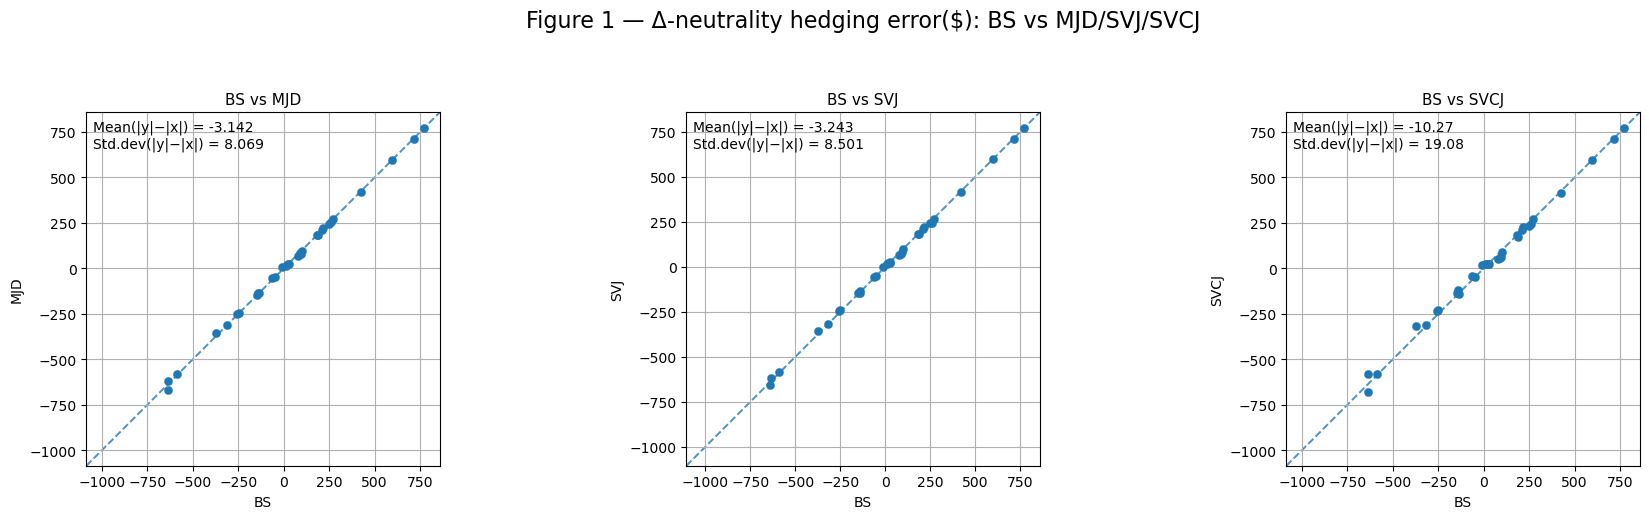

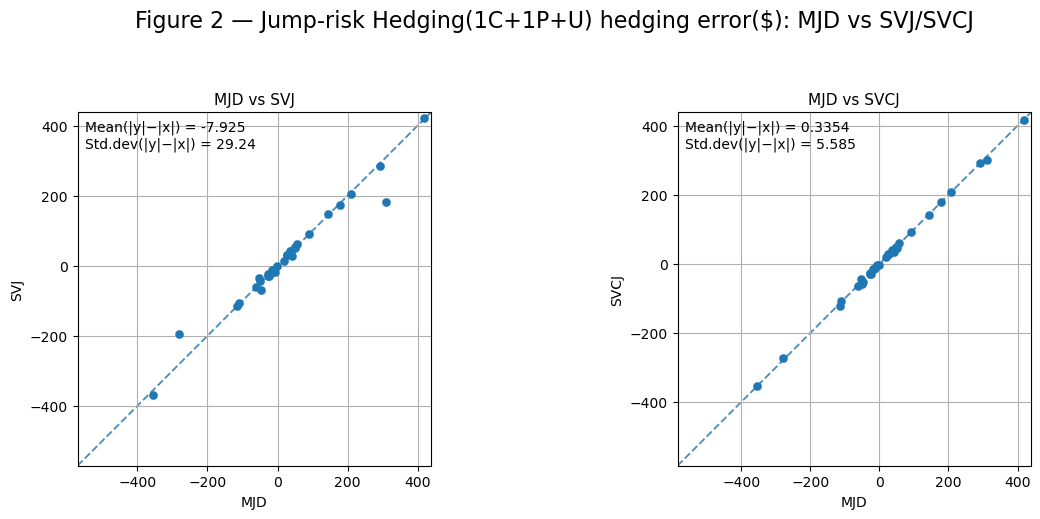

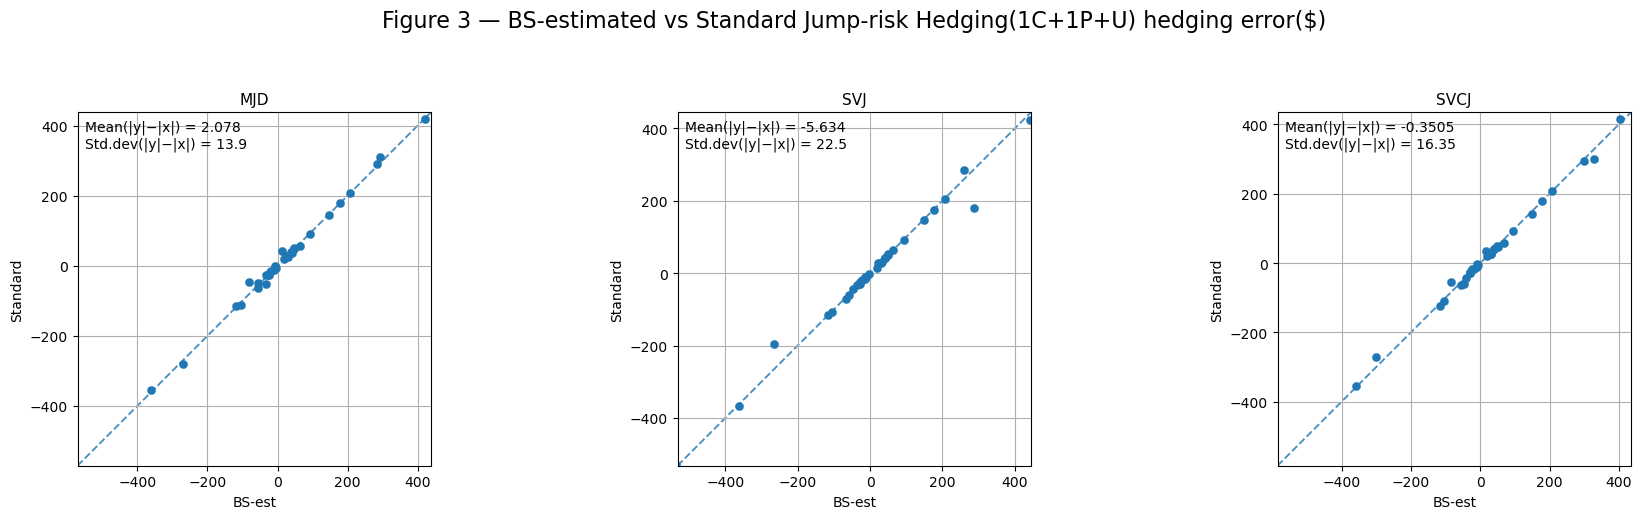

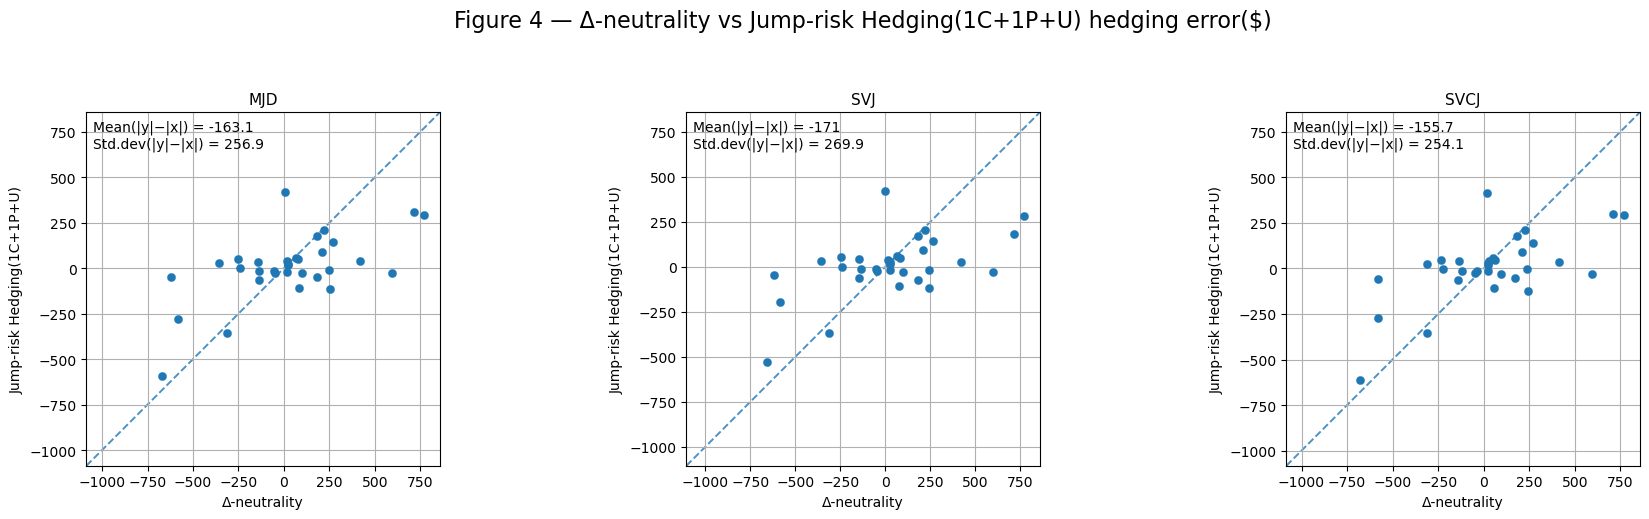

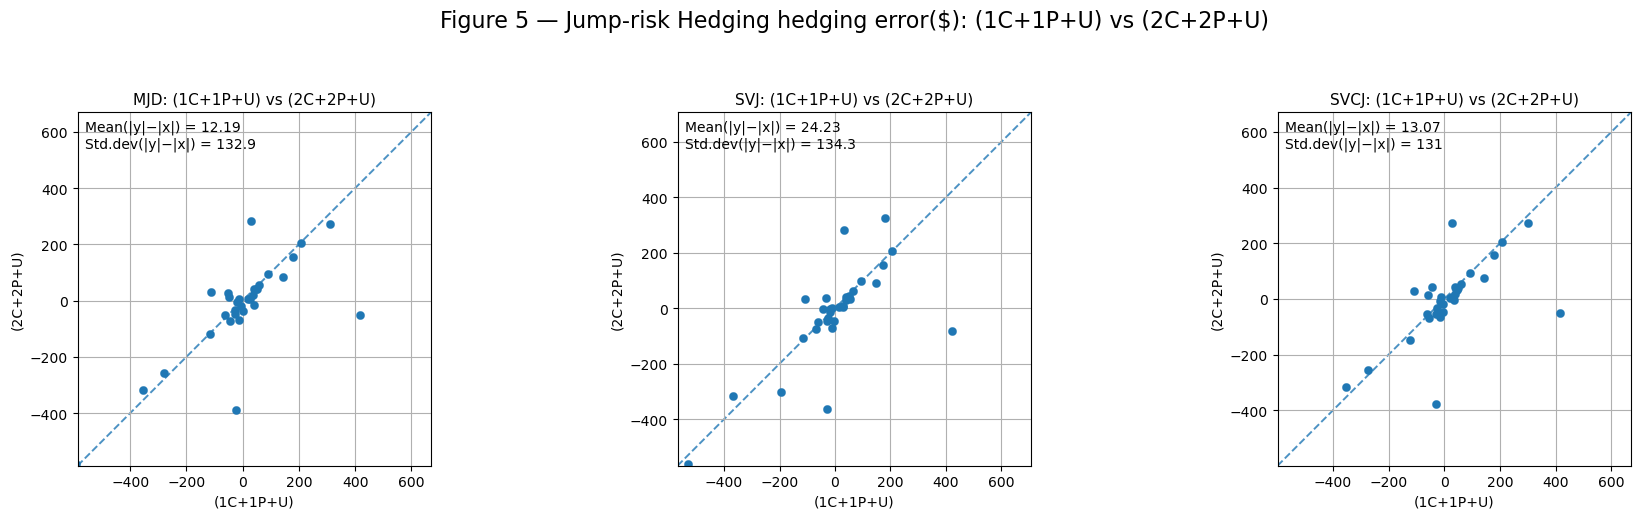

In [19]:
# Unpack your list for readability
data1 = (
    BS_greeks_hedge_error,      # 0  (Delta-neutrality; underlying only)
    MJD_greeks_hedge_error,     # 1
    SVJ_greeks_hedge_error,     # 2
    SVCJ_greeks_hedge_error,    # 3
    BS_MJD_jumpopt_error,       # 4  (1C+1P+underlying; BS-estimated vs true-model comparisons below)
    MJD_MJD_jumpopt_error,      # 5
    BS_SVJ_jumpopt_error,       # 6
    SVJ_SVJ_jumpopt_error,      # 7
    BS_SVCJ_jumpopt_error,      # 8
    SVCJ_SVCJ_jumpopt_error,    # 9
    BS_MJD_jumpopt_error_2,     # 10 (2C+2P+underlying)
    MJD_MJD_jumpopt_error_2,    # 11
    BS_SVJ_jumpopt_error_2,     # 12
    SVJ_SVJ_jumpopt_error_2,    # 13
    BS_SVCJ_jumpopt_error_2,    # 14
    SVCJ_SVCJ_jumpopt_error_2   # 15
)

# Optional: align by index if you pass pandas Series
try:
    import pandas as pd
except Exception:
    pd = None

# ---------- helpers ----------
def _to_xy(x, y):
    # Align on index if both are pandas Series; else coerce to same-length arrays
    if pd is not None and isinstance(x, pd.Series) and isinstance(y, pd.Series):
        xy = pd.concat([x.rename('x'), y.rename('y')], axis=1, join='inner').dropna()
        return xy['x'].to_numpy().ravel(), xy['y'].to_numpy().ravel()
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    n = min(len(x), len(y))
    return x[:n], y[:n]

def scatter_on_ax(ax, x, y, title, xlab, ylab, p_lo=1, p_hi=99, margin_frac=0.06, s=36):
    """One subplot: strong dots, long dashed 45° line, Mean/Std of (y-x)."""
    x, y = _to_xy(x, y)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    if x.size == 0:
        ax.text(0.5, 0.5, "No valid data", ha="center", va="center")
        ax.set_title(title); ax.set_xlabel(xlab); ax.set_ylabel(ylab); ax.grid(True)
        return

    # robust limits (set p_lo=0, p_hi=100 to disable clipping)
    xlo, xhi = np.nanpercentile(x, [p_lo, p_hi])
    ylo, yhi = np.nanpercentile(y, [p_lo, p_hi])
    lo = min(xlo, ylo); hi = max(xhi, yhi)
    span = hi - lo if np.isfinite(hi - lo) and (hi - lo) > 0 else 1.0
    pad = margin_frac * span
    xmin, xmax = lo - pad, hi + pad
    ymin, ymax = lo - pad, hi + pad

    ax.scatter(x, y, s=s, alpha=1.0, linewidths=0.2, zorder=2)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

    # long dashed slope-1 line across full axes
    L = min(ax.get_xlim()[0], ax.get_ylim()[0])
    H = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([L, H], [L, H], linestyle='--', linewidth=1.4, alpha=0.8, zorder=1)

    ax.set_title(title, fontsize=11)
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

    # annotate Mean/Std of difference
    diff = abs(y) - abs(x)
    mean_diff = float(np.mean(diff)) if diff.size else np.nan
    std_diff  = float(np.std(diff, ddof=1)) if diff.size > 1 else np.nan
    ax.text(0.02, 0.98, f"Mean(|y|−|x|) = {mean_diff:.4g}\nStd.dev(|y|−|x|) = {std_diff:.4g}",
            transform=ax.transAxes, ha='left', va='top')

# ---------- output dir ----------
OUTDIR = "plots_hedge_error_scatter"
Path(OUTDIR).mkdir(parents=True, exist_ok=True)

# ---------- Figure 1: Delta-neutrality (3 subplots) ----------
pairs1 = [
    (BS_greeks_hedge_error, MJD_greeks_hedge_error,
     "BS vs MJD", "BS", "MJD"),
    (BS_greeks_hedge_error, SVJ_greeks_hedge_error,
     "BS vs SVJ", "BS", "SVJ"),
    (BS_greeks_hedge_error, SVCJ_greeks_hedge_error,
     "BS vs SVCJ", "BS", "SVCJ"),
]
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
fig1.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,   # inches from edges
                                 wspace=0.10, hspace=0.10)  # between subplots (rel. to font size)
for ax, (x, y, t, xl, yl) in zip(axes1, pairs1):
    scatter_on_ax(ax, x, y, t, xl, yl)
fig1.suptitle("Figure 1 — Δ-neutrality hedging error($): BS vs MJD/SVJ/SVCJ", fontsize=16)
fig1.savefig(f"{OUTDIR}/fig1_delta_neutrality.png", dpi=220)
plt.show()

# ---------- Figure 2: JH (1C+1P+U) — model vs model (2 subplots) ----------
pairs2 = [
    (MJD_MJD_jumpopt_error, SVJ_SVJ_jumpopt_error,
     "MJD vs SVJ", "MJD", "SVJ"),
    (MJD_MJD_jumpopt_error, SVCJ_SVCJ_jumpopt_error,
     "MJD vs SVCJ", "MJD", "SVCJ"),
]
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5.6), constrained_layout=True)
fig2.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,   # inches from edges
                                 wspace=0.10, hspace=0.10)  # between subplots (rel. to font size)
for ax, (x, y, t, xl, yl) in zip(axes2, pairs2):
    scatter_on_ax(ax, x, y, t, xl, yl)
fig2.suptitle("Figure 2 — Jump-risk Hedging(1C+1P+U) hedging error($): MJD vs SVJ/SVCJ", fontsize=16)
fig2.savefig(f"{OUTDIR}/fig2_jh_model_vs_model.png", dpi=220)
plt.show()

# ---------- Figure 3: BS-estimated vs True JH (1C+1P+U) (3 subplots) ----------
pairs3 = [
    (BS_MJD_jumpopt_error, MJD_MJD_jumpopt_error,
     "MJD", "BS-est", "Standard"),
    (BS_SVJ_jumpopt_error, SVJ_SVJ_jumpopt_error,
     "SVJ", "BS-est", "Standard"),
    (BS_SVCJ_jumpopt_error, SVCJ_SVCJ_jumpopt_error,
     "SVCJ", "BS-est", "Standard"),
]
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
fig3.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,   # inches from edges
                                 wspace=0.10, hspace=0.10)  # between subplots (rel. to font size)
for ax, (x, y, t, xl, yl) in zip(axes3, pairs3):
    scatter_on_ax(ax, x, y, t, xl, yl)
fig3.suptitle("Figure 3 — BS-estimated vs Standard Jump-risk Hedging(1C+1P+U) hedging error($)", fontsize=16)
fig3.savefig(f"{OUTDIR}/fig3_bs_est_vs_true.png", dpi=220)
plt.show()

# ---------- Figure 4: Δ-neutral vs JH (1C+1P+U) per model (3 subplots) ----------
pairs4 = [
    (MJD_greeks_hedge_error, MJD_MJD_jumpopt_error,
     "MJD", "Δ-neutrality", "Jump-risk Hedging(1C+1P+U)"),
    (SVJ_greeks_hedge_error, SVJ_SVJ_jumpopt_error,
     "SVJ", "Δ-neutrality", "Jump-risk Hedging(1C+1P+U)"),
    (SVCJ_greeks_hedge_error, SVCJ_SVCJ_jumpopt_error,
     "SVCJ", "Δ-neutrality", "Jump-risk Hedging(1C+1P+U)"),
]
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
fig4.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,   # inches from edges
                                 wspace=0.10, hspace=0.10)  # between subplots (rel. to font size)
for ax, (x, y, t, xl, yl) in zip(axes4, pairs4):
    scatter_on_ax(ax, x, y, t, xl, yl)
fig4.suptitle("Figure 4 — Δ-neutrality vs Jump-risk Hedging(1C+1P+U) hedging error($)", fontsize=16)
fig4.savefig(f"{OUTDIR}/fig4_dn_vs_jh.png", dpi=220)
plt.show()

# ---------- Figure 5: JH capacity — (1C1P+U) vs (2C2P+U) (3 subplots) ----------
pairs5 = [
    (MJD_MJD_jumpopt_error, MJD_MJD_jumpopt_error_2,
     "MJD: (1C+1P+U) vs (2C+2P+U)", "(1C+1P+U)", "(2C+2P+U)"),
    (SVJ_SVJ_jumpopt_error, SVJ_SVJ_jumpopt_error_2,
     "SVJ: (1C+1P+U) vs (2C+2P+U)", "(1C+1P+U)", "(2C+2P+U)"),
    (SVCJ_SVCJ_jumpopt_error, SVCJ_SVCJ_jumpopt_error_2,
     "SVCJ: (1C+1P+U) vs (2C+2P+U)", "(1C+1P+U)", "(2C+2P+U)"),
]
fig5, axes5 = plt.subplots(1, 3, figsize=(18, 5.6),constrained_layout=True)
fig5.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,   # inches from edges
                                 wspace=0.10, hspace=0.10)  # between subplots (rel. to font size)
for ax, (x, y, t, xl, yl) in zip(axes5, pairs5):
    scatter_on_ax(ax, x, y, t, xl, yl)
fig5.suptitle("Figure 5 — Jump-risk Hedging hedging error($): (1C+1P+U) vs (2C+2P+U)", fontsize=16)
fig5.savefig(f"{OUTDIR}/fig5_capacity.png", dpi=220)
plt.show()

## Scatter Plot Analysis of Runtime (per Rebalance Solve)

This section visualizes and compares the **computational time per rebalance** across strategies and model setups.  
Each subplot shows a pairwise scatter of runtimes (in seconds) with a 45° dashed reference line.

**How to read the plots**
- Points near the diagonal → comparable runtime between the two methods.
- Points **below** the diagonal (y < x) → the method on the y-axis is **faster**.
- The annotation in each subplot reports **Mean(y−x)** and **Std(y−x)** for the runtime differences.

**Timing methodology**
- For each rebalance \(t_i\):  
  **start timer → compute hedging weights → stop timer**, excluding any plotting or I/O.  
  This isolates **solver/model computation** (Greeks, objective assembly, numerical integration) from unrelated overheads.

---

### Figure 1 — Δ-neutrality runtime across models
**What’s compared:** BS vs MJD/SVJ/SVCJ (underlying-only Δ-neutral hedges).  
**Question:** Does adding jump-diffusion or stochastic volatility **materially increase** solve time relative to BS?

---

### Figure 2 — Jump-risk Hedging runtime (1C+1P+Underlying), model vs model
**What’s compared:** MJD vs SVJ and MJD vs SVCJ for the **1C+1P+U** hedge.  
**Question:** For a fixed hedge set, which jump/stoch-vol specification is **computationally lighter**?

---

### Figure 3 — BS-estimated vs Standard Jump-risk Hedging runtime (1C+1P+Underlying)
**What’s compared:** BS-estimated vs model-consistent (Standard) hedging for MJD/SVJ/SVCJ.  
**Question:** If we **estimate hedge ratios with BS** instead of the full model, do we gain a **runtime advantage**?

---

### Figure 4 — Δ-neutrality vs Jump-risk Hedging runtime per model
**What’s compared:** For each model (MJD/SVJ/SVCJ), Δ-neutral (underlying-only) vs 1C+1P+U jump-risk hedging.  
**Question:** What is the **incremental cost** of moving from Δ-neutral to jump-aware optimization?

---

### Figure 5 — Capacity scaling: (1C+1P+U) vs (2C+2P+U)
**What’s compared:** Runtime with **one call + one put** vs **two calls + two puts** (plus underlying) for each model.  
**Question:** How does the solver **scale with more hedge instruments**? Do we observe near-linear, super-linear, or mild growth?

---

### Practical interpretation
- **Model complexity cost:** SVCJ typically involves **heavier Fourier/CF evaluations** than BS; MJD lies in between.  
- **Approximation payoff:** If performance (hedging error) is similar, a **BS-estimated** approach may justify itself by **lower latency**.  
- **Scalability:** Moving from **(1C+1P+U)** to **(2C+2P+U)** increases decision dimension and Greek/Jacobian assembly cost; the scatter shows how much.

**Caveats**
- Runtimes can be sensitive to **solver tolerances**, **initial guesses** (warm-starts), and **hardware**.  
- Keep the **same rebalancing grid, quotes, and constraints** across comparisons for fairness.
""")))

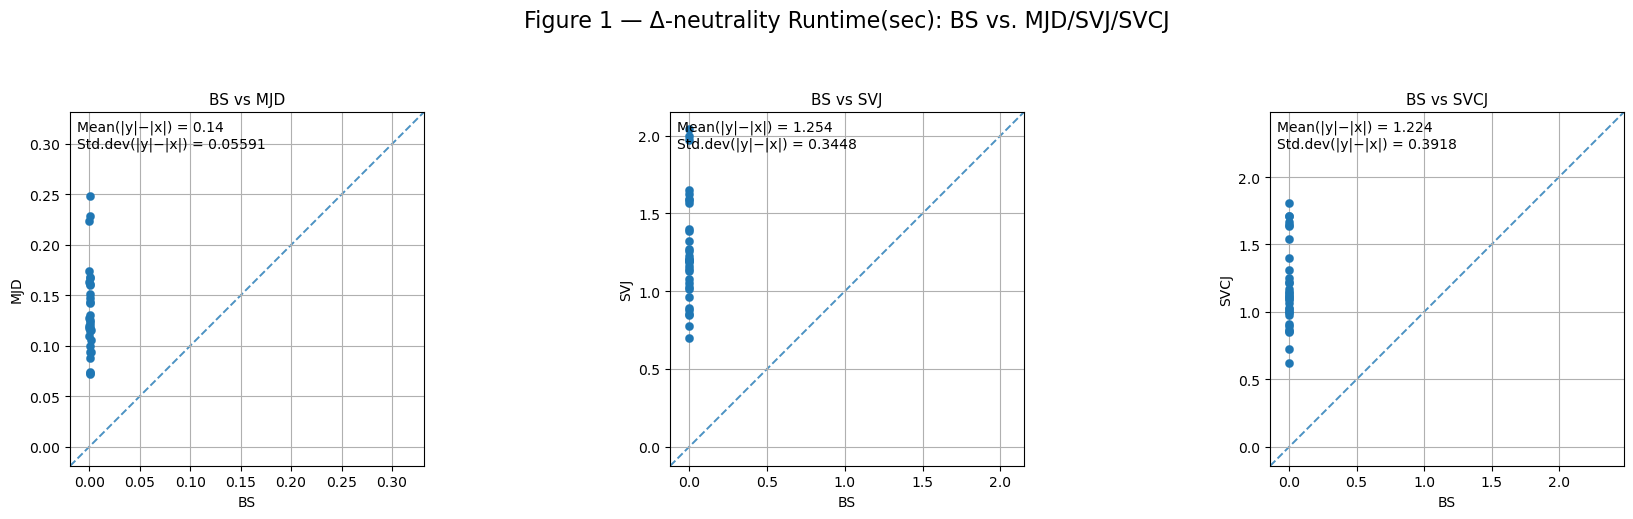

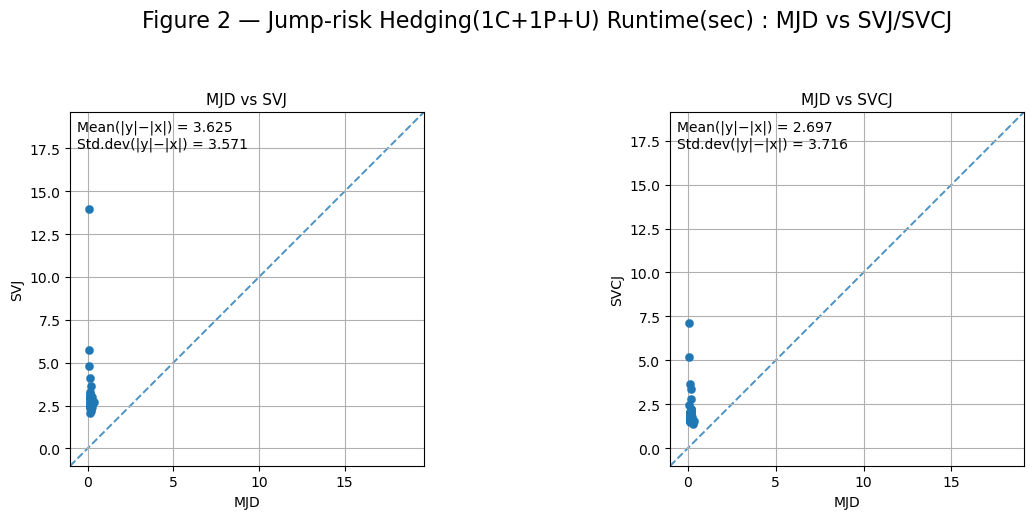

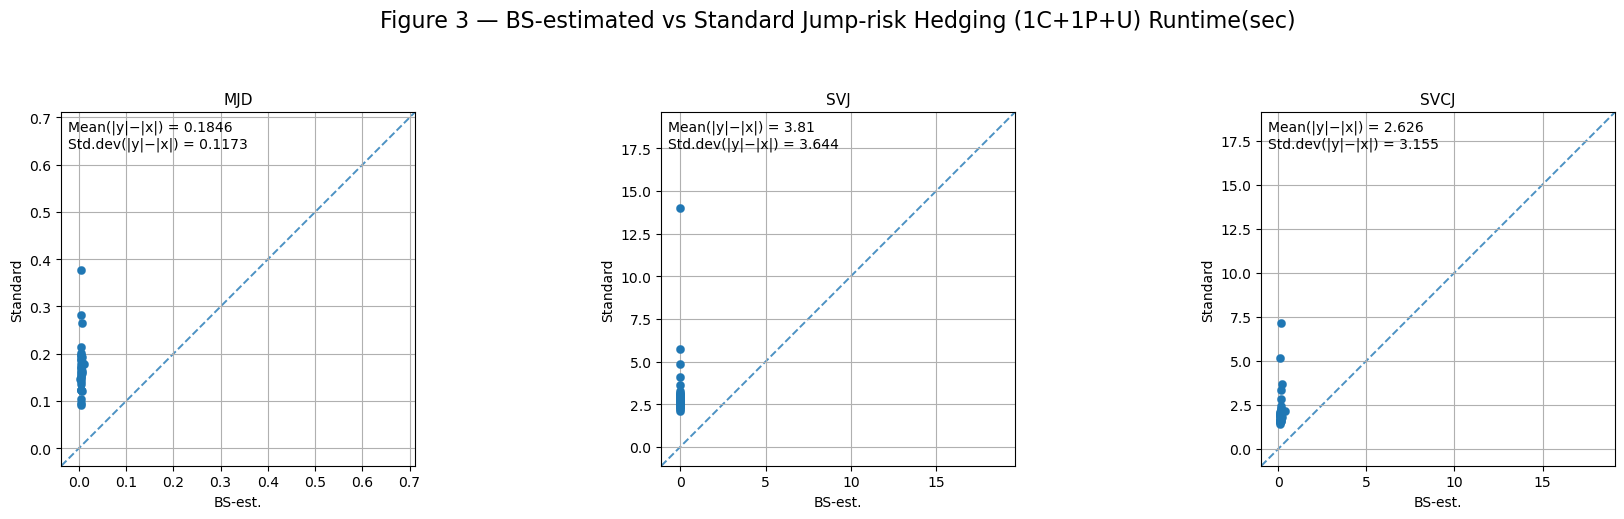

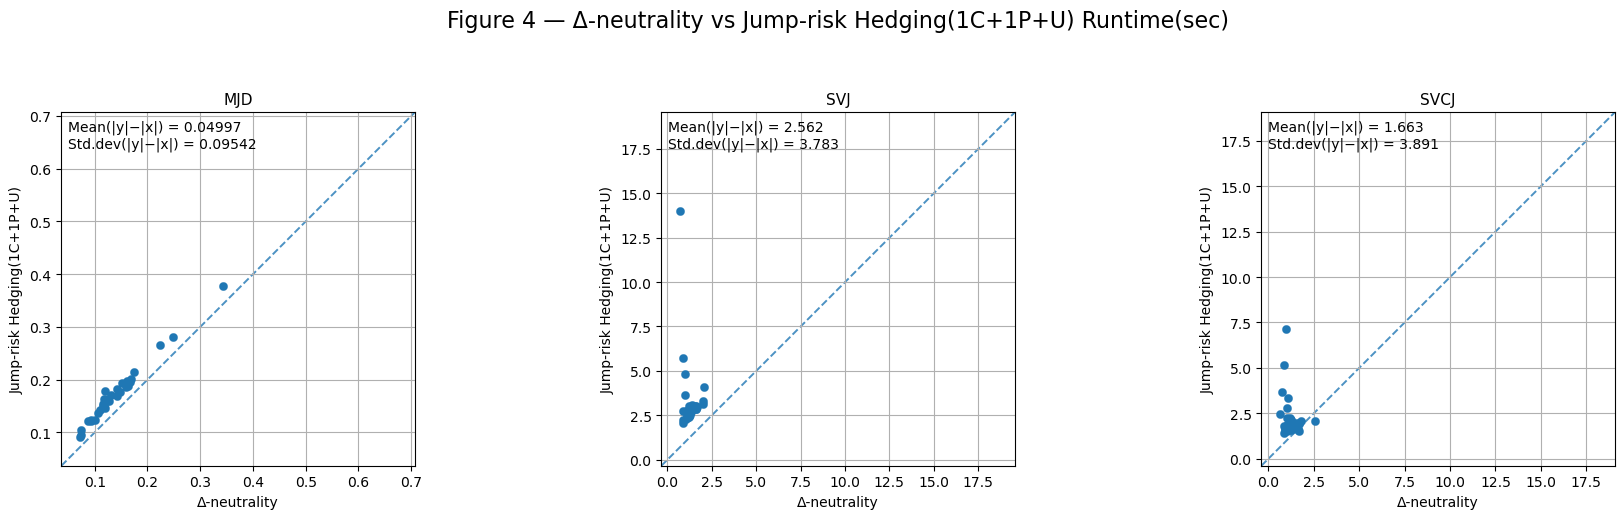

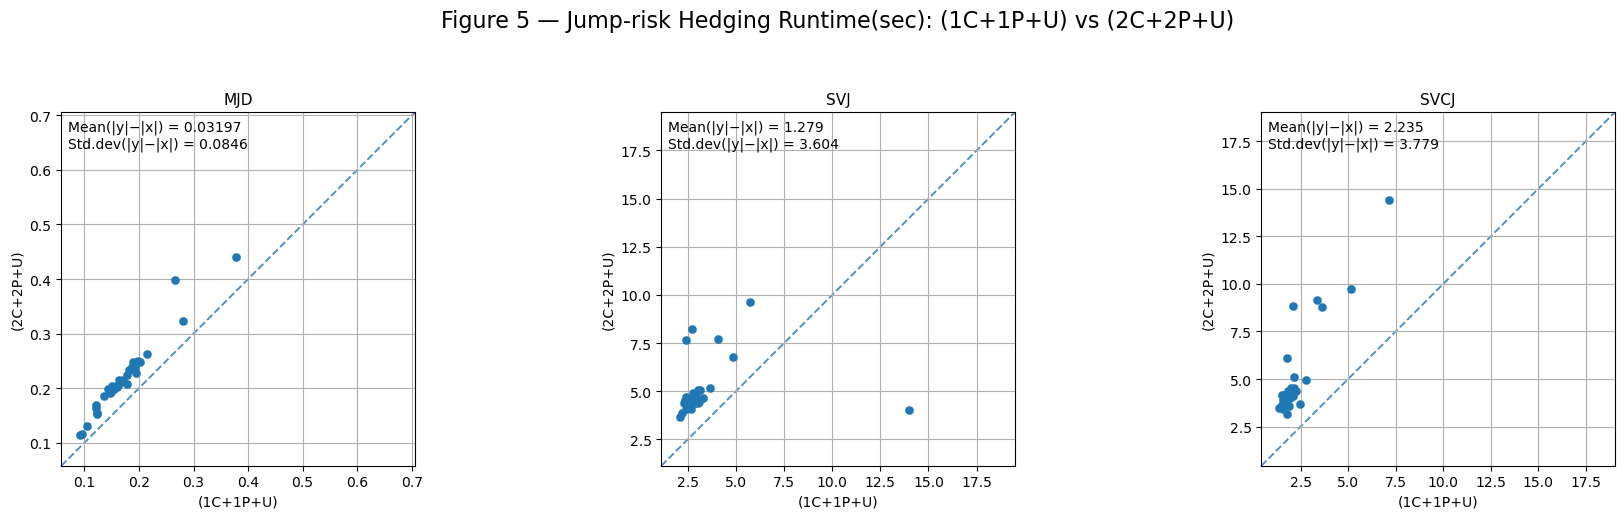

In [20]:
# ensure output dir
OUTDIR = "plots_hedge_time_scatter"
Path(OUTDIR).mkdir(parents=True, exist_ok=True)

# ------------- Figure 1: Δ-neutral runtime (3 subplots) -------------
pairs_t1 = [
    (BS_greeks_hedge_time, MJD_greeks_hedge_time,
     "BS vs MJD", "BS", "MJD"),
    (BS_greeks_hedge_time, SVJ_greeks_hedge_time,
     "BS vs SVJ", "BS", "SVJ"),
    (BS_greeks_hedge_time, SVCJ_greeks_hedge_time,
     "BS vs SVCJ", "BS", "SVCJ"),
]
figt1, ax1 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
figt1.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,
                                  wspace=0.10, hspace=0.10)  # between subplots (rel. to font size))
for ax, (x, y, t, xl, yl) in zip(ax1, pairs_t1):
    scatter_on_ax(ax, x, y, t, xl, yl)
figt1.suptitle("Figure 1 — Δ-neutrality Runtime(sec): BS vs. MJD/SVJ/SVCJ", fontsize=16)
figt1.savefig(f"{OUTDIR}/fig1_delta_neutral_runtime.png", dpi=220)
plt.show()

# ------------- Figure 2: JH runtime (1C+1P+U), model vs model (2) -------------
pairs_t2 = [
    (MJD_MJD_jumpopt_time, SVJ_SVJ_jumpopt_time,
     "MJD vs SVJ", "MJD", "SVJ"),
    (MJD_MJD_jumpopt_time, SVCJ_SVCJ_jumpopt_time,
     "MJD vs SVCJ", "MJD", "SVCJ"),
]
figt2, ax2 = plt.subplots(1, 2, figsize=(12, 5.6), constrained_layout=True)
figt2.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,
                                  wspace=0.10, hspace=0.10)  # between subplots (rel. to font size))
for ax, (x, y, t, xl, yl) in zip(ax2, pairs_t2):
    scatter_on_ax(ax, x, y, t, xl, yl)
figt2.suptitle("Figure 2 — Jump-risk Hedging(1C+1P+U) Runtime(sec) : MJD vs SVJ/SVCJ", fontsize=16)
figt2.savefig(f"{OUTDIR}/fig2_jh_model_vs_model_runtime.png", dpi=220)
plt.show()

# ------------- Figure 3: BS-estimated vs True JH runtime (3) -------------
pairs_t3 = [
    (BS_MJD_jumpopt_time, MJD_MJD_jumpopt_time,
     "MJD", "BS-est.", "Standard"),
    (BS_SVJ_jumpopt_time, SVJ_SVJ_jumpopt_time,
     "SVJ", "BS-est.", "Standard"),
    (BS_SVCJ_jumpopt_time, SVCJ_SVCJ_jumpopt_time,
     "SVCJ", "BS-est.", "Standard"),
]
figt3, ax3 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
figt3.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,
                                  wspace=0.10, hspace=0.10)  # between subplots (rel. to font size))
for ax, (x, y, t, xl, yl) in zip(ax3, pairs_t3):
    scatter_on_ax(ax, x, y, t, xl, yl)
figt3.suptitle("Figure 3 — BS-estimated vs Standard Jump-risk Hedging (1C+1P+U) Runtime(sec)", fontsize=16)
figt3.savefig(f"{OUTDIR}/fig3_bs_est_vs_true_runtime.png", dpi=220)
plt.show()

# ------------- Figure 4: Δ-neutral vs JH runtime per model (3) -------------
pairs_t4 = [
    (MJD_greeks_hedge_time, MJD_MJD_jumpopt_time,
     "MJD", "Δ-neutrality", "Jump-risk Hedging(1C+1P+U)"),
    (SVJ_greeks_hedge_time, SVJ_SVJ_jumpopt_time,
     "SVJ", "Δ-neutrality", "Jump-risk Hedging(1C+1P+U)"),
    (SVCJ_greeks_hedge_time, SVCJ_SVCJ_jumpopt_time,
     "SVCJ", "Δ-neutrality", "Jump-risk Hedging(1C+1P+U)"),
]
figt4, ax4 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
figt4.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,
                                  wspace=0.10, hspace=0.10)  # between subplots (rel. to font size))
for ax, (x, y, t, xl, yl) in zip(ax4, pairs_t4):
    scatter_on_ax(ax, x, y, t, xl, yl)
figt4.suptitle("Figure 4 — Δ-neutrality vs Jump-risk Hedging(1C+1P+U) Runtime(sec)", fontsize=16)
figt4.savefig(f"{OUTDIR}/fig4_dn_vs_jh_runtime.png", dpi=220)
plt.show()

# ------------- Figure 5: JH capacity runtime (1C1P+U) vs (2C2P+U) (3) -------------
pairs_t5 = [
    (MJD_MJD_jumpopt_time, MJD_MJD_jumpopt_time_2,
     "MJD", "(1C+1P+U)", "(2C+2P+U)"),
    (SVJ_SVJ_jumpopt_time, SVJ_SVJ_jumpopt_time_2,
     "SVJ", "(1C+1P+U)", "(2C+2P+U)"),
    (SVCJ_SVCJ_jumpopt_time, SVCJ_SVCJ_jumpopt_time_2,
     "SVCJ", "(1C+1P+U)", "(2C+2P+U)"),
]
figt5, ax5 = plt.subplots(1, 3, figsize=(18, 5.6), constrained_layout=True)
figt5.set_constrained_layout_pads(w_pad=0.3, h_pad=0.3,
                                  wspace=0.10, hspace=0.10)  # between subplots (rel. to font size))
for ax, (x, y, t, xl, yl) in zip(ax5, pairs_t5):
    scatter_on_ax(ax, x, y, t, xl, yl)
figt5.suptitle("Figure 5 — Jump-risk Hedging Runtime(sec): (1C+1P+U) vs (2C+2P+U)", fontsize=16)
figt5.savefig(f"{OUTDIR}/fig5_capacity_runtime.png", dpi=220)
plt.show()

## Dynamic Hedging Weights plot (Time Series)

These figures visualize the **time evolution of hedge positions** for each strategy.  
Each panel shows one instrument’s weight through time; rows correspond to strategies; columns correspond to instruments.

**How to read the grids**
- **Rows = strategies**  
  - *Δ-neutrality (underlying-only):*  
    BS Δ-neutrality · MJD Δ-neutrality · SVJ Δ-neutrality · SVCJ Δ-neutrality  
  - *Jump-risk hedging (1C+1P+Underlying):*  
    BS-estimated MJD · MJD · BS-estimated SVJ · SVJ · BS-estimated SVCJ · SVCJ  
  - *Jump-risk hedging (2C+2P+Underlying):*  
    same six variants but with two calls + two puts.
- **Columns = instruments**  
  - `Instrument 1`, `Instrument 2`, …, and the **last column is the Underlying** (noted in the title).
- **Line styling**  
  Dashed line with circular markers at each rebalance; per-panel box shows the **mean (μ)** and **std. dev. (σ)** of that weight across time.

**What’s being plotted**
- For a given strategy, at each rebalance date in `time_index`, we plot the **optimized position weights** \( \phi_{t,i} \) for each hedge instrument \( i \) (and the underlying).
- Data arrays are transposed to shape **(n_instruments, n_samples)** so each row in a model block yields one line per instrument.
- Y-limits are **shared by column** to enable direct comparison of the same instrument across strategies.

**Interpretation guide**
- **Stability & turnover:** smoother lines imply more stable hedges and lower turnover; choppiness → more trading and likely higher costs.  
- **Leverage / magnitude:** larger absolute weights indicate higher leverage or stronger compensation against risk factors (delta/jump/vol).  
- **Sign flips:** frequent crossings around zero can signal hedge direction changes (potentially costly with spreads).  
- **Capacity comparison:** compare 1C+1P+U vs 2C+2P+U. Extra degrees of freedom often reduce variance of the underlying weight (last column) and reallocate risk to options.  
- **Model misspecification:** differences between **BS-estimated** and **model-consistent** variants show how using BS Greeks/approximations changes the mix and stability of weights.

**Figure titles in this section**
- *Delta neutrality Hedging Weights — 5-day Rebalance*  
- *Jump-risk Hedging Weights (1C+1P+U) — 5-day Rebalance*  
- *Jump-risk Hedging Weights (2C+2P+U) — 5-day Rebalance*

**Practical notes**
- The last column is the **Underlying**; expect higher variance there under Δ-neutrality than in jump-hedging setups (where options absorb more risk).  
- All plots use the same rebalance grid and quote validity rule used elsewhere (two-sided or tiny one-sided spreads).  
- If markers clutter, set `marker_every` to 2 or 3 to thin the markers without changing the data.

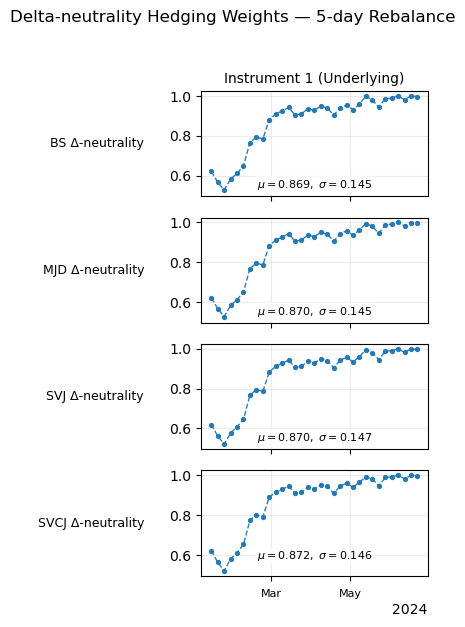

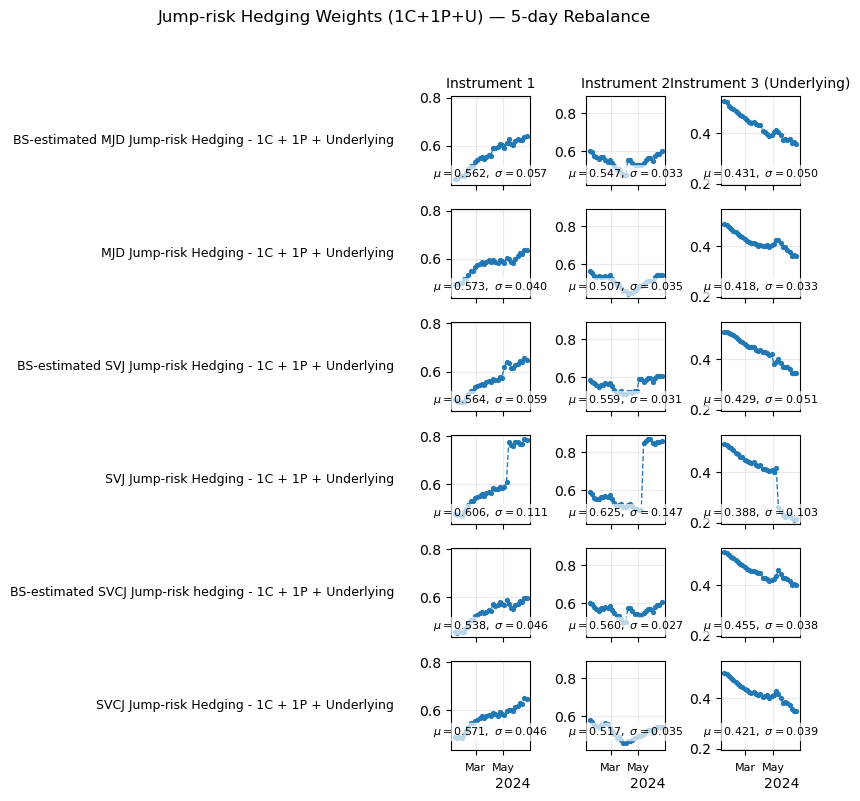

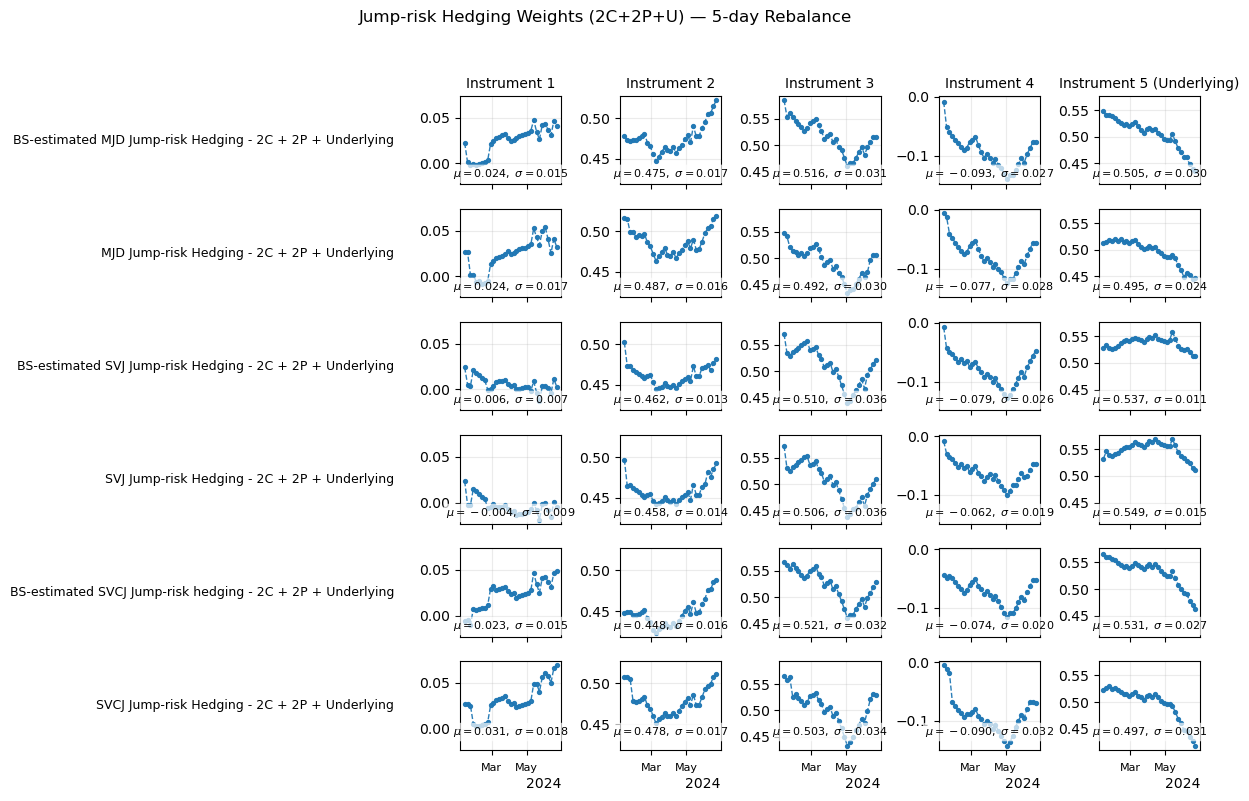

Saved figures:
  Dynamic_Hedging_Weights_plot\Delta_neutrality_Hedging_Weights_5_day_Rebalance.png
  Dynamic_Hedging_Weights_plot\Jump_risk_Hedging_Weights_1C1PU_5_day_Rebalance.png
  Dynamic_Hedging_Weights_plot\Jump_risk_Hedging_Weights_2C2PU_5_day_Rebalance.png


In [21]:
# ensure output dir
OUTDIR = "Dynamic_Hedging_Weights_plot"
Path(OUTDIR).mkdir(parents=True, exist_ok=True)
# Group data
greek_only_labels = [
    "BS Δ-neutrality",
    "MJD Δ-neutrality",
    "SVJ Δ-neutrality",
    "SVCJ Δ-neutrality",
]

jump_labels_1 = [
    "BS-estimated MJD Jump-risk Hedging - 1C + 1P + Underlying",
    "MJD Jump-risk Hedging - 1C + 1P + Underlying",
    "BS-estimated SVJ Jump-risk Hedging - 1C + 1P + Underlying",
    "SVJ Jump-risk Hedging - 1C + 1P + Underlying",
    "BS-estimated SVCJ Jump-risk hedging - 1C + 1P + Underlying",
    "SVCJ Jump-risk Hedging - 1C + 1P + Underlying"
]

jump_labels_2 = [
    "BS-estimated MJD Jump-risk Hedging - 2C + 2P + Underlying",
    "MJD Jump-risk Hedging - 2C + 2P + Underlying",
    "BS-estimated SVJ Jump-risk Hedging - 2C + 2P + Underlying",
    "SVJ Jump-risk Hedging - 2C + 2P + Underlying",
    "BS-estimated SVCJ Jump-risk hedging - 2C + 2P + Underlying",
    "SVCJ Jump-risk Hedging - 2C + 2P + Underlying"
]
greek_only_data = [
    BS_greeks_hedge_weights,
    MJD_greeks_hedge_weights,
    SVJ_greeks_hedge_weights,
    SVCJ_greeks_hedge_weights
]

jump_data_1 = [
    BS_MJD_jumpopt_weights,
    MJD_MJD_jumpopt_weights,
    BS_SVJ_jumpopt_weights,
    SVJ_SVJ_jumpopt_weights,
    BS_SVCJ_jumpopt_weights,
    SVCJ_SVCJ_jumpopt_weights
]

jump_data_2 = [
    BS_MJD_jumpopt_weights_2,
    MJD_MJD_jumpopt_weights_2,
    BS_SVJ_jumpopt_weights_2,
    SVJ_SVJ_jumpopt_weights_2,
    BS_SVCJ_jumpopt_weights_2,
    SVCJ_SVCJ_jumpopt_weights_2
]

# --- Convert to array and transpose to shape: (n_weights, n_samples)
greek_only_data = [np.array(m).T for m in greek_only_data]
jump_data_1     = [np.array(m).T for m in jump_data_1]
jump_data_2     = [np.array(m).T for m in jump_data_2]

time_index = times[:no_of_iters]

def small_multiples_grid(models_data, model_labels, time_index, title,
                         is_underlying_last=True, marker_every=None,
                         stats_decimals=3):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    # ---------- 1) Basic sanity & auto-alignment ----------
    if not models_data:
        raise ValueError("models_data is empty.")
    if len(models_data) != len(model_labels):
        raise ValueError("len(models_data) must match len(model_labels).")

    # Ensure arrays
    models_data = [np.asarray(A) for A in models_data]

    # If any array is (n_samples, n_instr), flip to (n_instr, n_samples)
    fixed = []
    for A in models_data:
        if A.ndim != 2:
            raise ValueError(f"Each model array must be 2D, got shape {A.shape}")
        # Heuristic: if rows >> cols, it’s probably (n_samples, n_instr)
        if A.shape[0] > A.shape[1]:
            A = A.T
        fixed.append(A)
    models_data = fixed

    # All models in this grid must have the same number of instruments (rows)
    n_instr_set = {A.shape[0] for A in models_data}
    if len(n_instr_set) != 1:
        raise ValueError(f"All model arrays in one grid must have the same #instruments (rows). Got: {n_instr_set}")
    n_instr = next(iter(n_instr_set))

    # Compute common sample length across all models and provided time_index
    n_time_idx = len(time_index)
    sample_lens = [A.shape[1] for A in models_data]
    common_n = min(n_time_idx, *sample_lens)
    if common_n == 0:
        raise ValueError(f"common_n == 0. time_index={n_time_idx}, model sample lens={sample_lens}")

    # Trim everything to common length (right-trim)
    time_index = np.asarray(time_index)[:common_n]
    models_data = [A[:, :common_n] for A in models_data]

    # ---------- 2) Figure & axes ----------
    n_models  = len(models_data)
    n_samples = common_n

    fig_h = 0.95 * n_models + 3.0
    fig_w = 2.00 * n_instr  + 2.2
    fig, axs = plt.subplots(
        n_models, n_instr,
        figsize=(fig_w, fig_h),
        sharex=True,
        sharey='col'
    )
    if n_models == 1: axs = np.atleast_2d(axs)
    if n_instr  == 1: axs = np.atleast_2d(axs).T

    # ---------- 3) Per-column y-lims across all models ----------
    for j in range(n_instr):
        vals = np.concatenate([M[j, :].ravel() for M in models_data if M.shape[1] > 0])
        vmin = np.nanmin(vals); vmax = np.nanmax(vals)
        if not np.isfinite(vmin) or not np.isfinite(vmax):
            vmin, vmax = -1.0, 1.0
        pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)
        for i in range(n_models):
            axs[i, j].set_ylim(vmin - pad, vmax + pad)

    # ---------- 4) X ticks as dates if possible ----------
    def setup_date(ax, show_labels):
        locator = mdates.AutoDateLocator(minticks=3, maxticks=4)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        ax.tick_params(axis='x', labelsize=8, pad=6)
        if not show_labels:
            ax.tick_params(axis='x', which='both', labelbottom=False)
        ax.grid(True, alpha=0.25)

    # ---------- 5) Column titles ----------
    for j in range(n_instr):
        suffix = " (Underlying)" if (is_underlying_last and j == n_instr - 1) else ""
        axs[0, j].set_title(f"Instrument {j+1}{suffix}", fontsize=10, pad=6)

    # ---------- 6) Draw lines + stats ----------
    for i, (M, lbl) in enumerate(zip(models_data, model_labels)):
        is_bottom = (i == n_models - 1)
        for j in range(n_instr):
            ax = axs[i, j]
            y = np.asarray(M[j, :]).ravel()
            ax.plot(
                time_index, y,
                linestyle='--', marker='o',
                markersize=2.8, linewidth=1.0, alpha=0.95,
                markevery=marker_every
            )
            setup_date(ax, show_labels=is_bottom)

            if j == 0:
                ax.set_ylabel(lbl, rotation=0, ha='right', va='center',
                              labelpad=18, fontsize=9)

            mu  = float(np.nanmean(y))
            sig = float(np.nanstd(y, ddof=1)) if y.size > 1 else float('nan')
            stats_y = 0.12 if is_bottom else 0.04
            ax.text(
                0.5, stats_y,
                rf"$\mu={mu:.{stats_decimals}f},\ \sigma={sig:.{stats_decimals}f}$",
                transform=ax.transAxes,
                ha='center', va='bottom', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                          edgecolor='none', alpha=0.7)
            )

    # ---------- 7) Layout & save ----------
    fig.subplots_adjust(hspace=0.70, bottom=0.08, top=0.90)
    fig.suptitle(title, y=0.965, fontsize=12)

    # Safe filename
    import os, re
    def slugify(text: str, repl: str = "_") -> str:
        text = re.sub(r"[–—−]+", "-", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = text.encode("ascii", "ignore").decode()
        text = re.sub(r"[^A-Za-z0-9\- _]+", "", text)
        text = re.sub(r"[\s\-]+", repl, text)
        text = re.sub(r"_+", "_", text)
        return text.strip("_")

    safe_name = slugify(title) + ".png"
    out_path  = os.path.join(OUTDIR, safe_name)

    import matplotlib.pyplot as plt
    plt.tight_layout(rect=[0, 0.05, 1, 0.94])
    fig.savefig(out_path, dpi=220, bbox_inches='tight')
    plt.show()
    return out_path


# ====== Render both grids ======
p1 = small_multiples_grid(
    models_data=greek_only_data,
    model_labels=greek_only_labels,
    time_index=time_index,
    title="Delta-neutrality Hedging Weights — 5-day Rebalance",
    is_underlying_last=True,
    marker_every=None,     # try 2 or 3 if too many markers
    stats_decimals=3
)

p2 = small_multiples_grid(
    models_data=jump_data_1,
    model_labels=jump_labels_1,
    time_index=time_index,
    title="Jump-risk Hedging Weights (1C+1P+U) — 5-day Rebalance",
    is_underlying_last=True,
    marker_every=None,
    stats_decimals=3
)

p3 = small_multiples_grid(
    models_data=jump_data_2,
    model_labels=jump_labels_2,
    time_index=time_index,
    title="Jump-risk Hedging Weights (2C+2P+U) — 5-day Rebalance",
    is_underlying_last=True,
    marker_every=None,
    stats_decimals=3
)

print("Saved figures:", p1, p2, p3, sep="\n  ")

## Paired t-Tests on 5-day Averaged Hedging Errors

This section statistically compares hedging strategies using **paired t-tests** on **5-day-aggregated absolute hedging errors**.  
The workflow mirrors Stata-style reports and adds a compact visual summary.

---

### What the helpers do

**5day series builder — `build_group_kday_series(...)`**
- **Input:** a *group* (list) of arrays, each either:
  - 2D: `(n_instruments, T)` → averaged across instruments to get a 1D series, then
  - 1D: `(T,)`            → used as-is.
- **Absolute errors:** if `use_absolute=True`, takes `abs(.)` **before** averaging (default in all tests).
- **Alignment:** trims all series to a common length `L` (smallest length or `align_len` if provided).  
  - `align="tail"` keeps the **last** `L` points (end-of-sample aligned).  
  - `align="head"` keeps the **first** `L` points (start aligned).
- **Output:** one k-day 1D series representing the **average across models** in the group (after instrument-average and trimming).

**Stata-like paired t-test — `paired_t_test_report(x, y, ...)`**
- Takes two **paired** series `x` and `y` (same length) and prints:
  - per-series **mean**, **Std.Err.**, **Std.Dev.**, and **95% CI**  
  - for the **difference** `d = x − y`: mean, Std.Err., Std.Dev., and 95% CI  
  - a left-tailed test report:  
    $$
      H_0:\ \mathbb{E}[d] = 0\quad\ \text{vs}\ \quad H_a:\ \mathbb{E}[d] < 0
    $$
    so **smaller is better for `x`** (since we test whether \(x\) has lower mean error than \(y\)).

**Pretty plot — `paired_t_test_plot(x, y, ...)`**
- Renders a fixed-width, monospace table of the same statistics with the test title and decisions at \(\alpha\in\{0.01, 0.05, 0.10\}\).
- Saved to `paired_t_tests/` when `savepath` is provided.

**Convenience wrapper — `run_paired_test(x_list, y_list, ...)`**
- Computes a common length \(L\) across both lists using `_common_len`.
- Builds weekly series for each list via `_series(...)` (which calls `build_group_kday_series` with `use_absolute=True`, `align="tail"`).
- Runs both the textual report and the plotted table.

---

### Why weekly absolute errors and pairing?

- **Absolute errors** focus on dispersion of hedging P&L misses and avoid sign-cancellation.  
- **Pairing** (same timestamps across strategies) controls for market state, giving **within-week** comparisons.  
- The paired t-test effectively tests whether the **mean difference** in weekly absolute errors is negative.

---

### How to read the outputs

- **Table (text and plot):**
  - Compare the **means** and **95% CIs** of each series and the **difference** (`x − y`).  
  - Key number: the **t-stat** and **Pr(T < t)** (left-tailed).  
    - If `Pr(T < t) < α`, we **Reject H0** → evidence that **x has lower mean error** than **y**.
- **Figure naming (saved under `paired_t_tests/`):**
  1. **Δ-neutrality comparisons:** MJD/SVJ/SVCJ vs BS.  
  2. **Jump-risk Hedging (1C+1P+U), model vs model:** SVJ vs MJD, SVCJ vs MJD.  
  3. **BS-estimated vs Standard Jump-risk Hedging (1C+1P+U):** per model (MJD/SVJ/SVCJ).  
  4. **Δ-neutrality vs Jump-risk Hedging (1C+1P+U):** per model.  
  5. **Capacity (2C+2P+U vs 1C+1P+U):** per model.

---

### Assumptions, caveats, and robustness

- **t-test assumptions:** paired differences $d_t = x_t - y_t$ are approximately **i.i.d. normal** with finite variance.  
  In practice, weekly hedge errors may exhibit mild autocorrelation/heavy tails.
- **Robustness suggestions (optional):**
  - Use **Wilcoxon signed-rank** as a nonparametric paired alternative.  
  - Report **effect size**: Cohen’s \(d = \overline{d}/s_d\).  
  - Try `align="head"` to check sensitivity to sample endpoints.  
  - Control for **multiple testing** (e.g., Holm–Bonferroni) if you treat all 11 tests jointly.
- **Interpretation:** Statistical significance complements the scatter/summary plots—prefer conclusions that are **consistent across tests** (Δ-neutrality vs JH, BS-estimated vs Standard, capacity scaling).

---

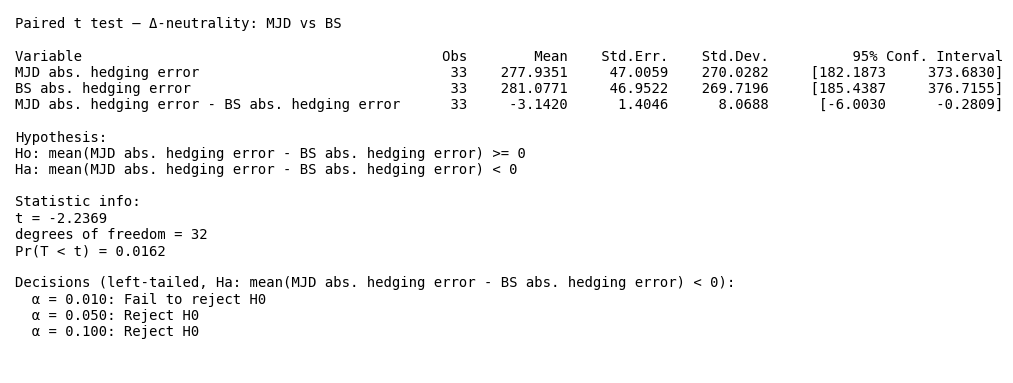

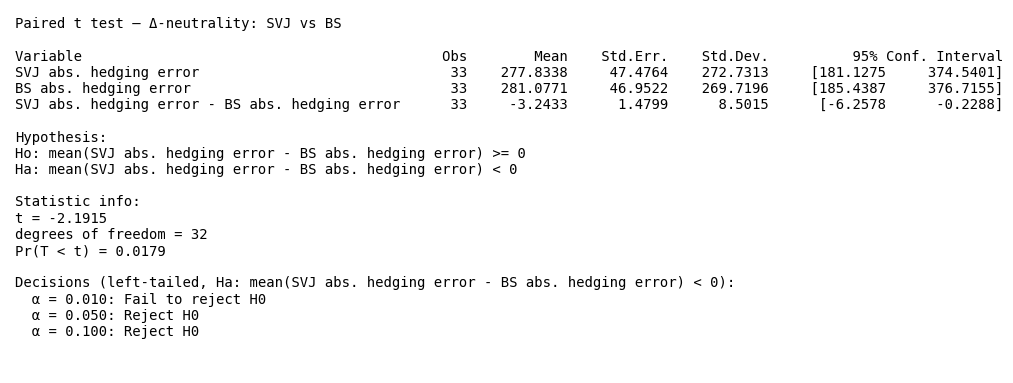

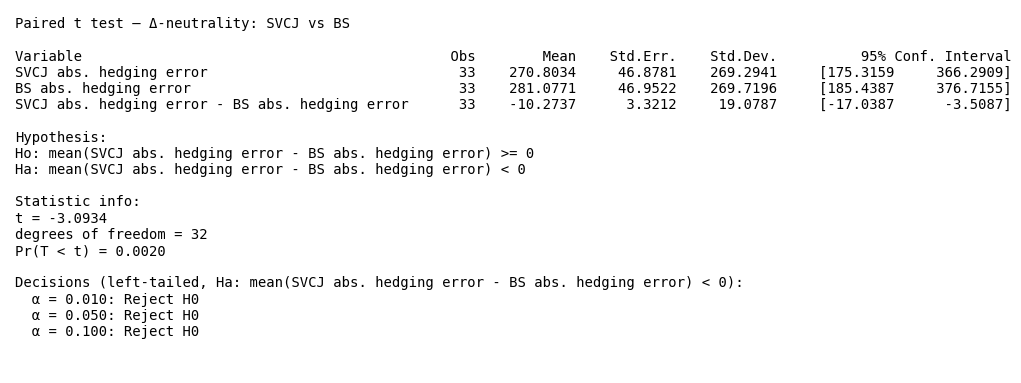

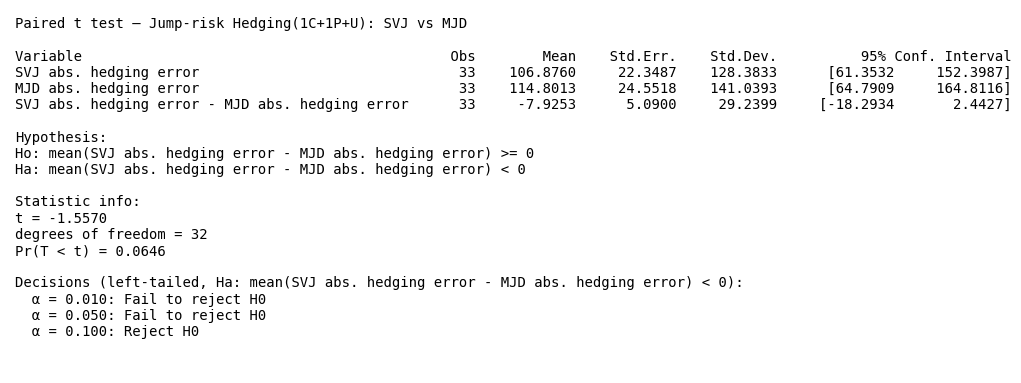

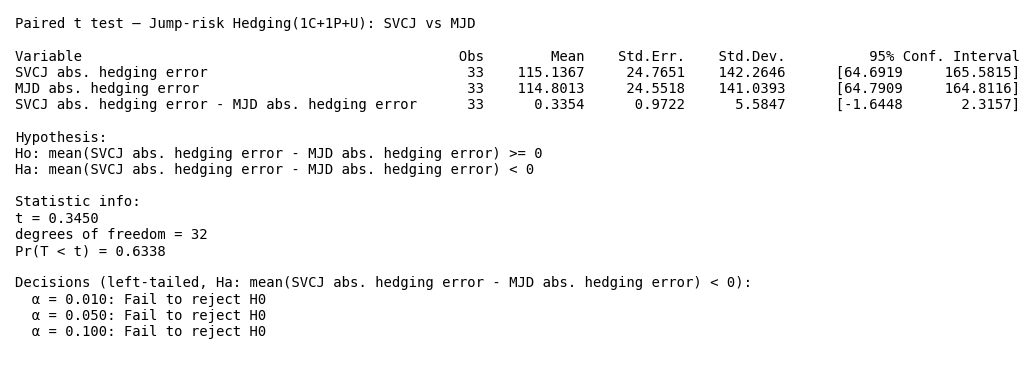

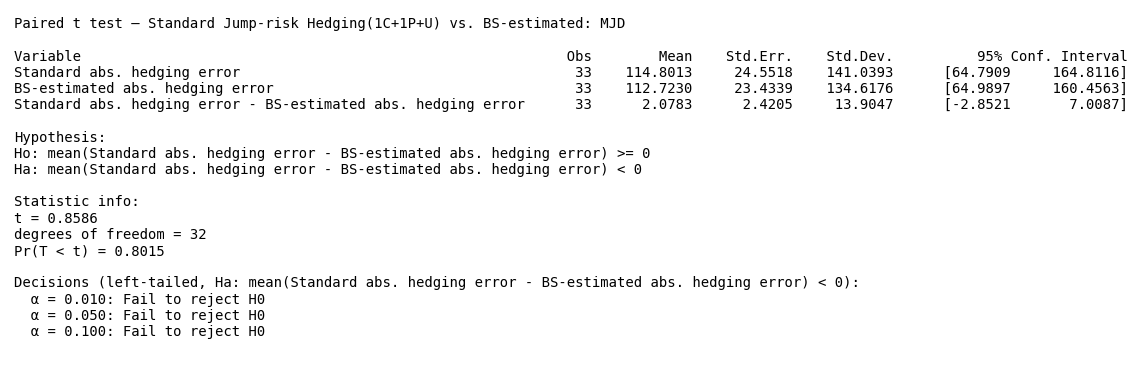

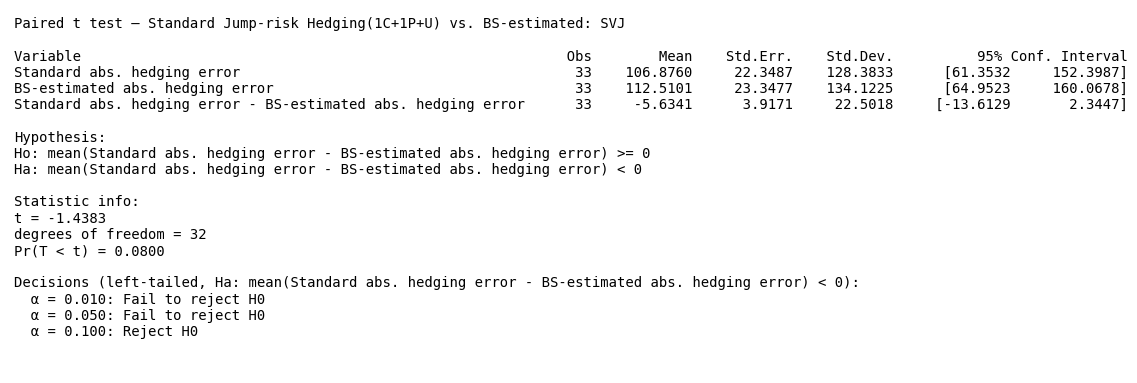

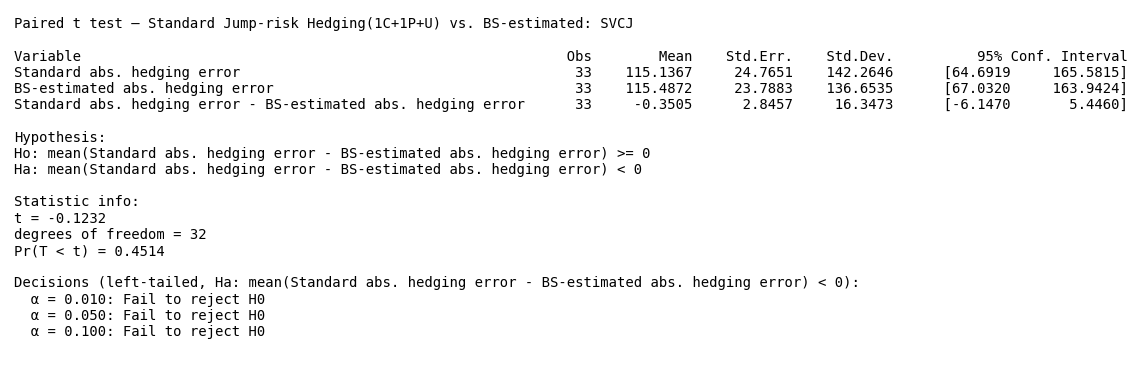

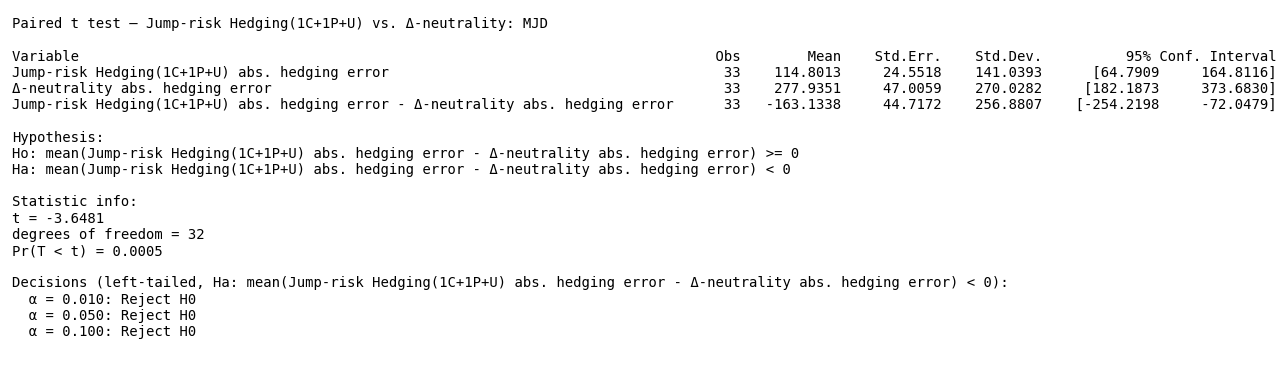

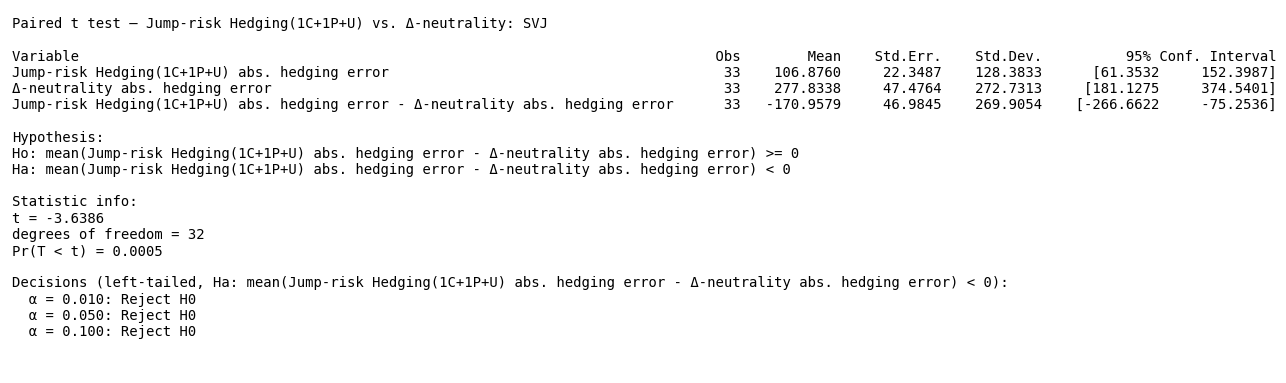

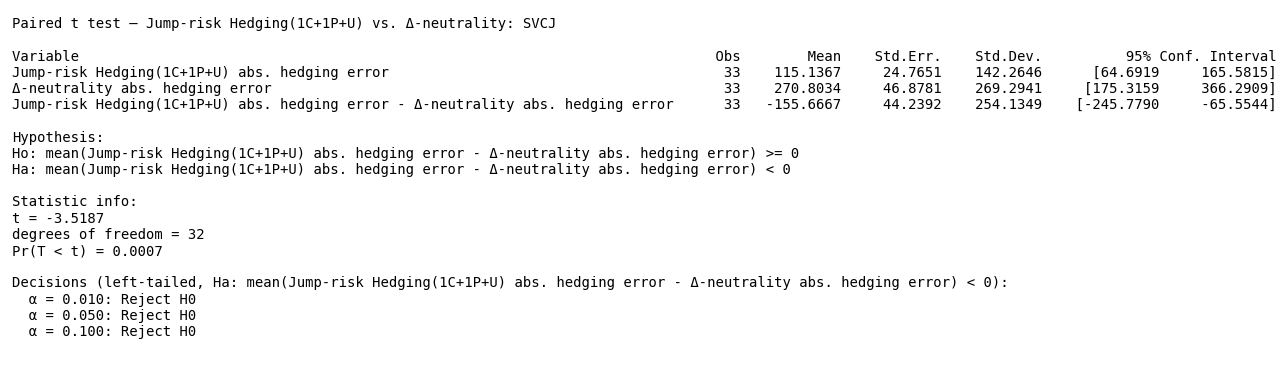

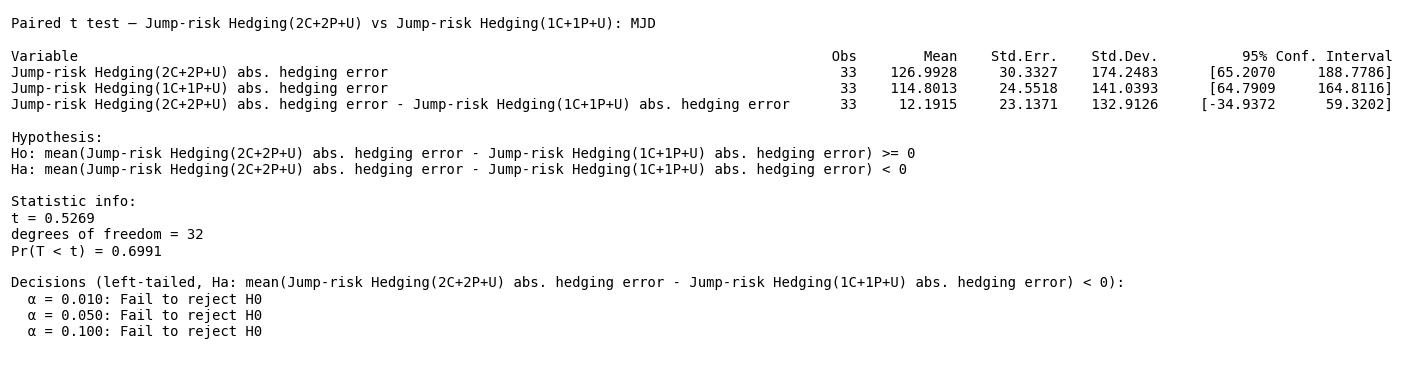

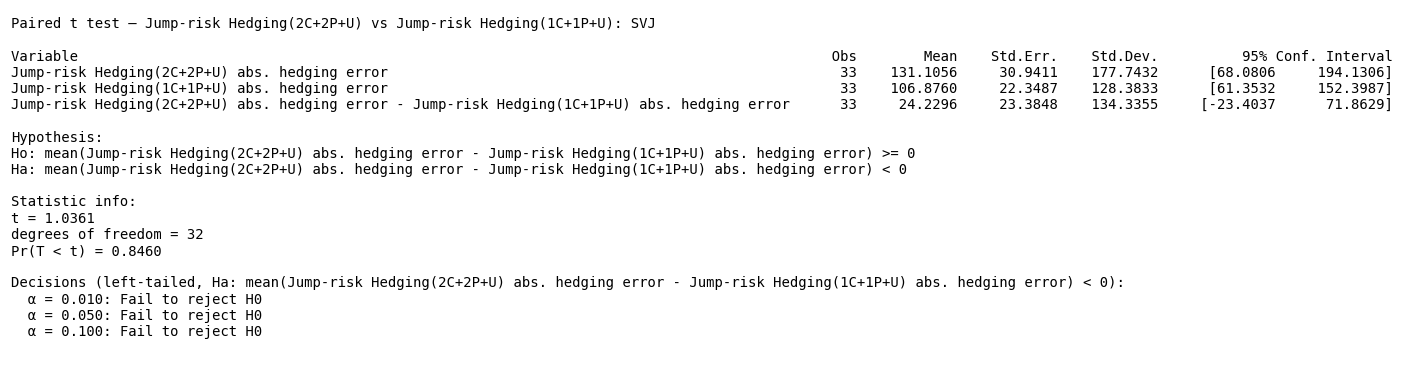

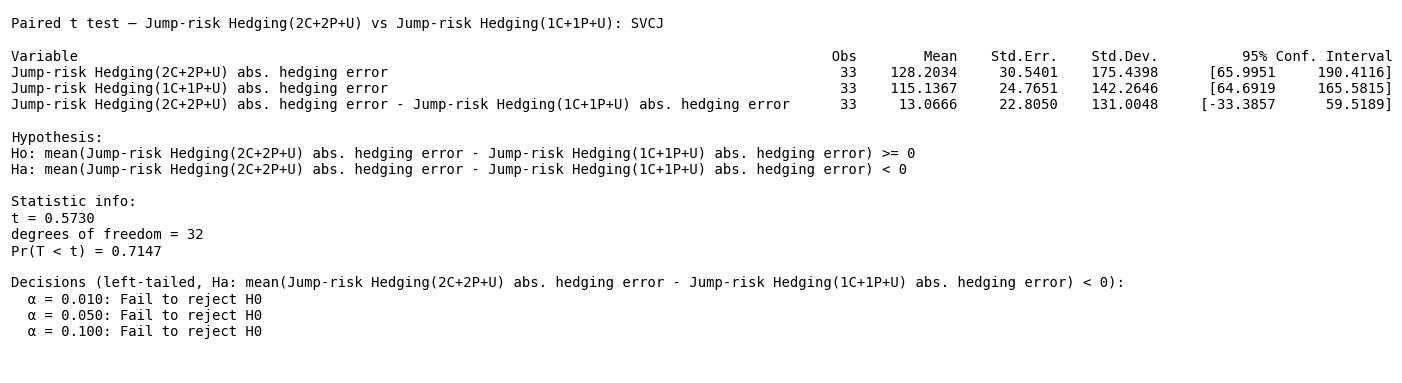

In [22]:
# --- 1) Collapse list-of-arrays -> one weekly series per group (avg across instruments, then across models) ---
def build_group_kday_series(group, use_absolute=True, align_len=None, align="tail"):
    """
    group: list of arrays, each either 1D (time,) or 2D (instruments, time)
    use_absolute: take absolute errors before averaging
    align_len: if provided, trim all series to this common length; otherwise infer min length within group
    align: "tail" keeps the last align_len points; "head" keeps the first align_len points
    returns: 1D numpy array (weekly series averaged across models)
    """
    series_list = []
    for arr in group:
        A = np.asarray(arr, dtype=float)
        if use_absolute:
            A = np.abs(A)
        if A.ndim == 2:
            s = np.nanmean(A, axis=0)  # avg across instruments -> 1D (time,)
        elif A.ndim == 1:
            s = A
        else:
            raise ValueError("Each element must be 1D (time,) or 2D (instruments, time).")
        series_list.append(s.ravel())

    # align lengths within this group
    L = min(len(s) for s in series_list) if align_len is None else int(align_len)
    if align == "tail":
        mat = np.vstack([s[-L:] for s in series_list])
    else:
        mat = np.vstack([s[:L]  for s in series_list])

    # average across models
    return np.nanmean(mat, axis=0)  # shape (L,)


# --- 2) Stata-like paired t-test report for two paired 1D series (x - y) ---
def paired_t_test_report(x, y, name1="Group 1", name2="Group 2",
                        ci_alpha=0.05, decimals=6, alphas=(0.01, 0.05, 0.10)):
    """
    Prints a Stata-style paired t test table and decisions for multiple alpha levels.
    x, y: equal-length 1D arrays of paired observations (e.g., weekly averages)
    """
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    if x.size != y.size:
        raise ValueError("x and y must have the same length (paired).")

    # drop pairs with NaN in either series
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = x.size
    if n < 2:
        raise ValueError("Need at least two paired observations after NaN filtering.")
    df = n - 1

    def m_sesd(a):
        m = np.mean(a)
        sd = np.std(a, ddof=1)
        se = sd / np.sqrt(n)
        return m, se, sd

    mx, sex, sdx = m_sesd(x)
    my, sey, sdy = m_sesd(y)
    d = x - y
    md, sed, sdd = m_sesd(d)

    # two-sided CI for means
    tcrit = stats.t.ppf(1 - ci_alpha/2, df)
    cix = (mx - tcrit*sex, mx + tcrit*sex)
    ciy = (my - tcrit*sey, my + tcrit*sey)
    cid = (md - tcrit*sed, md + tcrit*sed)

    # t and p-values
    tstat = md / sed if sed > 0 else np.nan
    p_less    = stats.t.cdf(tstat, df)          # Ha: mean(diff) < 0
    p_greater = 1 - p_less                      # Ha: mean(diff) > 0
    p_two     = 2 * min(p_less, p_greater)      # Ha: mean(diff) != 0

    fmt = lambda v: f"{v:.{decimals}f}"

    # ---- print Stata-like table ----
    print("Paired t test\n")
    header = f"{'Variable':<15}{'Obs':>6}{'Mean':>14}{'Std. Err.':>14}{'Std. Dev.':>14}{'[95% Conf. Interval]':>26}"
    print(header)
    print(f"{name1:<15}{n:>6}{fmt(mx):>14}{fmt(sex):>14}{fmt(sdx):>14}{f'{fmt(cix[0])}  {fmt(cix[1])}':>26}")
    print(f"{name2:<15}{n:>6}{fmt(my):>14}{fmt(sey):>14}{fmt(sdy):>14}{f'{fmt(ciy[0])}  {fmt(ciy[1])}':>26}")
    print(f"{'diff':<15}{n:>6}{fmt(md):>14}{fmt(sed):>14}{fmt(sdd):>14}{f'{fmt(cid[0])}  {fmt(cid[1])}':>26}\n")

    print(f"mean(diff) >= mean({name1} - {name2})\t t = {fmt(tstat)}")
    print(f"Ho: mean(diff) = 0\t degrees of freedom = {df}\n")
    print(f"Ha: mean(diff) <  0    Pr(T < t)     = {fmt(p_less)}")
    # print(f"Ha: mean(diff) != 0    Pr(|T| > |t|) = {fmt(p_two)}")
    # print(f"Ha: mean(diff) >  0    Pr(T > t)     = {fmt(p_greater)}")

    # decisions at multiple alphas (use left-tailed by default; change if you care about other tails)
    if alphas:
        print("\nDecisions (left-tailed, Ha: mean(diff) < 0):")
        for a in sorted(set(alphas)):
            decision = "Reject H0" if p_less < a else "Fail to reject H0"
            print(f"  α = {a:.3f}: {decision}")

def paired_t_test_plot(
    x, y, name1="Jump-risk", name2="Delta neutrality",
    ci_alpha=0.05, decimals=4,
    title="Paired t test", figsize=(9.2, 4.2), savepath=None
):
    # -------- stats --------
    x, y = np.asarray(x, float).ravel(), np.asarray(y, float).ravel()
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = len(x);  assert n >= 2, "Need at least 2 paired obs."
    df = n - 1

    def m_sesd(a):
        m  = np.mean(a); sd = np.std(a, ddof=1); se = sd/np.sqrt(n)
        return m, se, sd

    mx, sex, sdx = m_sesd(x)
    my, sey, sdy = m_sesd(y)
    d = x - y
    md, sed, sdd = m_sesd(d)

    tcrit = stats.t.ppf(1 - ci_alpha/2, df)
    cix = (mx - tcrit*sex, mx + tcrit*sex)
    ciy = (my - tcrit*sey, my + tcrit*sey)
    cid = (md - tcrit*sed, md + tcrit*sed)

    tstat  = md/sed if sed > 0 else np.nan
    p_less = stats.t.cdf(tstat, df)

    f = lambda v: f"{v:.{decimals}f}"

    # -------- dynamic, fixed-width columns --------
    var_w  = max(len("Variable"),
                 len(name1), len(name2),
                 len(f"{name1} - {name2}")) + 2   # pad a bit
    obs_w  = 6
    num_w  = 12
    ci_w   = 28     # whole CI column width
    hi_w   = 11     # width for the upper bound inside the brackets

    header_fmt = f"{{:<{var_w}}}{{:>{obs_w}}}{{:>{num_w}}}{{:>{num_w}}}{{:>{num_w}}}{{:>{ci_w}}}"
    row_fmt    = f"{{:<{var_w}}}{{:>{obs_w}}}{{:>{num_w}}}{{:>{num_w}}}{{:>{num_w}}}{{:>{ci_w}}}"

    def ci_cell(lo, hi):
        # bracket tight to first number; align the second
        return f"[{f(lo)}  {f(hi):>{hi_w}}]"

    lines = []
    lines.append(f"{title}\n")
    lines.append(header_fmt.format("Variable", "Obs", "Mean", "Std.Err.", "Std.Dev.", "95% Conf. Interval"))
    lines.append(row_fmt.format(name1, n, f(mx), f(sex), f(sdx), ci_cell(*cix)))
    lines.append(row_fmt.format(name2, n, f(my), f(sey), f(sdy), ci_cell(*ciy)))
    lines.append(row_fmt.format(f"{name1} - {name2}", n, f(md), f(sed), f(sdd), ci_cell(*cid)))
    lines.append("")

    lines.append("Hypothesis:")
    lines.append(f"Ho: mean({name1} - {name2}) >= 0")
    lines.append(f"Ha: mean({name1} - {name2}) < 0\n")

    lines.append("Statistic info:")
    lines.append(f"t = {f(tstat)}")
    lines.append(f"degrees of freedom = {df}")
    lines.append(f"Pr(T < t) = {f(p_less)}\n")

    lines.append(f"Decisions (left-tailed, Ha: mean({name1} - {name2}) < 0):")
    for a in (0.01, 0.05, 0.10):
        lines.append(f"  α = {a:.3f}: {'Reject H0' if p_less < a else 'Fail to reject H0'}")

    text = "\n".join(lines)

    # -------- render with a real monospace font --------
    mpl.rcParams['font.family'] = 'DejaVu Sans Mono'  # ensures fixed-width rendering
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    ax.text(0.01, 0.98, text, ha="left", va="top",
            fontsize=10, linespacing=1.2)
    plt.tight_layout(pad=0.6)
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
# ------------------------------
# helpers
# ------------------------------
def _time_len(a):
    A = np.asarray(a)
    return A.size if A.ndim == 1 else A.shape[-1]

def _common_len(list1, list2):
    return min(min(_time_len(a) for a in list1),
               min(_time_len(a) for a in list2))

def _series(lst, L):
    # average across instruments (if 2D) then across the list, abs errors
    return build_group_kday_series(lst, use_absolute=True, align_len=L, align="tail")

def run_paired_test(x_list, y_list, name1, name2, title, savepath=None,
                    ci_alpha=0.05, decimals=4, alphas=(0.01, 0.05, 0.10)):
    L = _common_len(x_list, y_list)
    x = _series(x_list, L)
    y = _series(y_list, L)
    # paired_t_test_report(x, y, name1=name1, name2=name2,
    #                       ci_alpha=ci_alpha, decimals=decimals, alphas=alphas)
    paired_t_test_plot(x, y, name1=name1, name2=name2,
                       ci_alpha=ci_alpha, decimals=decimals,
                       title=title, figsize=(8.5, 4.0), savepath=savepath)

# ------------------------------
# output dir
# ------------------------------
TTOUT = Path("paired_t_tests")
TTOUT.mkdir(parents=True, exist_ok=True)

# ============================================================
# Figure 1 — Δ-neutrality comparisons (3)
# ============================================================
run_paired_test(
    x_list=[MJD_greeks_hedge_error],
    y_list=[BS_greeks_hedge_error],
    name1="MJD abs. hedging error", name2="BS abs. hedging error",
    title="Paired t test — Δ-neutrality: MJD vs BS",
    savepath=TTOUT / "fig1_dn_bs_vs_mjd.png"
)

run_paired_test(
    x_list=[SVJ_greeks_hedge_error],
    y_list=[BS_greeks_hedge_error],
    name1="SVJ abs. hedging error", name2="BS abs. hedging error",
    title="Paired t test — Δ-neutrality: SVJ vs BS",
    savepath=TTOUT / "fig1_dn_bs_vs_svj.png"
)

run_paired_test(
    x_list=[SVCJ_greeks_hedge_error],
    y_list=[BS_greeks_hedge_error],
    name1="SVCJ abs. hedging error", name2="BS abs. hedging error",
    title="Paired t test — Δ-neutrality: SVCJ vs BS",
    savepath=TTOUT / "fig1_dn_bs_vs_svcj.png"
)

# ============================================================
# Figure 2 — Jump-risk hedging (1C+1P+U): model vs model (2)
# (TRUE model-estimated JH errors)
# ============================================================
run_paired_test(
    x_list=[SVJ_SVJ_jumpopt_error],
    y_list=[MJD_MJD_jumpopt_error],
    name1="SVJ abs. hedging error", name2="MJD abs. hedging error",
    title="Paired t test — Jump-risk Hedging(1C+1P+U): SVJ vs MJD",
    savepath=TTOUT / "fig2_jh_mjd_vs_svj.png"
)

run_paired_test(
    x_list=[SVCJ_SVCJ_jumpopt_error],
    y_list=[MJD_MJD_jumpopt_error],
    name1="SVCJ abs. hedging error", name2="MJD abs. hedging error",
    title="Paired t test — Jump-risk Hedging(1C+1P+U): SVCJ vs MJD",
    savepath=TTOUT / "fig2_jh_mjd_vs_svcj.png"
)

# ============================================================
# Figure 3 — BS-estimated vs True JH (1C+1P+U): per model (3)
# ============================================================
run_paired_test(
    x_list=[MJD_MJD_jumpopt_error], y_list=[BS_MJD_jumpopt_error],
    name1="Standard abs. hedging error", name2="BS-estimated abs. hedging error",
    title="Paired t test — Standard Jump-risk Hedging(1C+1P+U) vs. BS-estimated: MJD",
    savepath=TTOUT / "fig3_bs_est_vs_true_mjd.png"
)

run_paired_test(
    x_list=[SVJ_SVJ_jumpopt_error], y_list=[BS_SVJ_jumpopt_error],
    name1="Standard abs. hedging error", name2="BS-estimated abs. hedging error",
    title="Paired t test — Standard Jump-risk Hedging(1C+1P+U) vs. BS-estimated: SVJ",
    savepath=TTOUT / "fig3_bs_est_vs_true_svj.png"
)

run_paired_test(
    x_list=[SVCJ_SVCJ_jumpopt_error], y_list=[BS_SVCJ_jumpopt_error],
    name1="Standard abs. hedging error", name2="BS-estimated abs. hedging error",
    title="Paired t test — Standard Jump-risk Hedging(1C+1P+U) vs. BS-estimated: SVCJ",
    savepath=TTOUT / "fig3_bs_est_vs_true_svcj.png"
)

# ============================================================
# Figure 4 — Δ-neutral vs JH (1C+1P+U): per model (3)
# ============================================================
run_paired_test(
    x_list=[MJD_MJD_jumpopt_error], y_list=[MJD_greeks_hedge_error],
    name1="Jump-risk Hedging(1C+1P+U) abs. hedging error", name2="Δ-neutrality abs. hedging error",
    title="Paired t test — Jump-risk Hedging(1C+1P+U) vs. Δ-neutrality: MJD",
    savepath=TTOUT / "fig4_dn_vs_jh_mjd.png"
)

run_paired_test(
    x_list=[SVJ_SVJ_jumpopt_error], y_list=[SVJ_greeks_hedge_error],
    name1="Jump-risk Hedging(1C+1P+U) abs. hedging error", name2="Δ-neutrality abs. hedging error",
    title="Paired t test — Jump-risk Hedging(1C+1P+U) vs. Δ-neutrality: SVJ",
    savepath=TTOUT / "fig4_dn_vs_jh_svj.png"
)

run_paired_test(
    x_list=[SVCJ_SVCJ_jumpopt_error], y_list=[SVCJ_greeks_hedge_error],
    name1="Jump-risk Hedging(1C+1P+U) abs. hedging error", name2="Δ-neutrality abs. hedging error",
    title="Paired t test — Jump-risk Hedging(1C+1P+U) vs. Δ-neutrality: SVCJ",
    savepath=TTOUT / "fig4_dn_vs_jh_svcj.png"
)

# ============================================================
# Figure 5 — JH capacity: (1C1P+U) vs (2C2P+U): per model (3)
# ============================================================
run_paired_test(
    x_list=[MJD_MJD_jumpopt_error_2], y_list=[MJD_MJD_jumpopt_error],
    name1="Jump-risk Hedging(2C+2P+U) abs. hedging error", name2="Jump-risk Hedging(1C+1P+U) abs. hedging error",
    title="Paired t test — Jump-risk Hedging(2C+2P+U) vs Jump-risk Hedging(1C+1P+U): MJD",
    savepath=TTOUT / "fig5_capacity_mjd.png"
)

run_paired_test(
    x_list=[SVJ_SVJ_jumpopt_error_2], y_list=[SVJ_SVJ_jumpopt_error],
    name1="Jump-risk Hedging(2C+2P+U) abs. hedging error", name2="Jump-risk Hedging(1C+1P+U) abs. hedging error",
    title="Paired t test — Jump-risk Hedging(2C+2P+U) vs Jump-risk Hedging(1C+1P+U): SVJ",
    savepath=TTOUT / "fig5_capacity_svj.png"
)

run_paired_test(
    x_list=[SVCJ_SVCJ_jumpopt_error_2], y_list=[SVCJ_SVCJ_jumpopt_error],
    name1="Jump-risk Hedging(2C+2P+U) abs. hedging error", name2="Jump-risk Hedging(1C+1P+U) abs. hedging error",
    title="Paired t test — Jump-risk Hedging(2C+2P+U) vs Jump-risk Hedging(1C+1P+U): SVCJ",
    savepath=TTOUT / "fig5_capacity_svcj.png"
)